In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

In [2]:
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
import seaborn as sns

# Model building. "Timeseries" case study: Forecasting oil spot price

##Goals / Topics
 - Trend
 - Seasonal effects / Fourier transform
 - Lagged inputs, autocorrelation
 - Testing with timeseries data
 - Autoregressive models, VAR

##The problem: Timeseries forecasting

Try to predict the daily average _spot price for crude oil_ three months (:=60 market days) out.  For a change, we will also try to predict _hourly temperature data_ (for Pittsburgh) 24 hours out.


**The type of learner**: This is a _supervised regression_ problem.

**The training dataset**: We'll get historical oil spot price data from Quandl.  We'll get historical hourly temperate data (the NWS Pittsburgh Climate Data) from NOAA.  Time allowing, we could try throwing in some non-financial signals, namely "political event" data from [The Global Database of Events, Language, and Tone (GDELT)](http://gdeltproject.org/)

**The test dataset**: We will generate a holdout data set from the training set.

In [3]:
import Quandl
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pylab
import sklearn.linear_model
import sklearn.tree
import sklearn.metrics
import statsmodels.api as sm

In [4]:
# To really use the Quandl API, you should get an authtoken.  Limited usage doesn't require it.

authtoken = None
# authtoken = "your token here"


def getQuandle(what):
    """ 
    Wrapper around Quandl requests, using authtoken only if available
    """
    if authtoken:
        return Quandl.get(what, authtoken = authtoken)
    else:
        return Quandl.get(what)

In [5]:
oil = getQuandle( "DOE/RWTC" )

No authentication tokens found: usage will be limited.
See www.quandl.com/api for more information.
Returning Dataframe for  DOE/RWTC


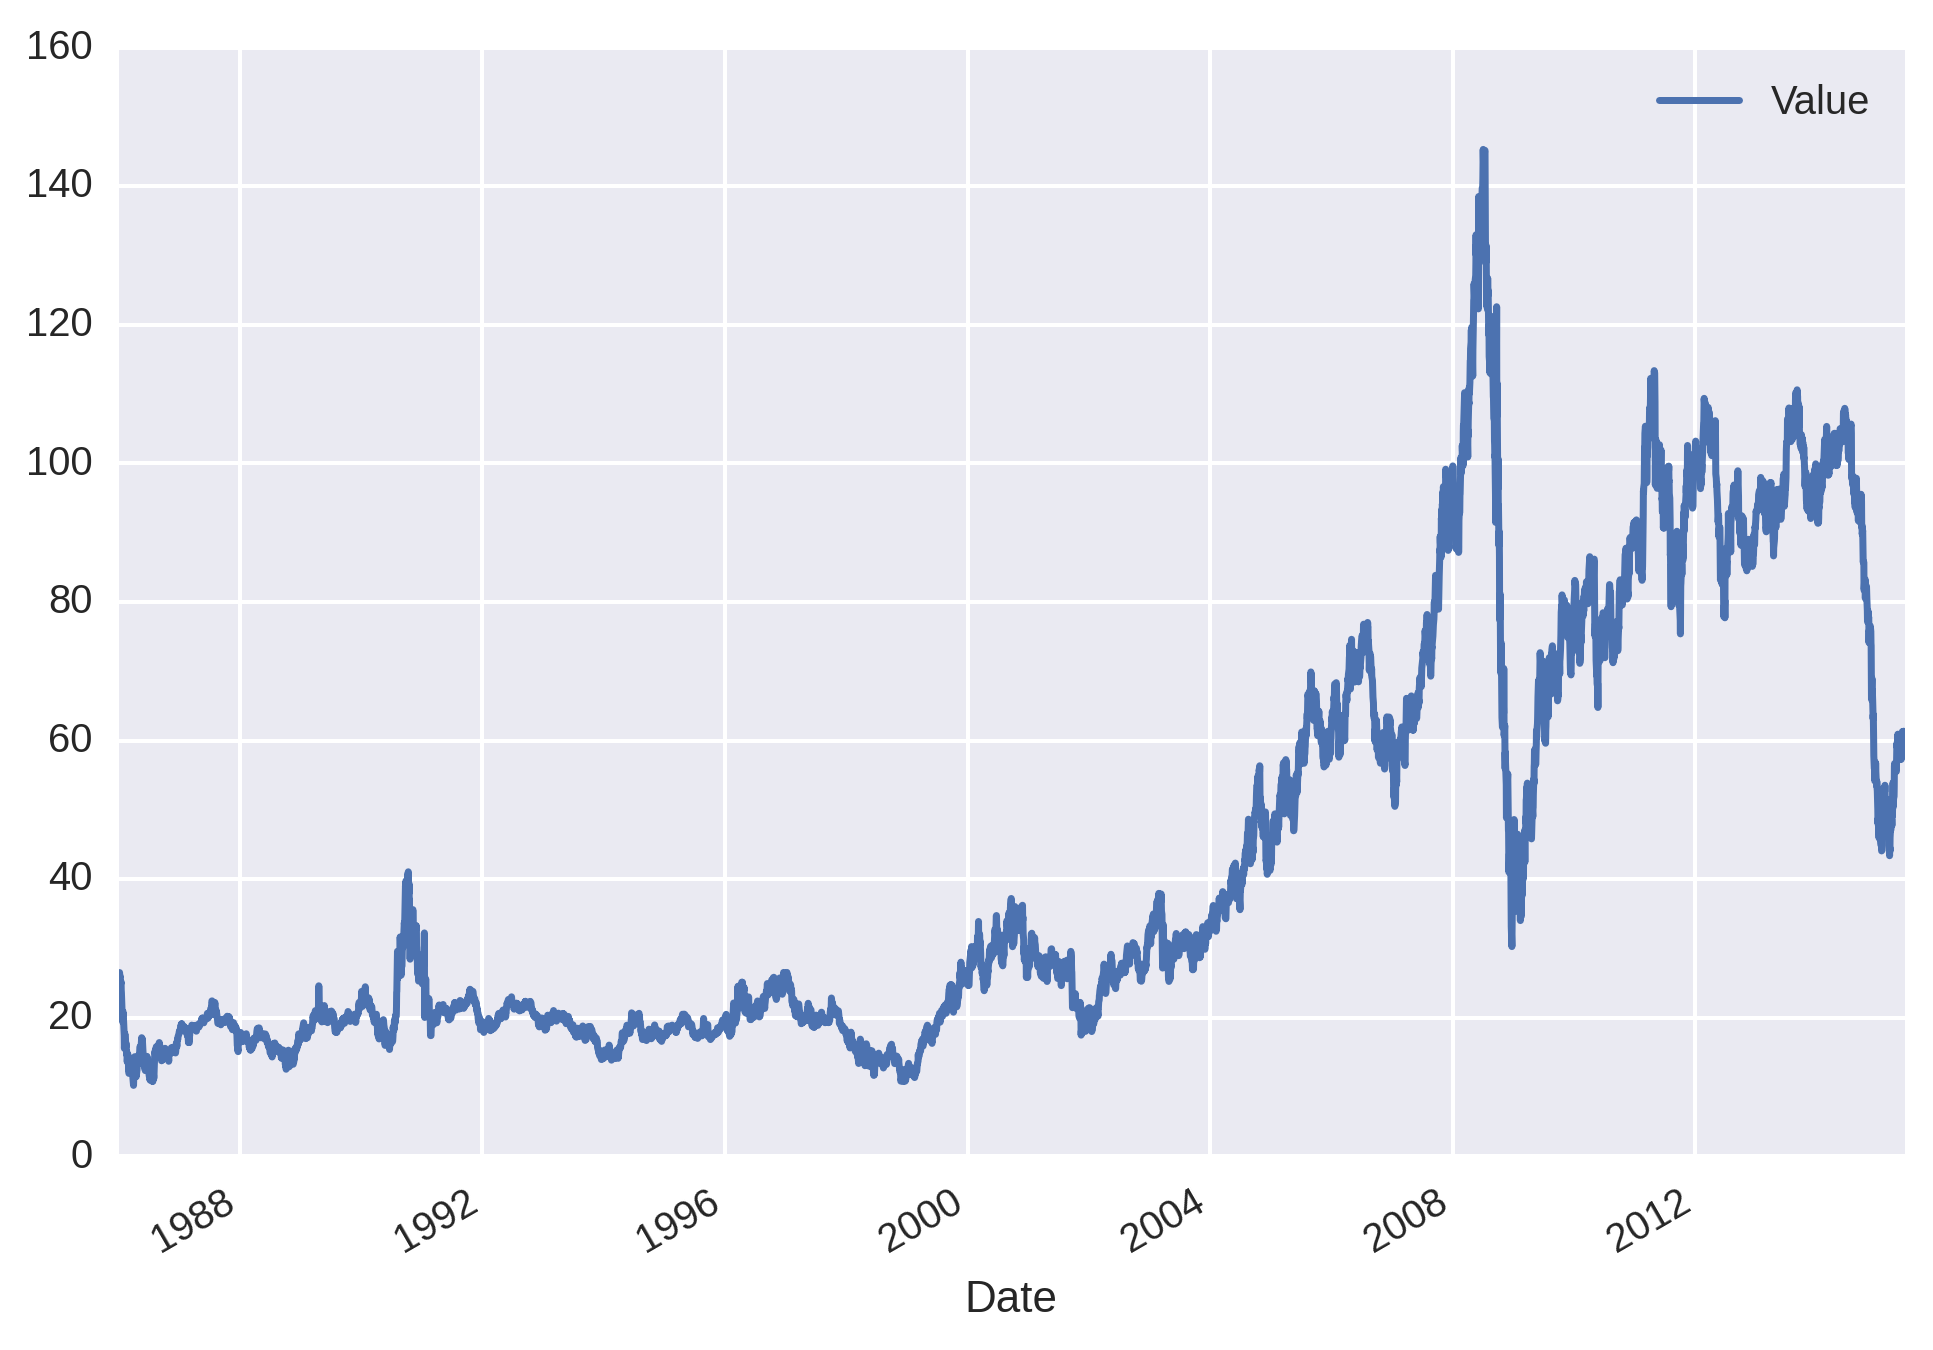

In [6]:
oil.plot()
# plt.gca().set_yscale('log')

In [7]:
## Create a column with "true" (future) values
PERIOD_MONTH = 20
PREDICTION_LAG = 3*PERIOD_MONTH

CUT_YEAR = 2008
oil['Actual'] = oil['Value'].shift(-PREDICTION_LAG)

## First Step: Take out any 'inflationary' effects.
Suppose, instead, we'd been asked to predict the value **one year** or **five years** out.  The simplest model that we might try is just exponential growth
   $$ P(t) = \exp\left( c_0 + c_1 t \right) $$

To train it we just use a linear regression on $\log P(t)$ to build this model.  If we want to do better, we can content ourselves with modeling its error term.

In [8]:
oil['Julian'] = oil.index.to_julian_date()
oil = sm.add_constant(oil) # Add a constant field for the linear regression

In [9]:
train = oil[ oil.index.year < CUT_YEAR ].dropna(how='any')
train.head()

,const,Value,Actual,Julian
Date,,,,
1986-01-02,1,25.56,10.25,2446432.5
1986-01-03,1,26.00,11.13,2446433.5
1986-01-06,1,26.53,11.35,2446436.5
1986-01-07,1,25.85,11.70,2446437.5
1986-01-08,1,25.87,12.75,2446438.5


In [10]:
# Some justification is required for not doing in-/out-sample here...
#train = oil[ oil.index.year < CUT_YEAR ].dropna(how='any')
train = oil
exponential_model = sklearn.linear_model.Ridge().fit( 
    X=train[['Julian', 'const']].values, 
    y=np.log(train['Value'].values)
)

exp_model_df = oil
exp_model_df['Exponential_Model'] = np.exp(exponential_model.predict(oil[['Julian', 'const']].values))
exp_model_df['Log_Error_Exponential'] = np.log( oil['Value'] / oil['Exponential_Model'] )

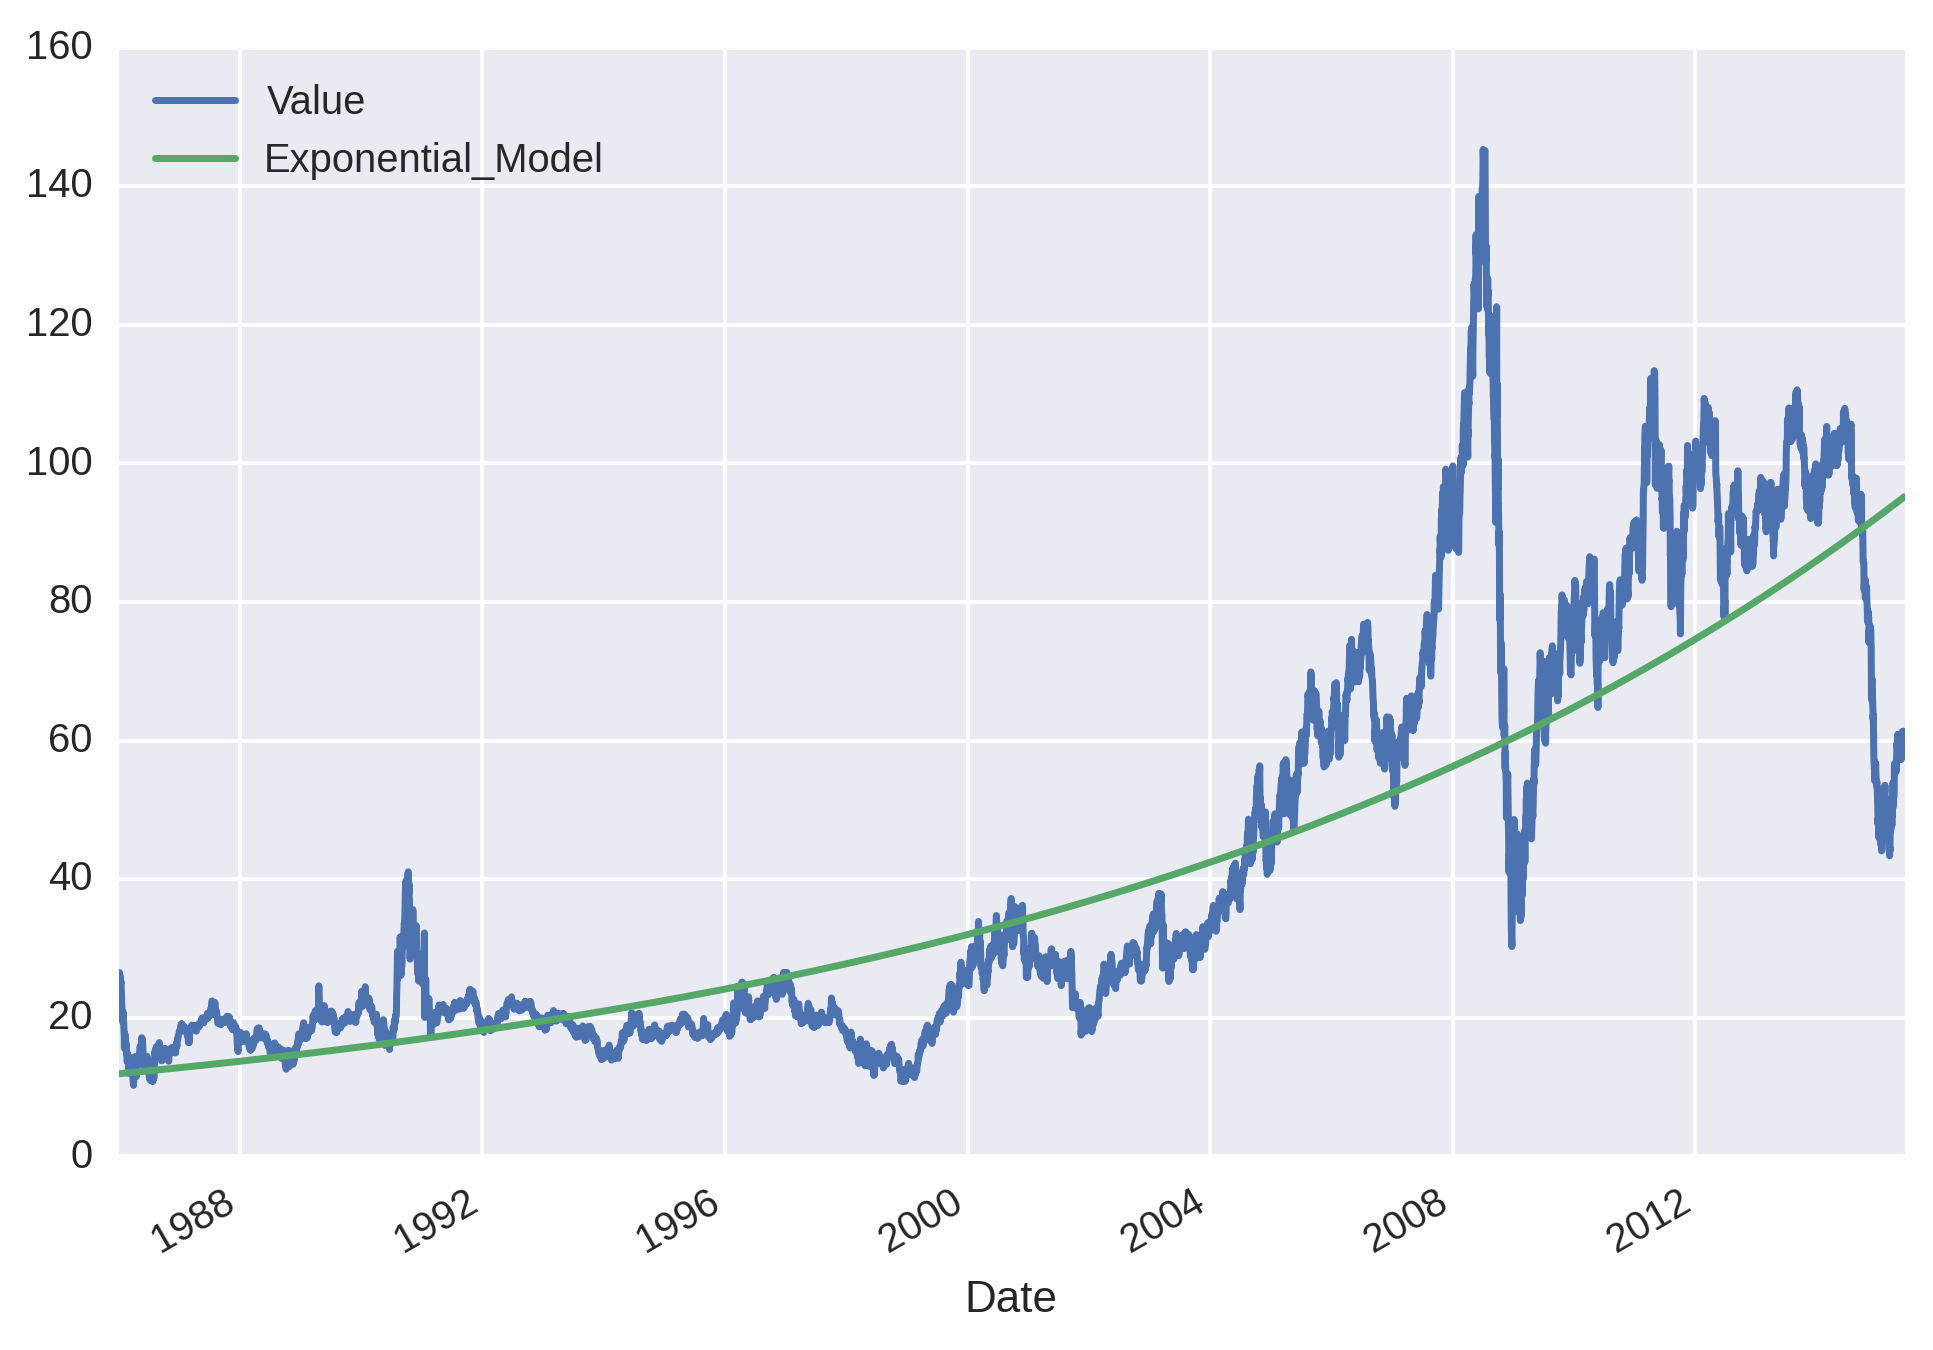

In [11]:
exp_model_df[['Value', 'Exponential_Model']].plot()
# plt.gca().set_yscale('log')

##Step 2: Seasonal effects
We might guess that the price of oil goes up in the winter and down in the summer.  Of course, oil can be stored and in an efficient futures market this would be priced in -- so we might _not_ expect to see it.  Let's do two analyses to try to check for it:
 - Visual inspection (with a weighted average, for smoothing)
 - A Fast Fourier Transform
 
(Later on, we will also look at the _autocorrelation_ which is another technique for this.)

## Weighted average (with smoothing)
There are many types of [moving average](http://en.wikipedia.org/wiki/Moving_average).  We will be computing the exponentially weighted moving average:

$$E_t = \alpha X_t + (1-\alpha)E_{t-1}$$

Since we can see that something crazy happened in 2008 (financial meltdown) and something else crazy happened in 1992 (Iraq War), we'll restrict to between those two dates.

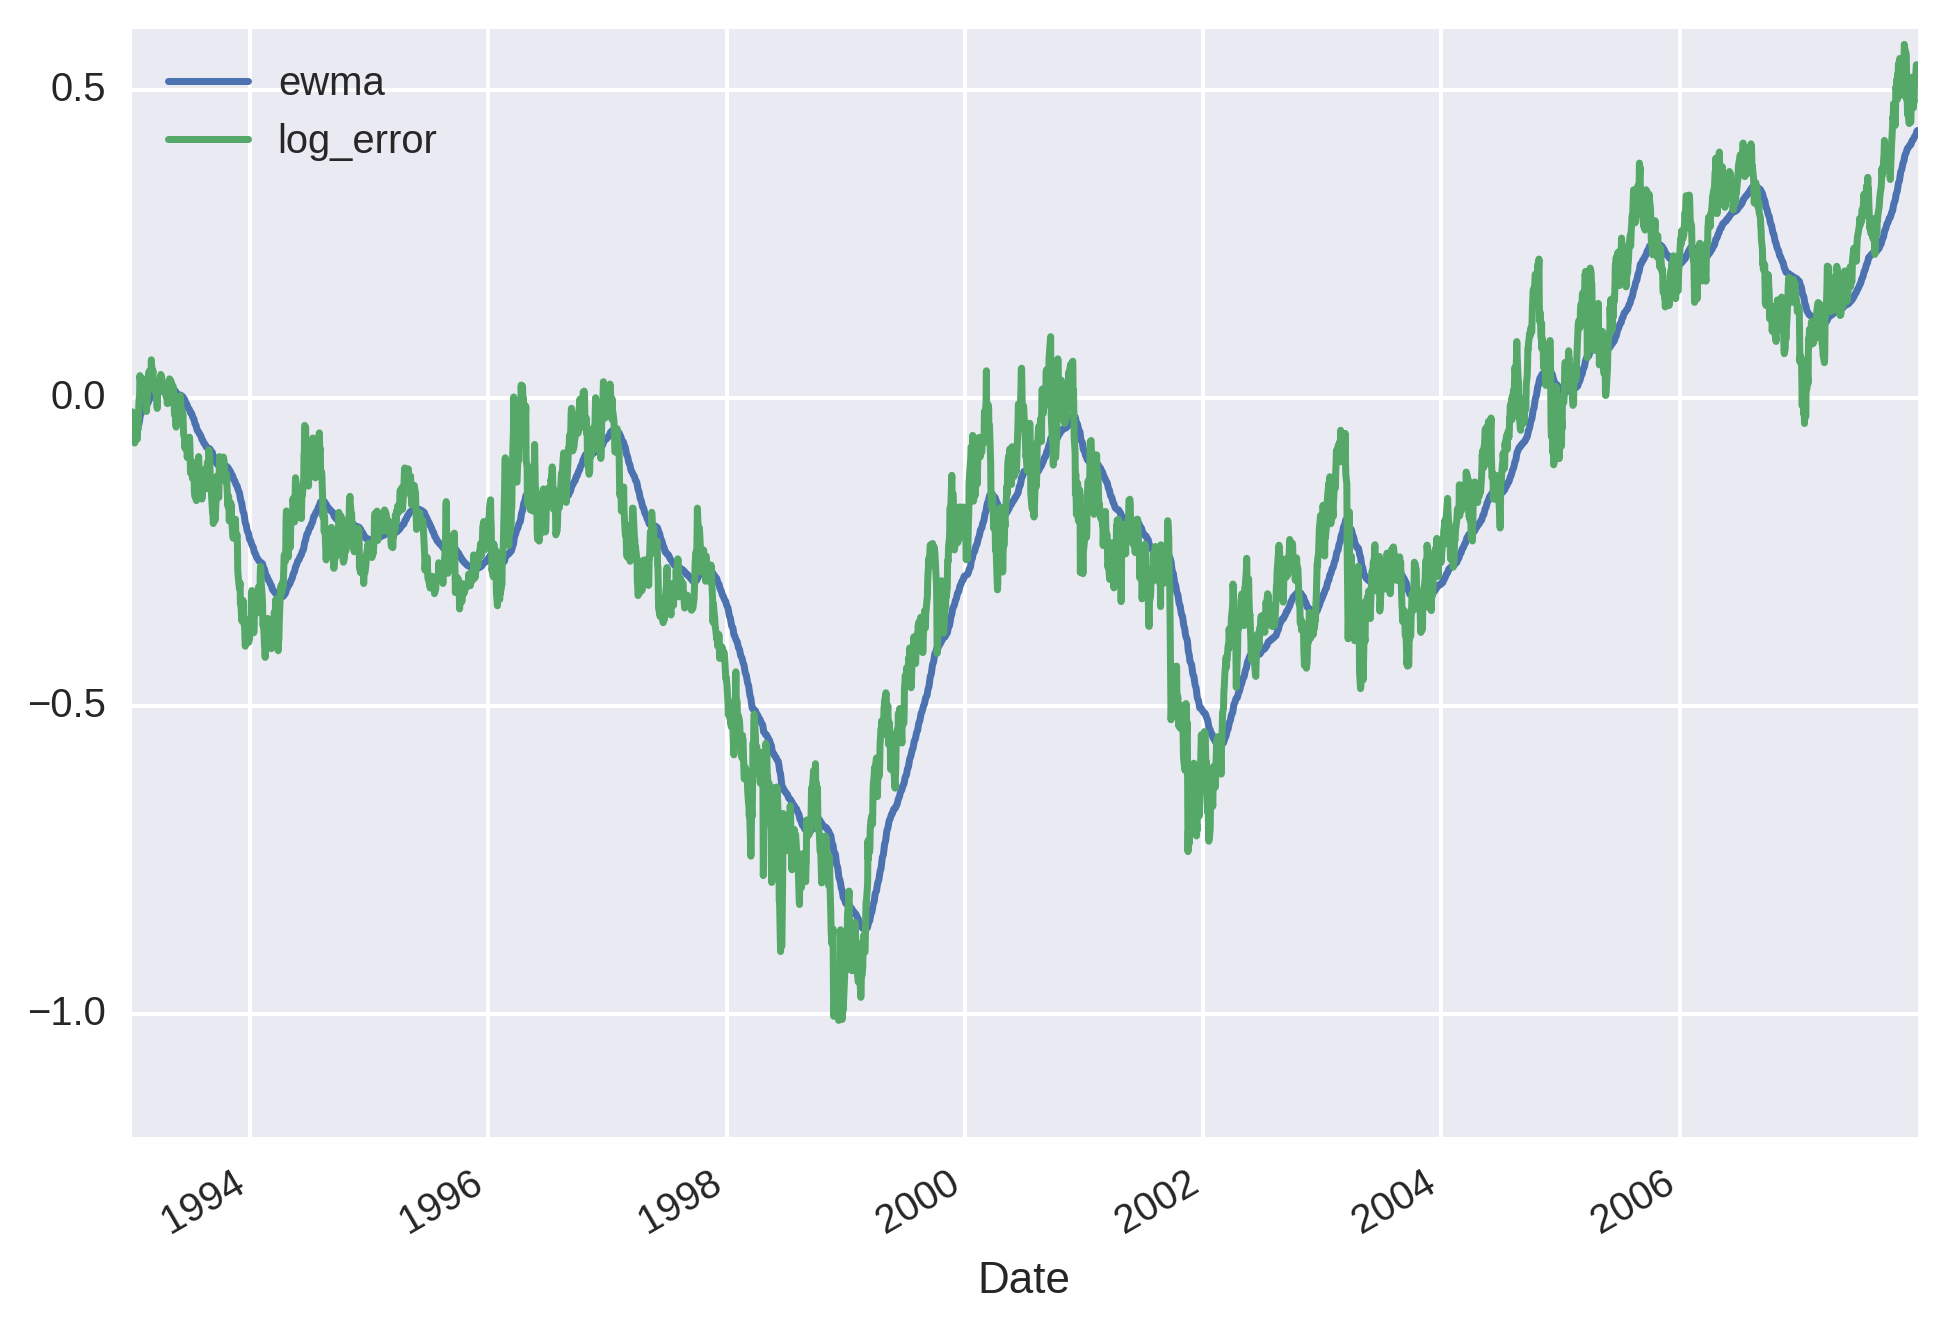

In [12]:
log_error = oil['Log_Error_Exponential'][(oil.index.year > 1992) & (oil.index.year < 2008)]
pd.DataFrame({
    'log_error': log_error,
    'ewma': pd.ewma( log_error, span=100 )
}).plot()

# FFT

We can also take a **Fourier transform** (more precisely, an FFT):

(0, 40)

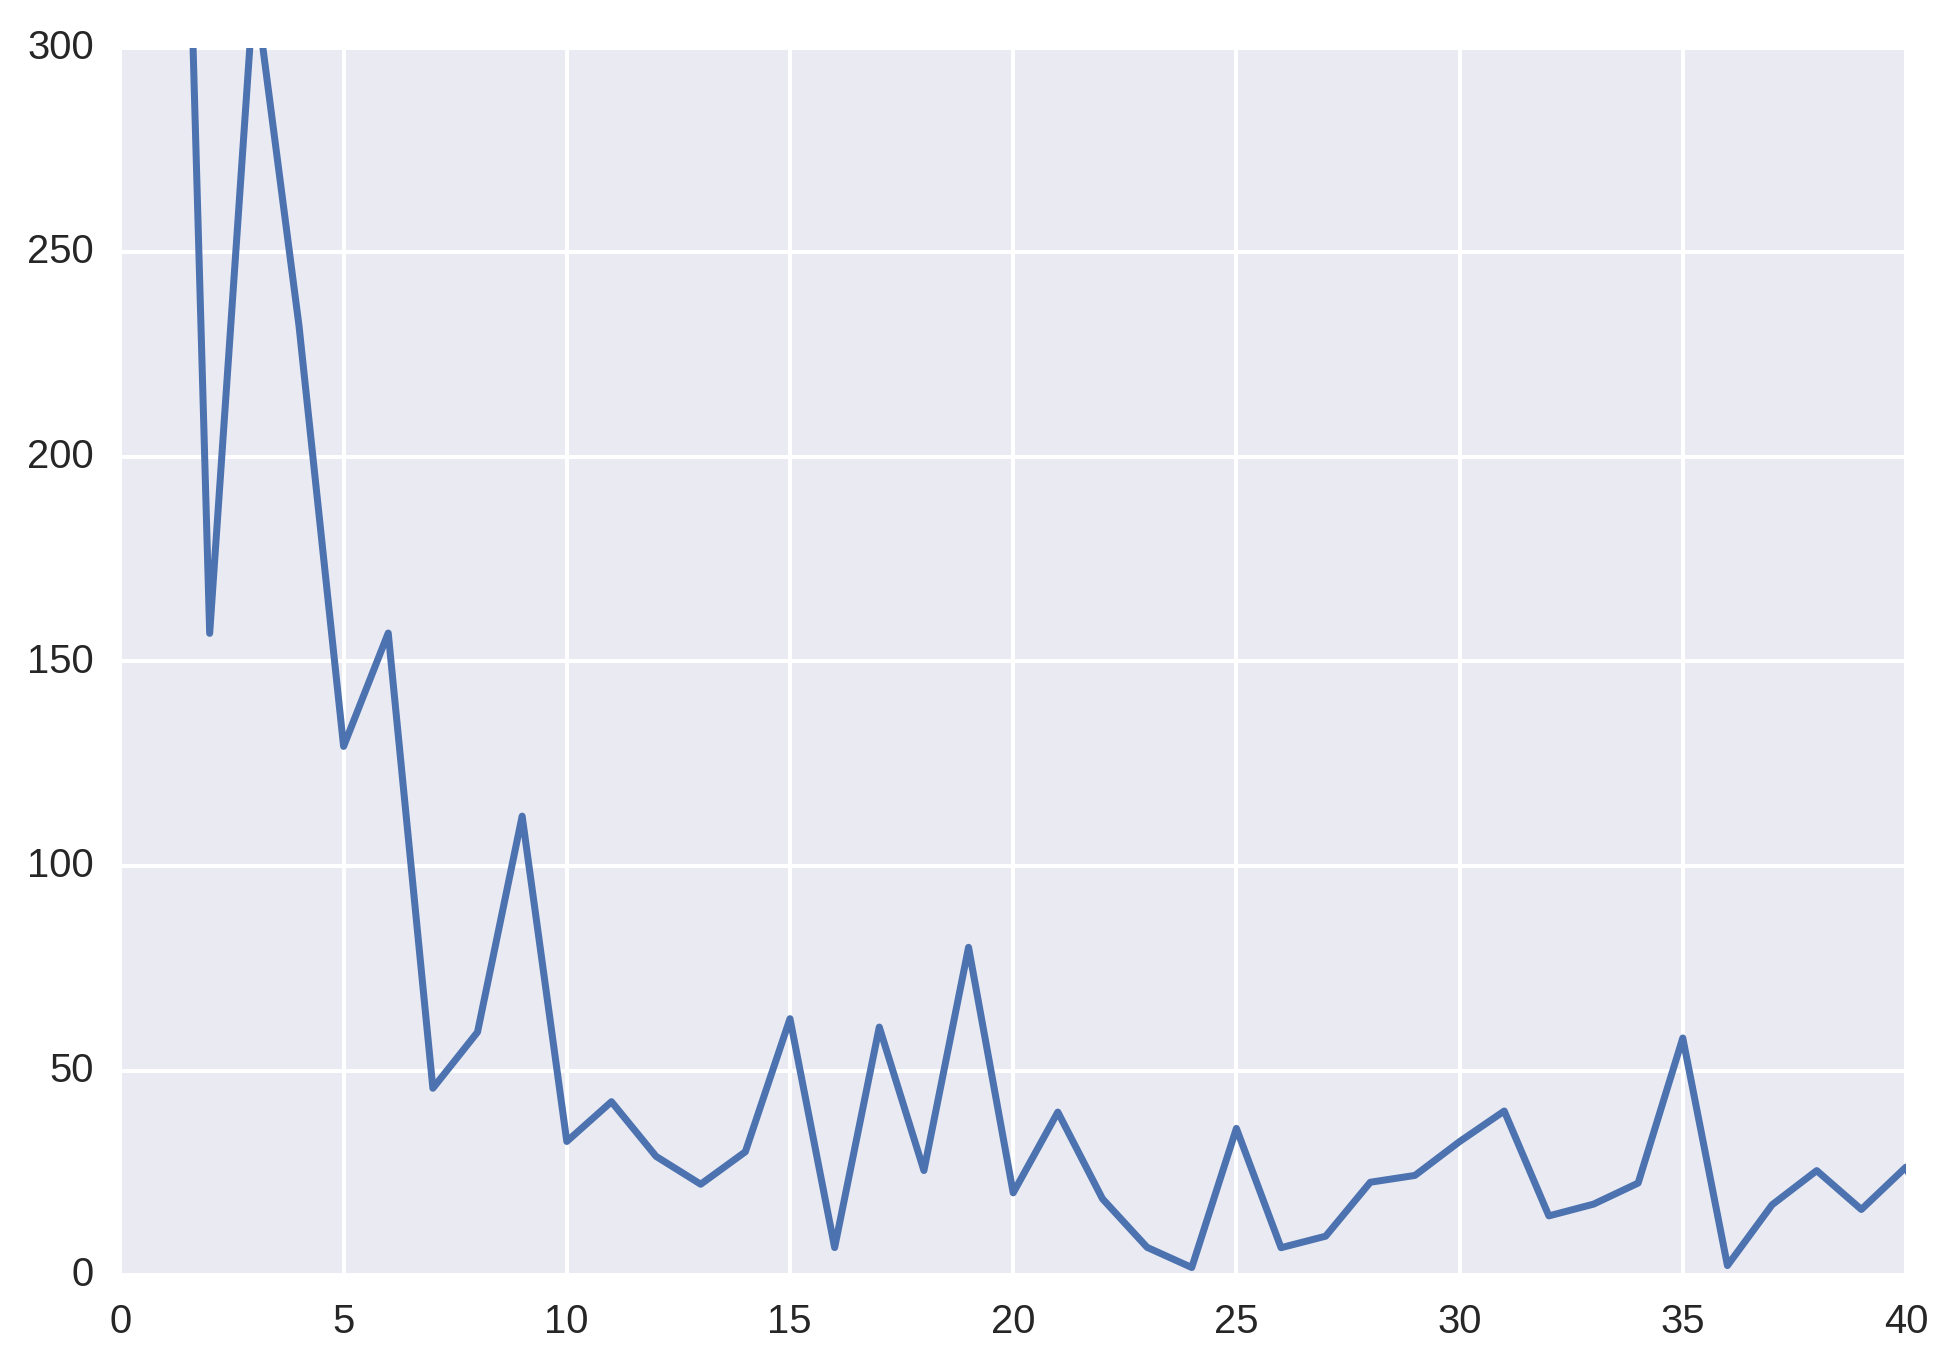

In [13]:
plt.plot(np.abs( np.fft.fft( oil['Log_Error_Exponential'][(oil.index.year > 1992) & (oil.index.year < 2008)].values ) ))
pylab.ylim([0,300])
pylab.xlim([0,40])

array([ 540.61605031,  721.86582764,  207.00459752,  258.39563791,
        272.82190334,  183.02439627,  202.58639183,  164.18902847,
        116.13714781,  172.67301272,  184.588479  ,   43.11444468,
         99.64635609,   61.47307063,   53.06531078,   58.14682431,
         76.39351862,  114.7835633 ,   53.01193218,   85.75051284])

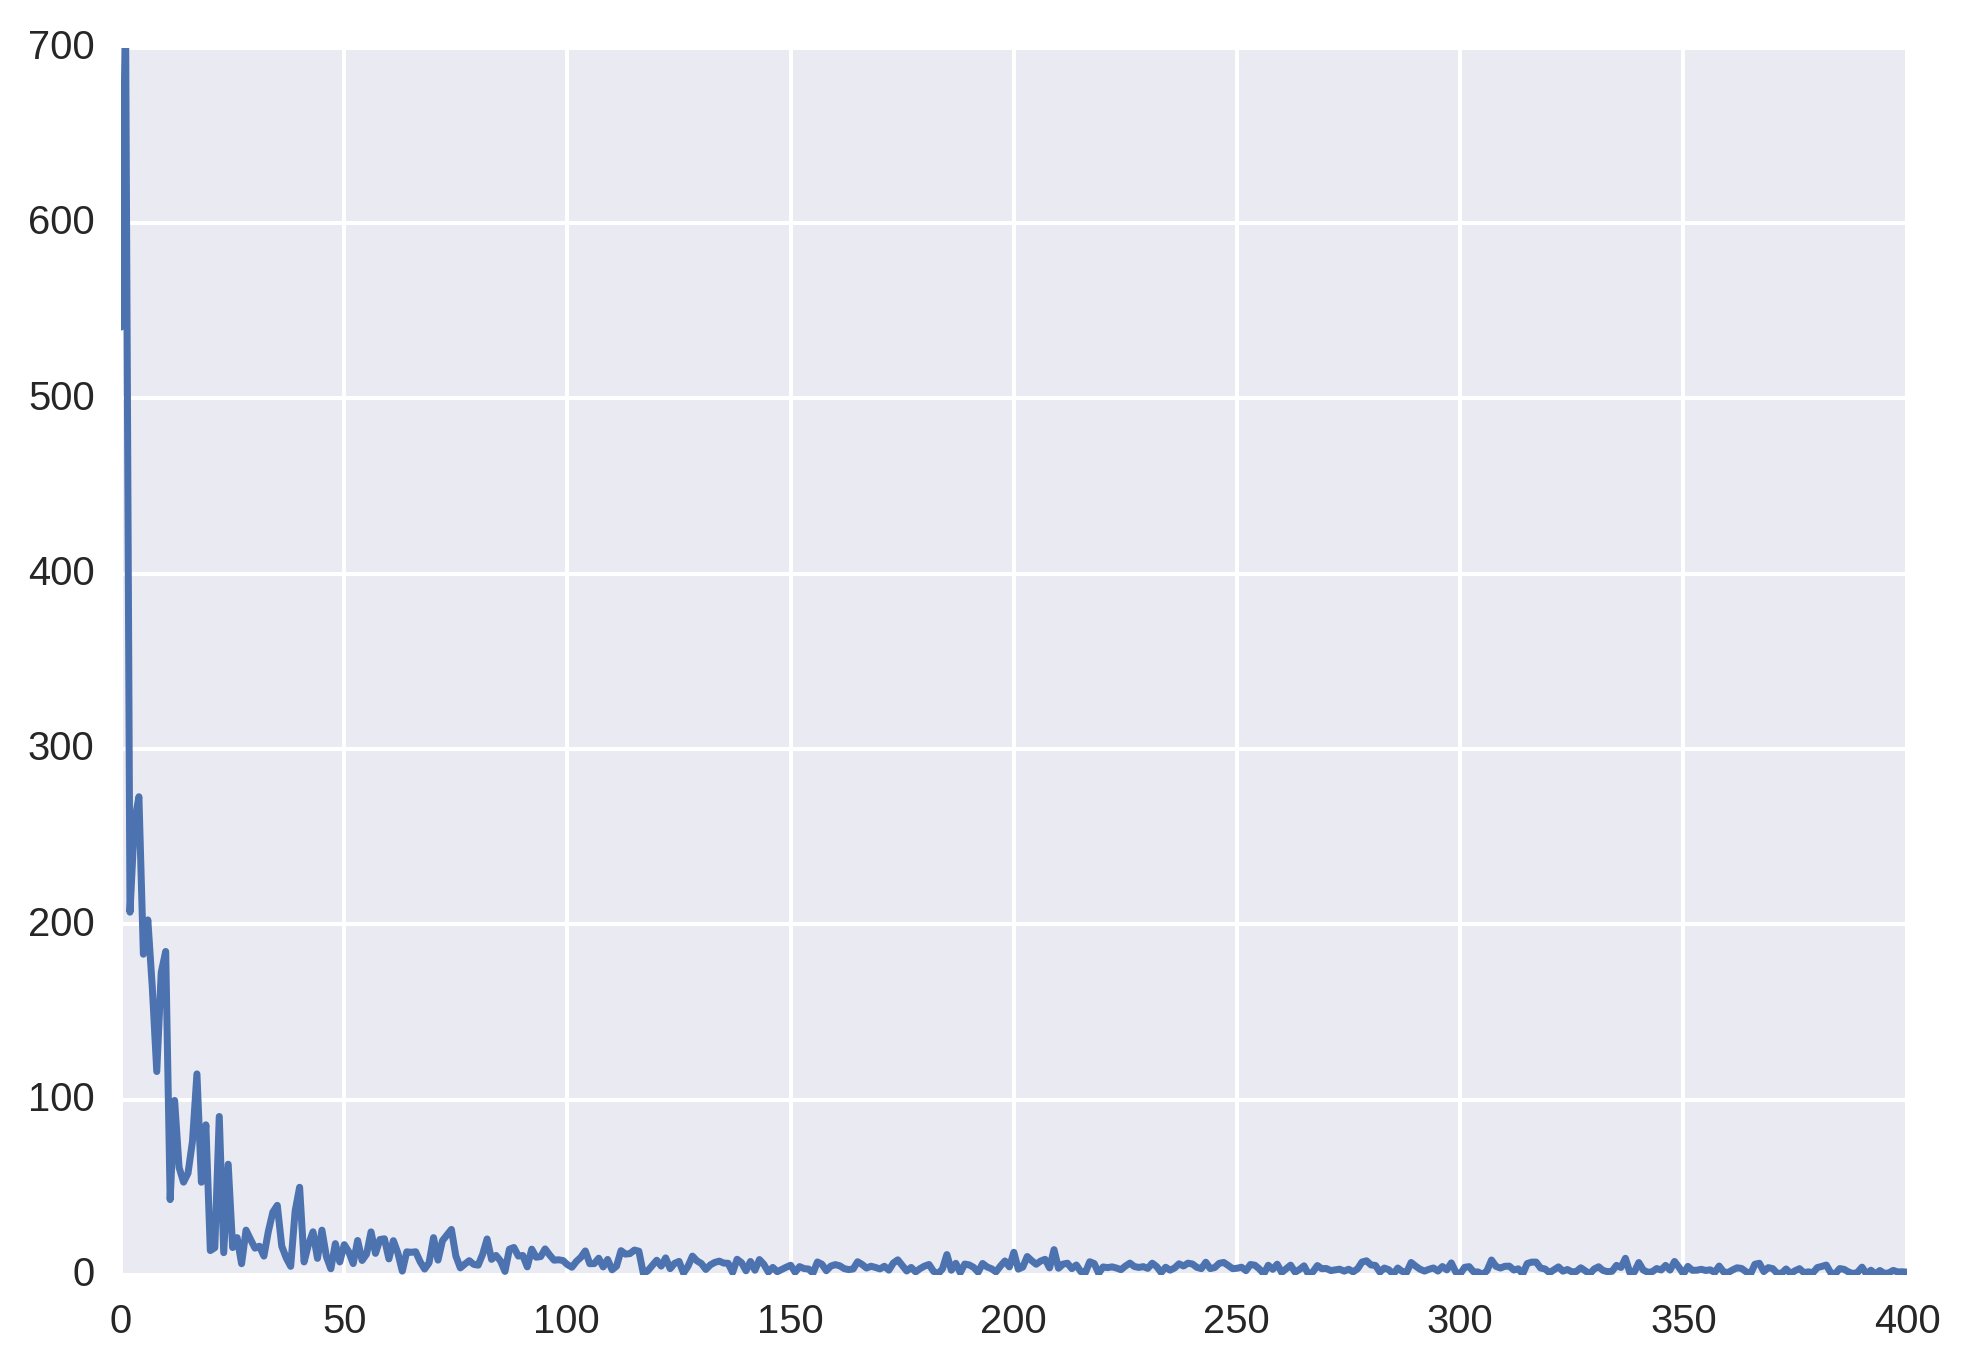

In [14]:
fft = np.fft.fft( oil['Log_Error_Exponential'][(oil.index.year > 1992) & (oil.index.year < 2010)] )
plt.plot(np.abs( fft ) )
pylab.ylim([0,700])
pylab.xlim([0,400])

np.abs(fft)[:20]

**So what?**  There seems to be pretty much no visible season effect... 

_(Except for a slight monthly variation, spike @ 30 days) -RH_

**Exercise:** Suppose we had use something that _is_ clearly seasonal (e.g., the temperature data in the next cell).  Carry out the above analysis (and the lagged auto-correlation one below) with the temperature data below, and confirm that it is reasonable.

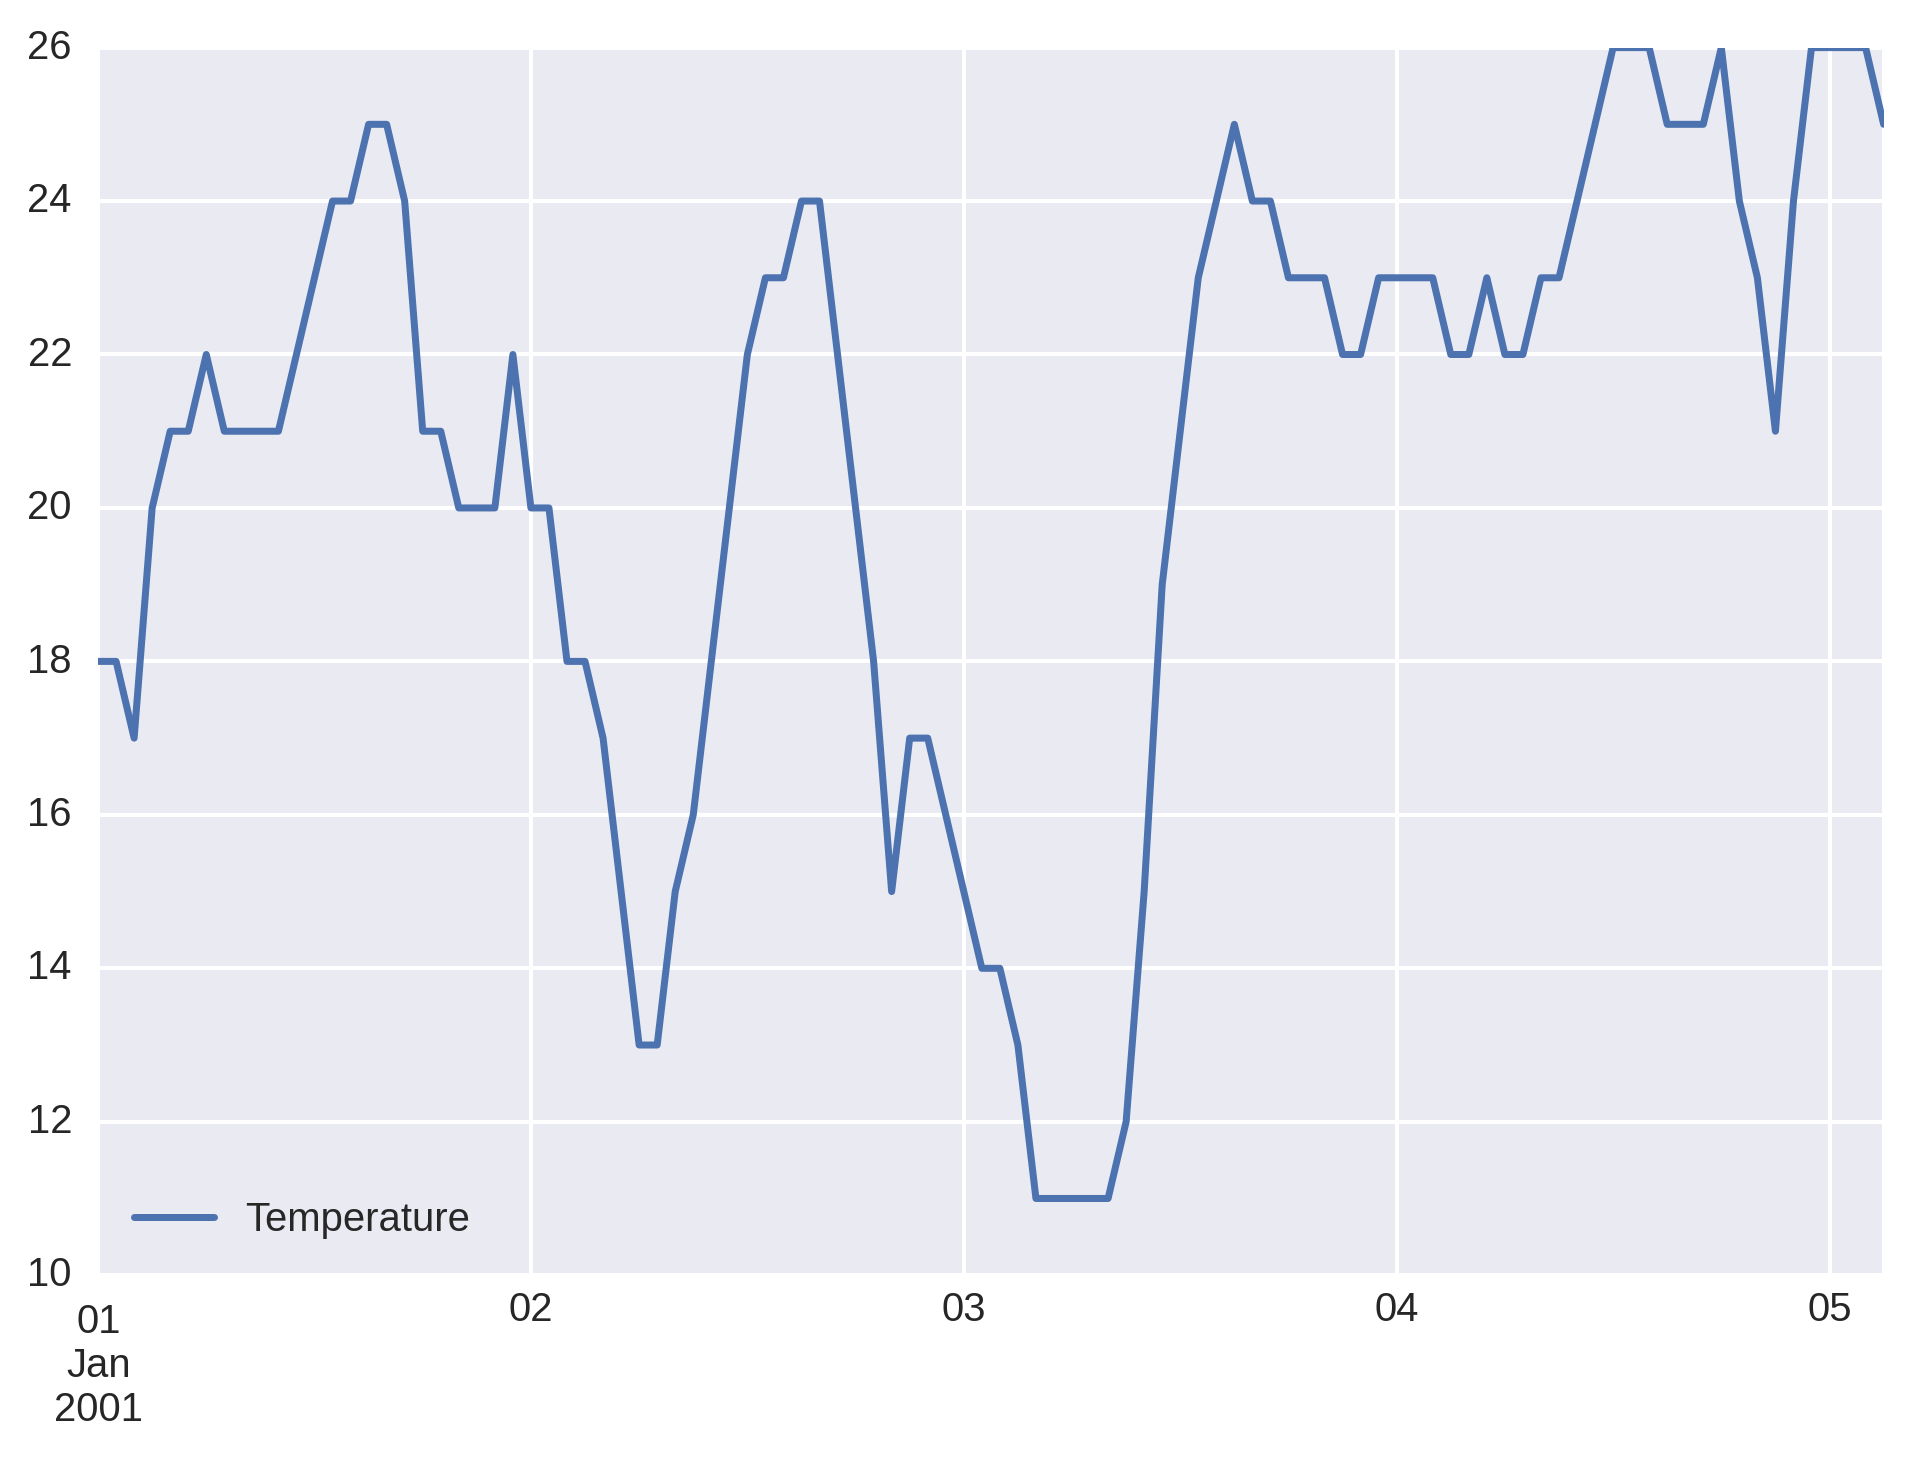

In [24]:
temps_df = pd.read_csv("../projects/timeseries-project/data/raw/temperatures.csv", index_col=0, names=["Temperature"], parse_dates=True)
temps_df[:100].plot()


(0, 105)

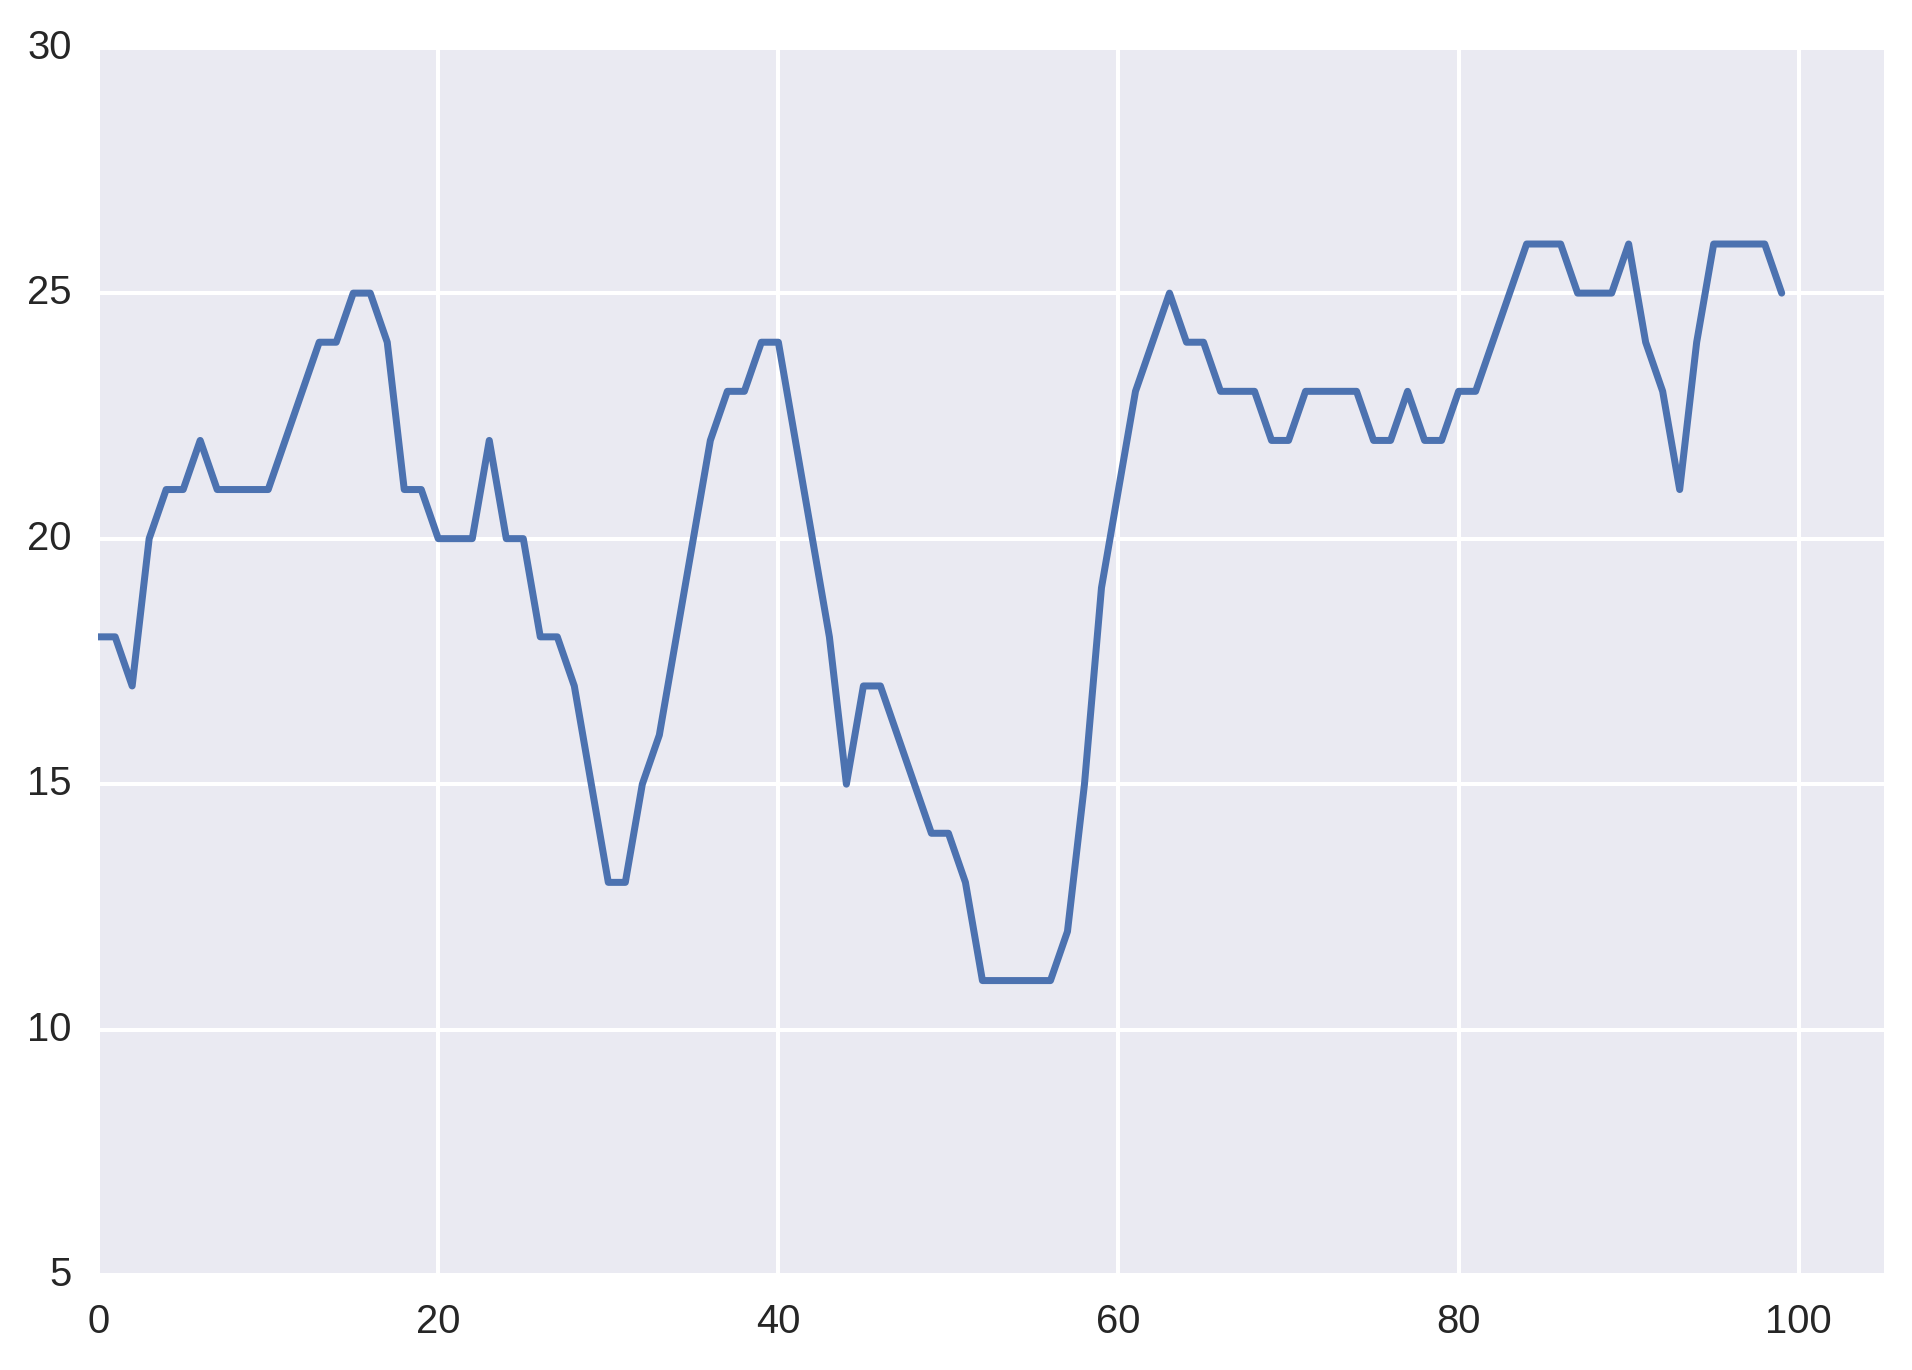

In [30]:
# Take FFT of temp data
fft = (np.abs( np.fft.fft( temps_df[:100] ) ))
plt.plot(np.abs( fft ) )
pylab.ylim([5,30])
pylab.xlim([0,105])

#plt.plot(np.abs( np.fft.fft( oil['Log_Error_Exponential'][(oil.index.year > 1992) & (oil.index.year < 2008)].values ) ))

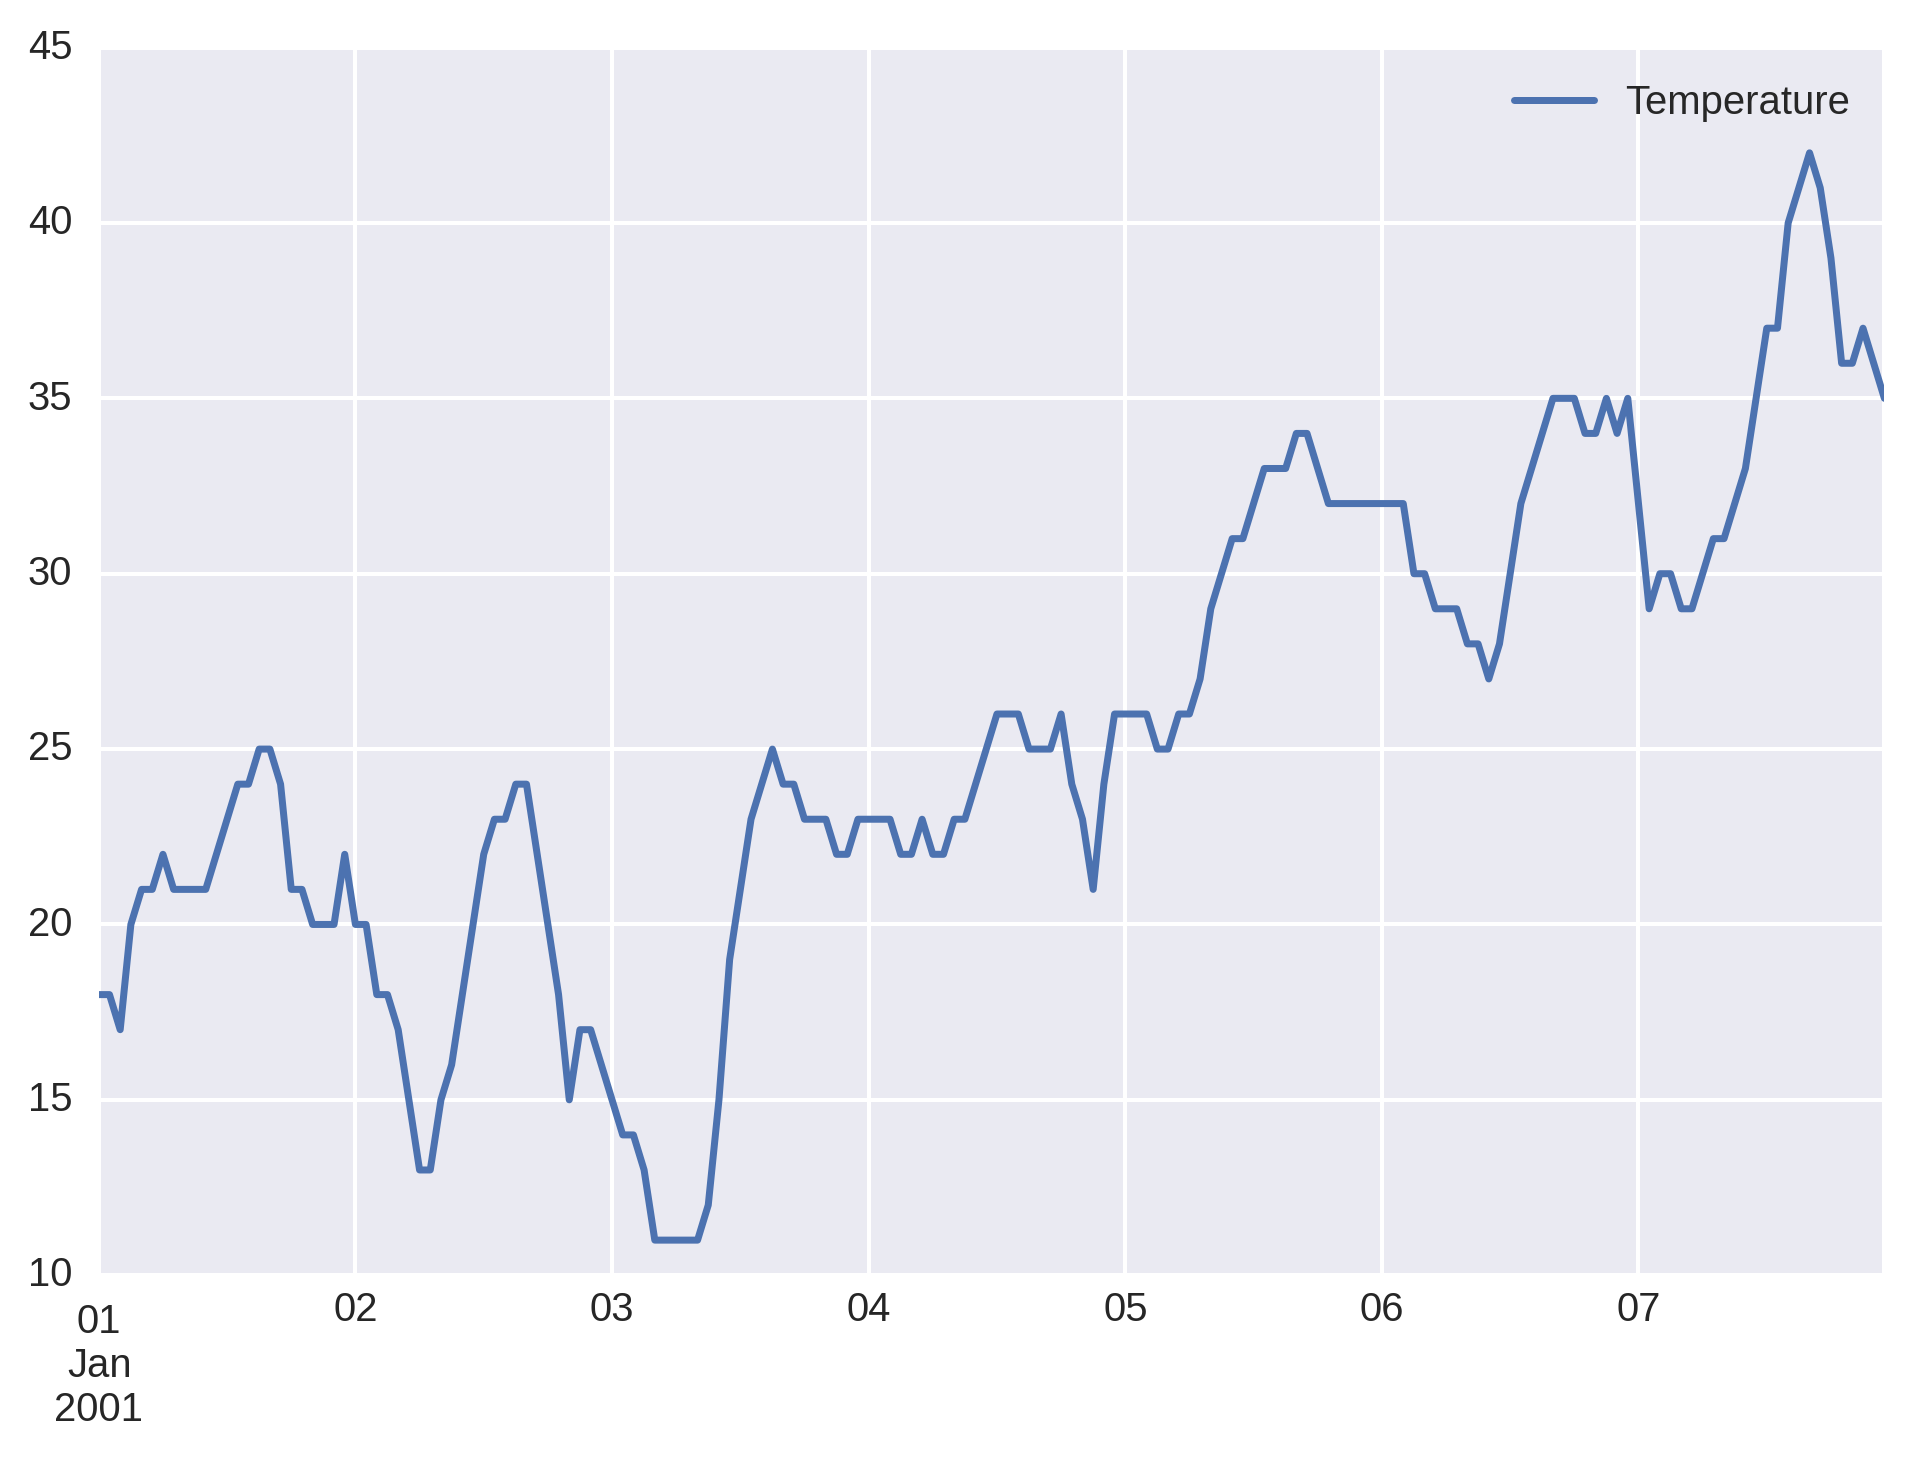

In [17]:
temps_df[:24 * 7].plot()

## Cross validation: In sample and out of sample data sets.

In the above, when we built our simple model, we used all of history for training (and if we did any testing, we again used all of history for that).  When building a predictor, we should be doing some cross validation to make sure that we do not overfit.  

How do we do cross validation for time series data?  Here are some things we generally cannot do:
 - We cannot just pick data points at random, because there might be lagged indicators / seasonal effects / etc. that force us to work with contiguous blocks of time.  
 - We cannot blindly chop by e.g., month or year without some thought: There could be seasonal effects so that Decembers are always different.  There could be systemic "regime changes" that mean that cutting at a given date is inappropriate, or known and time-limited effects that last a year (or fraction thereof).   For instance, the years 1991 and 2008 in this data set.
 
We will pick the following training and testing sets:
 - **Train**: years <2008
 - **Test**: years 2008-present
 
We've picked this to be purposefully a little perverse: it includes the (crazy) price swings of 2008 in the testing set.
 
To start with, we will apply these techniques to a very simple first model:
  - A "benchmark" model: we will just use the current value.

count    1821.000000
mean       -0.048165
std         0.292604
min        -2.433119
25%        -0.111278
50%         0.025057
75%         0.109764
max         0.429218
dtype: float64


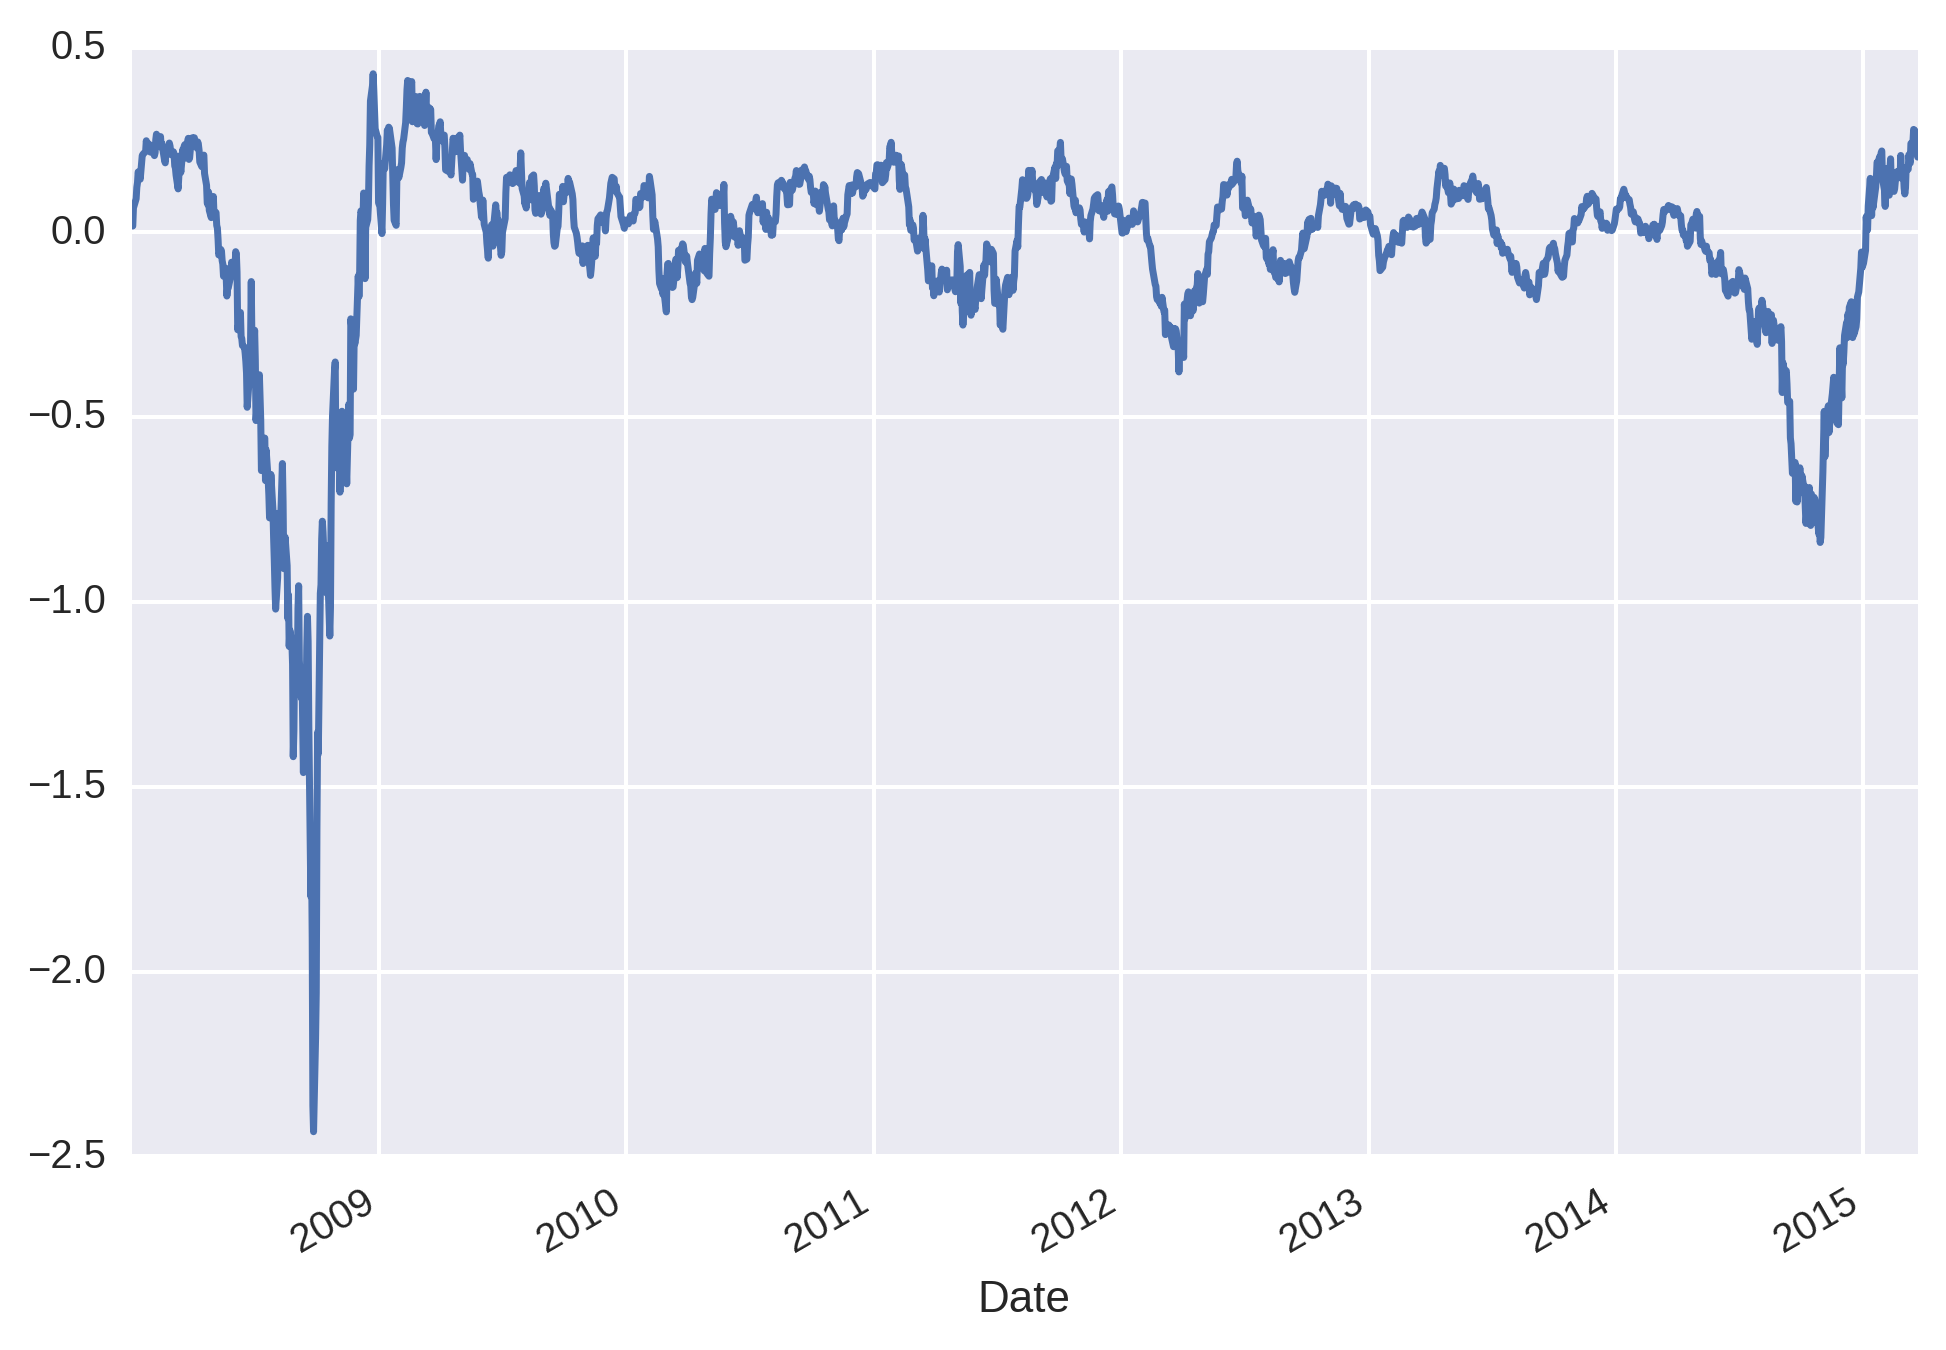

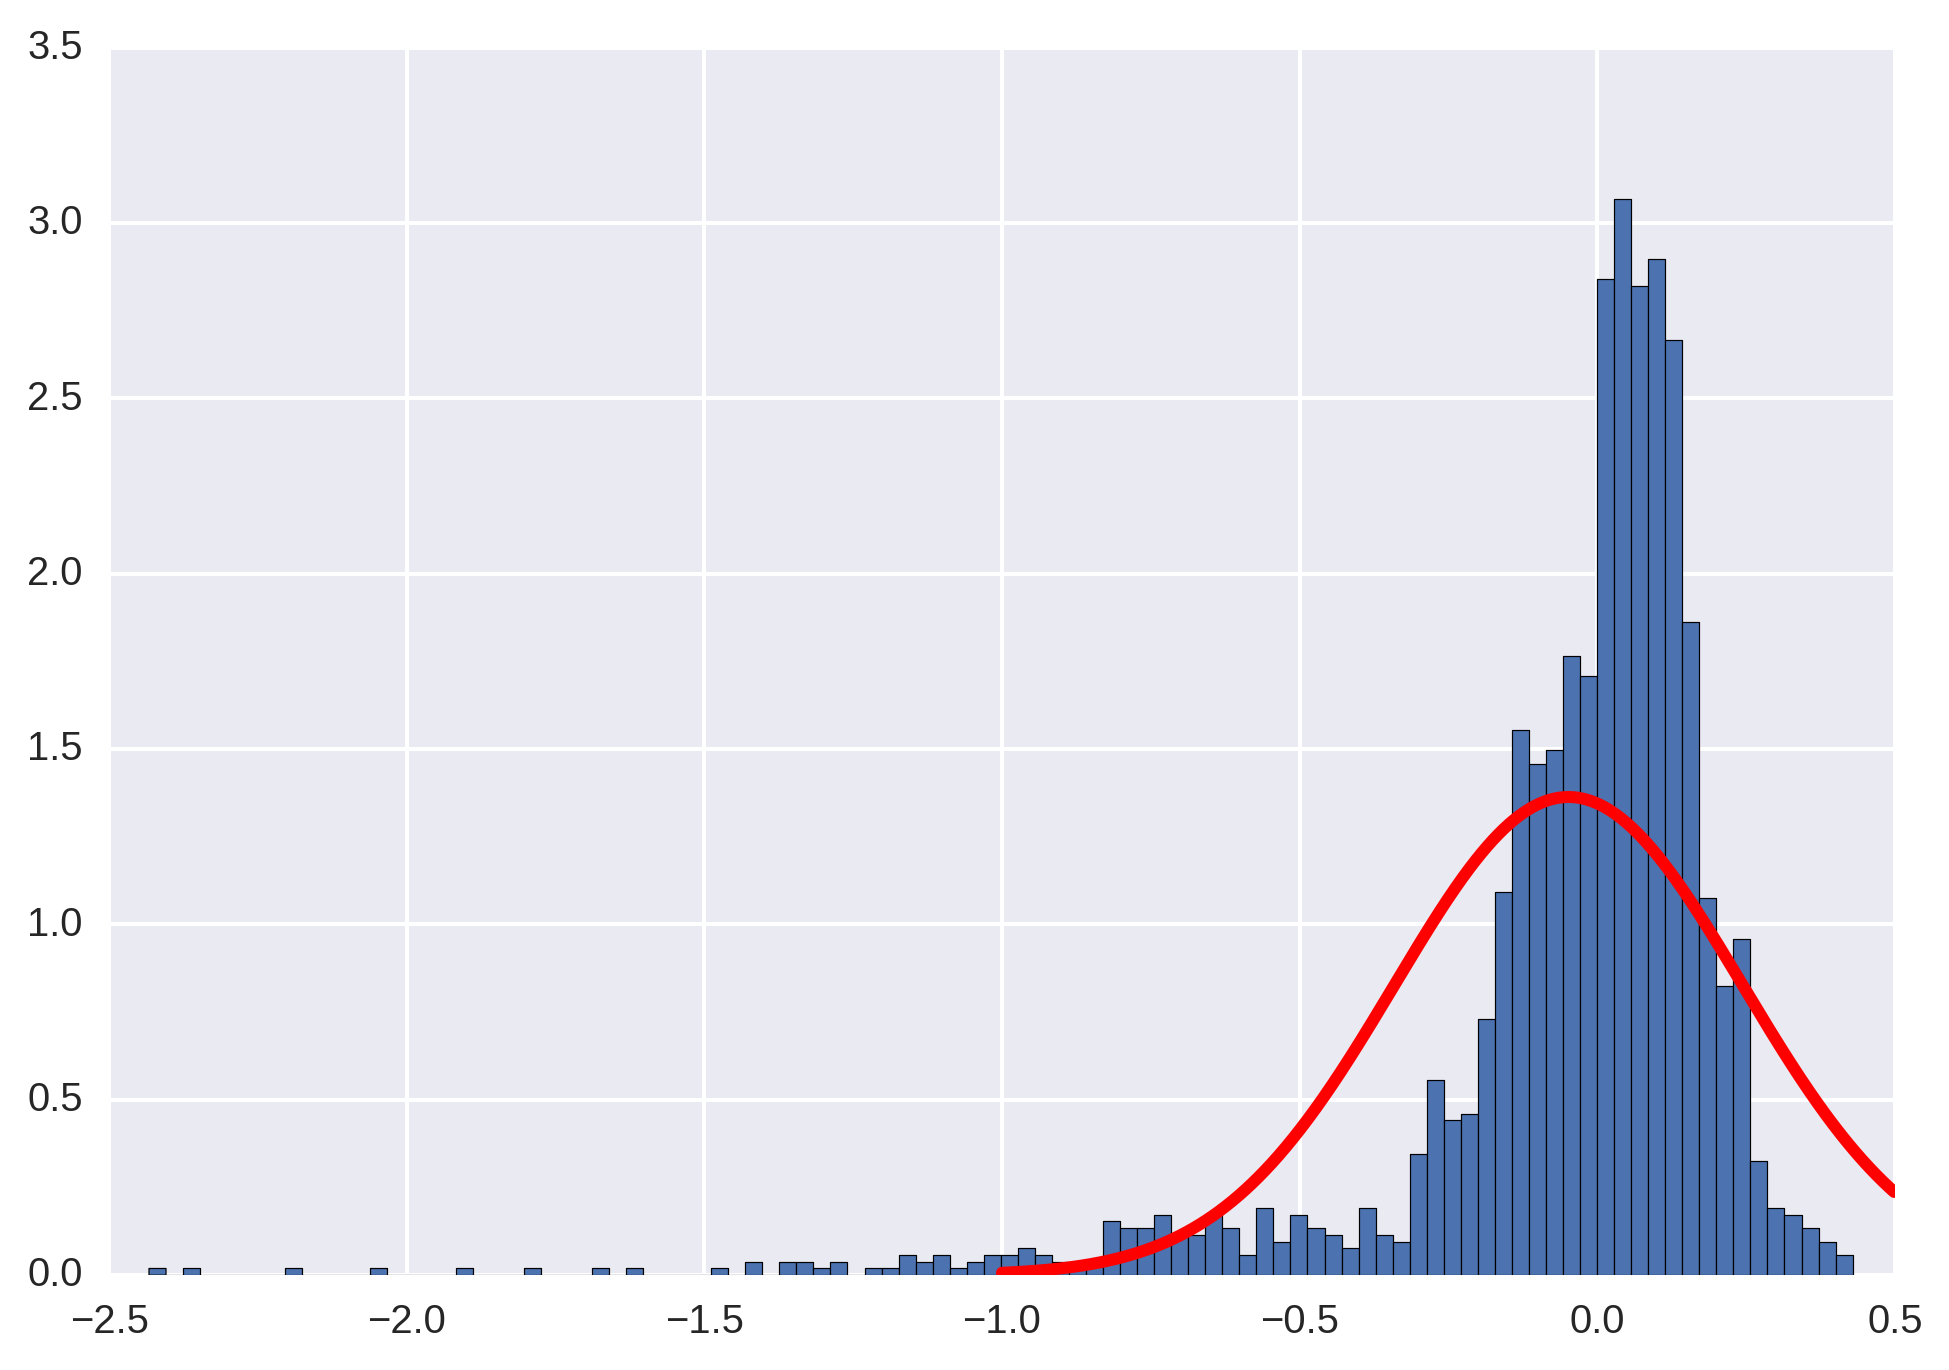

303.583328666


In [18]:
### Cross validation -- benchmark model

#Train/Test
train = oil[ (oil.index.year < CUT_YEAR) ]
test = oil[ (oil.index.year >= CUT_YEAR) ]

# Reporting function
def summarize_errors(test_me):
    error_pct = ((test_me['Actual'] - test_me['Model'])/test_me['Actual'])

    print error_pct.describe()
    error_pct.plot()
    plt.show()

    error_pct.hist(bins=100, normed=True)
    x = np.arange(-1, 0.5, 0.001)
    plt.plot(x, sp.stats.norm( loc=error_pct.mean(), scale=error_pct.std() ).pdf(x), linewidth=3, color='red')
    plt.show()

    print sklearn.metrics.mean_squared_error( test_me['Actual'], test_me['Model'] )

test['Benchmark_Model'] = oil['Value']
test_me = test[['Actual', 'Benchmark_Model']].dropna(how='any')
test_me = test_me.rename(columns = {'Benchmark_Model' : 'Model'})
summarize_errors(test_me)

##Step 3: Lagged auto-correlation
For many time series, the best prediction for $t_{i+1}$ is $t_{i}$ or $t_{i-1}$.  We used something similar as our "benchmark" model above.

One proxy for measuring this is the __auto-correlation__: that is, the correlation between the sequences $t_{i+1}$ and $t_{i}$ (or more generally $t_i$ and $t_{i-\ell}$ for some lag $\ell$).

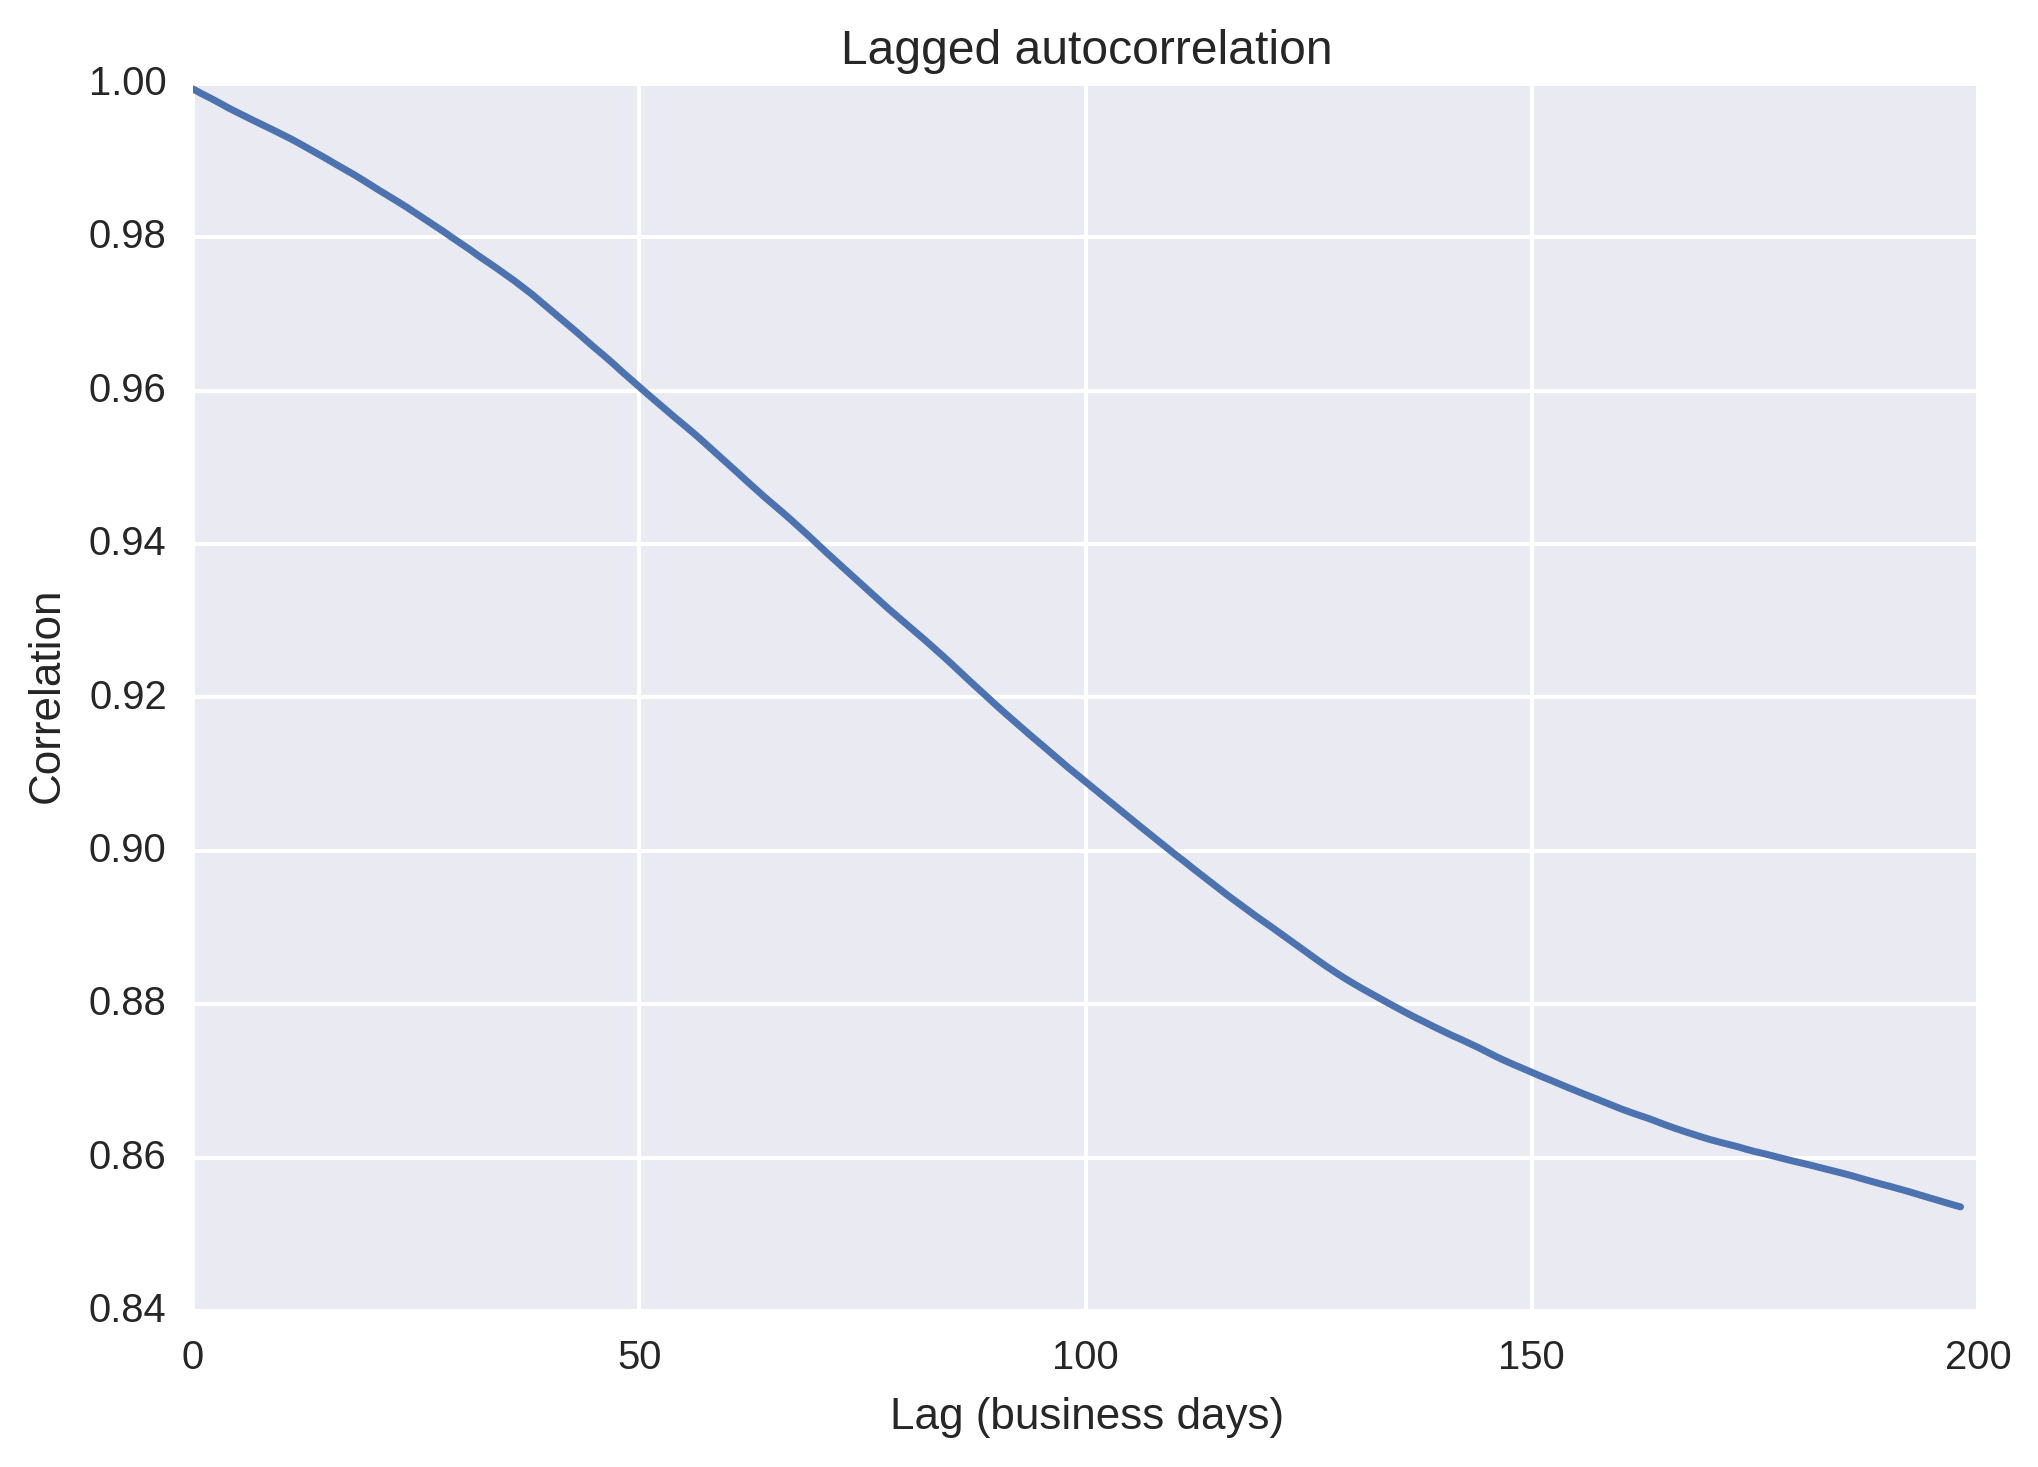

In [31]:
plt.plot( np.array( [ oil['Value'].corr( oil['Value'].shift(i) ) for i in range(1,200) ] ) )
plt.title("Lagged autocorrelation")
plt.ylabel("Correlation")
plt.xlabel("Lag (business days)")

#### So what?
The autocorrelation starts off high, using the last few day's values is likely to be useful.  There are no extra "bumps" or peaks, consistent with our observation that there were no seasonal effects.  

Let's build a second model -- which we will call the "simple" model -- which is also auto-regressive but now takes into account our exponential model from above.  Namely: we will start with the exponential model from before, and then try to estimate __its error__ using an auto-regressive linear model.

count    1761.000000
mean       -0.015813
std         0.268582
min        -2.187236
25%        -0.064998
50%         0.049695
75%         0.124250
max         0.481806
dtype: float64


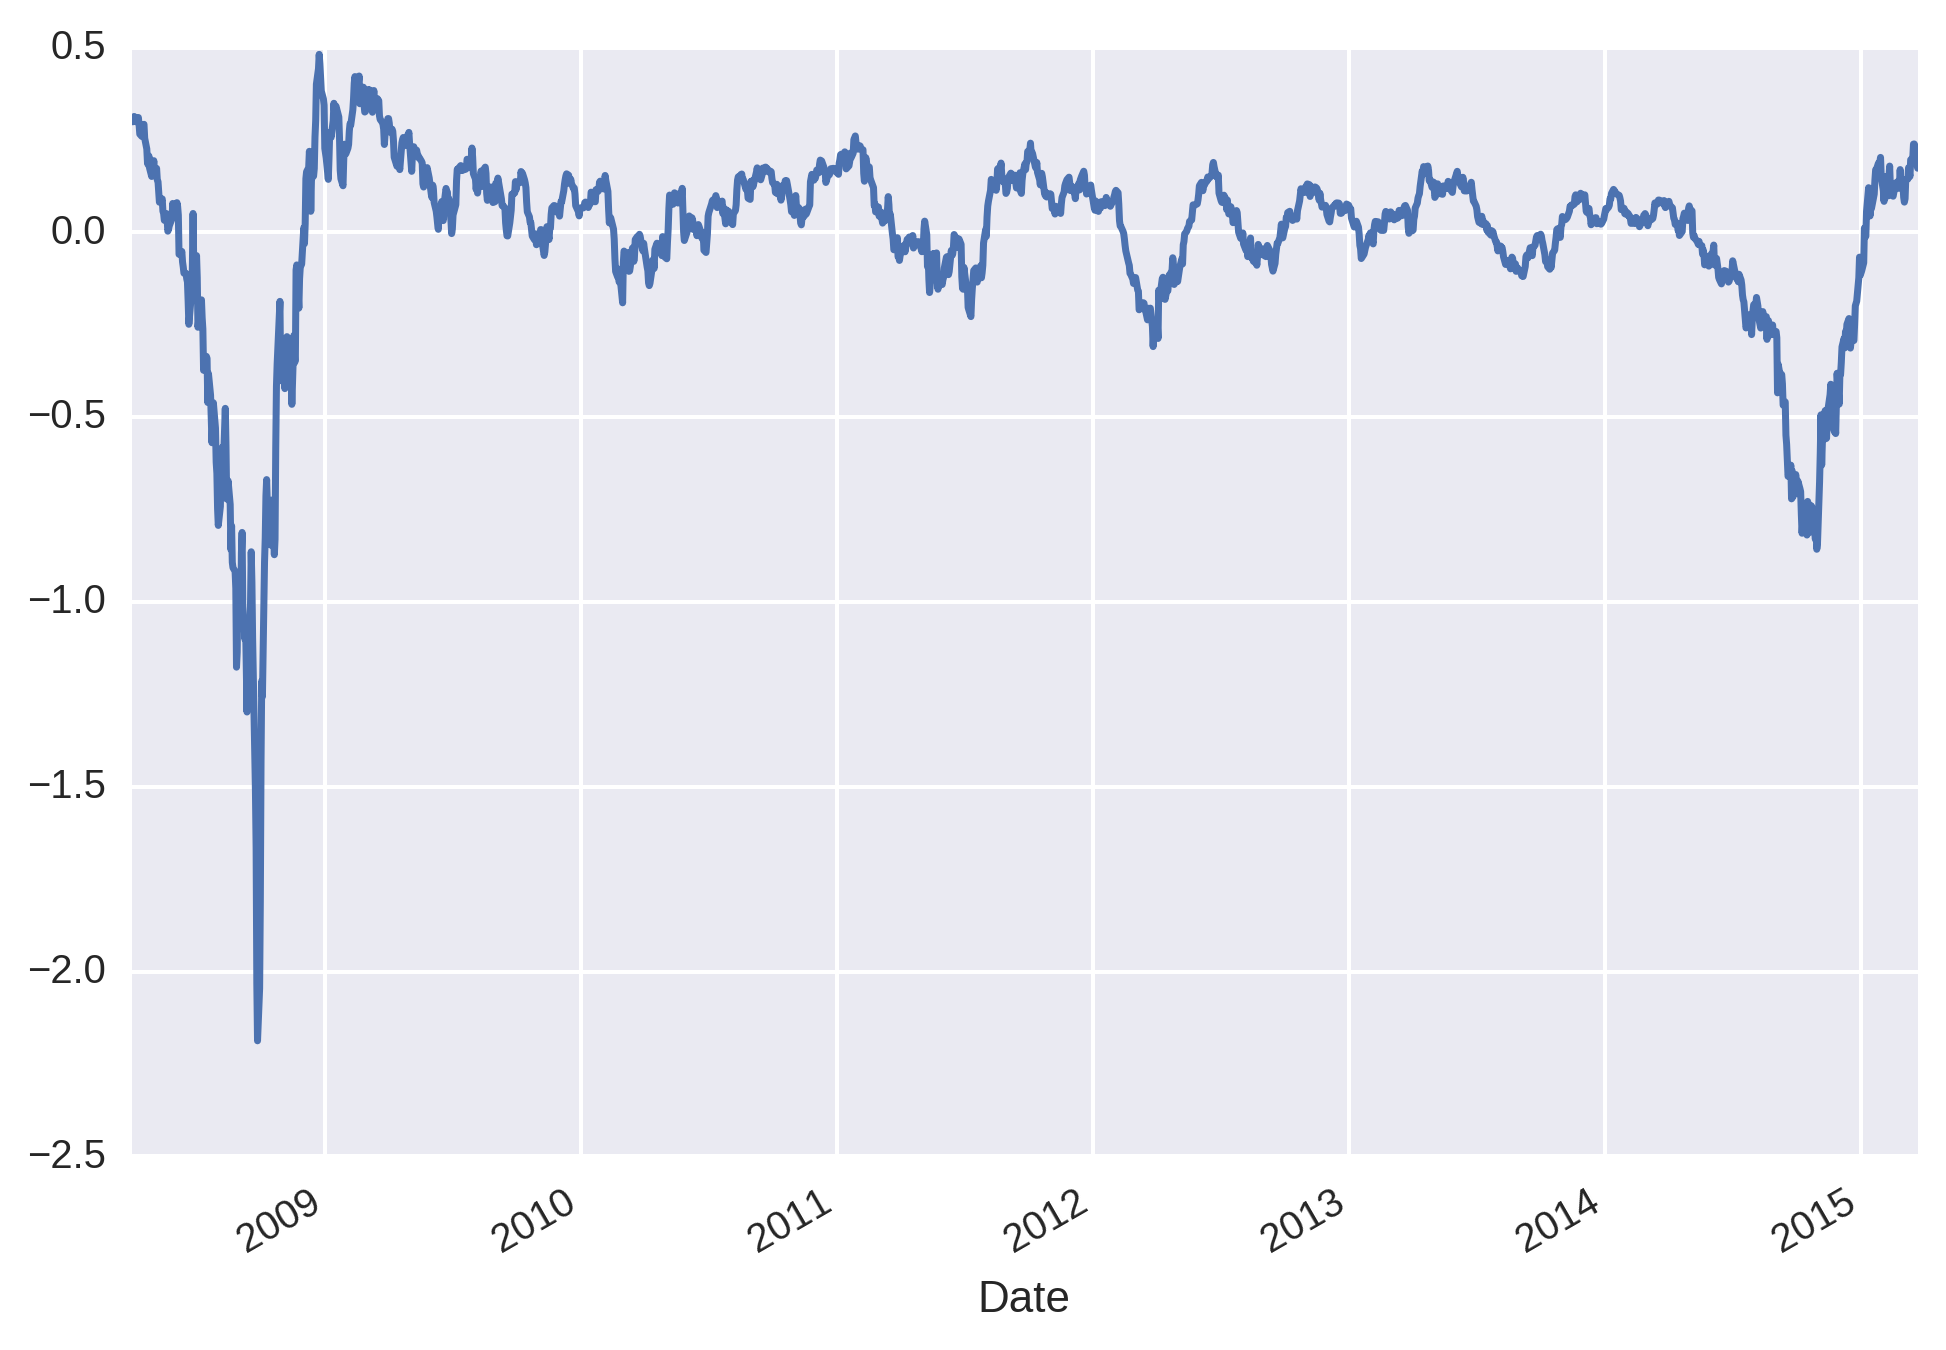

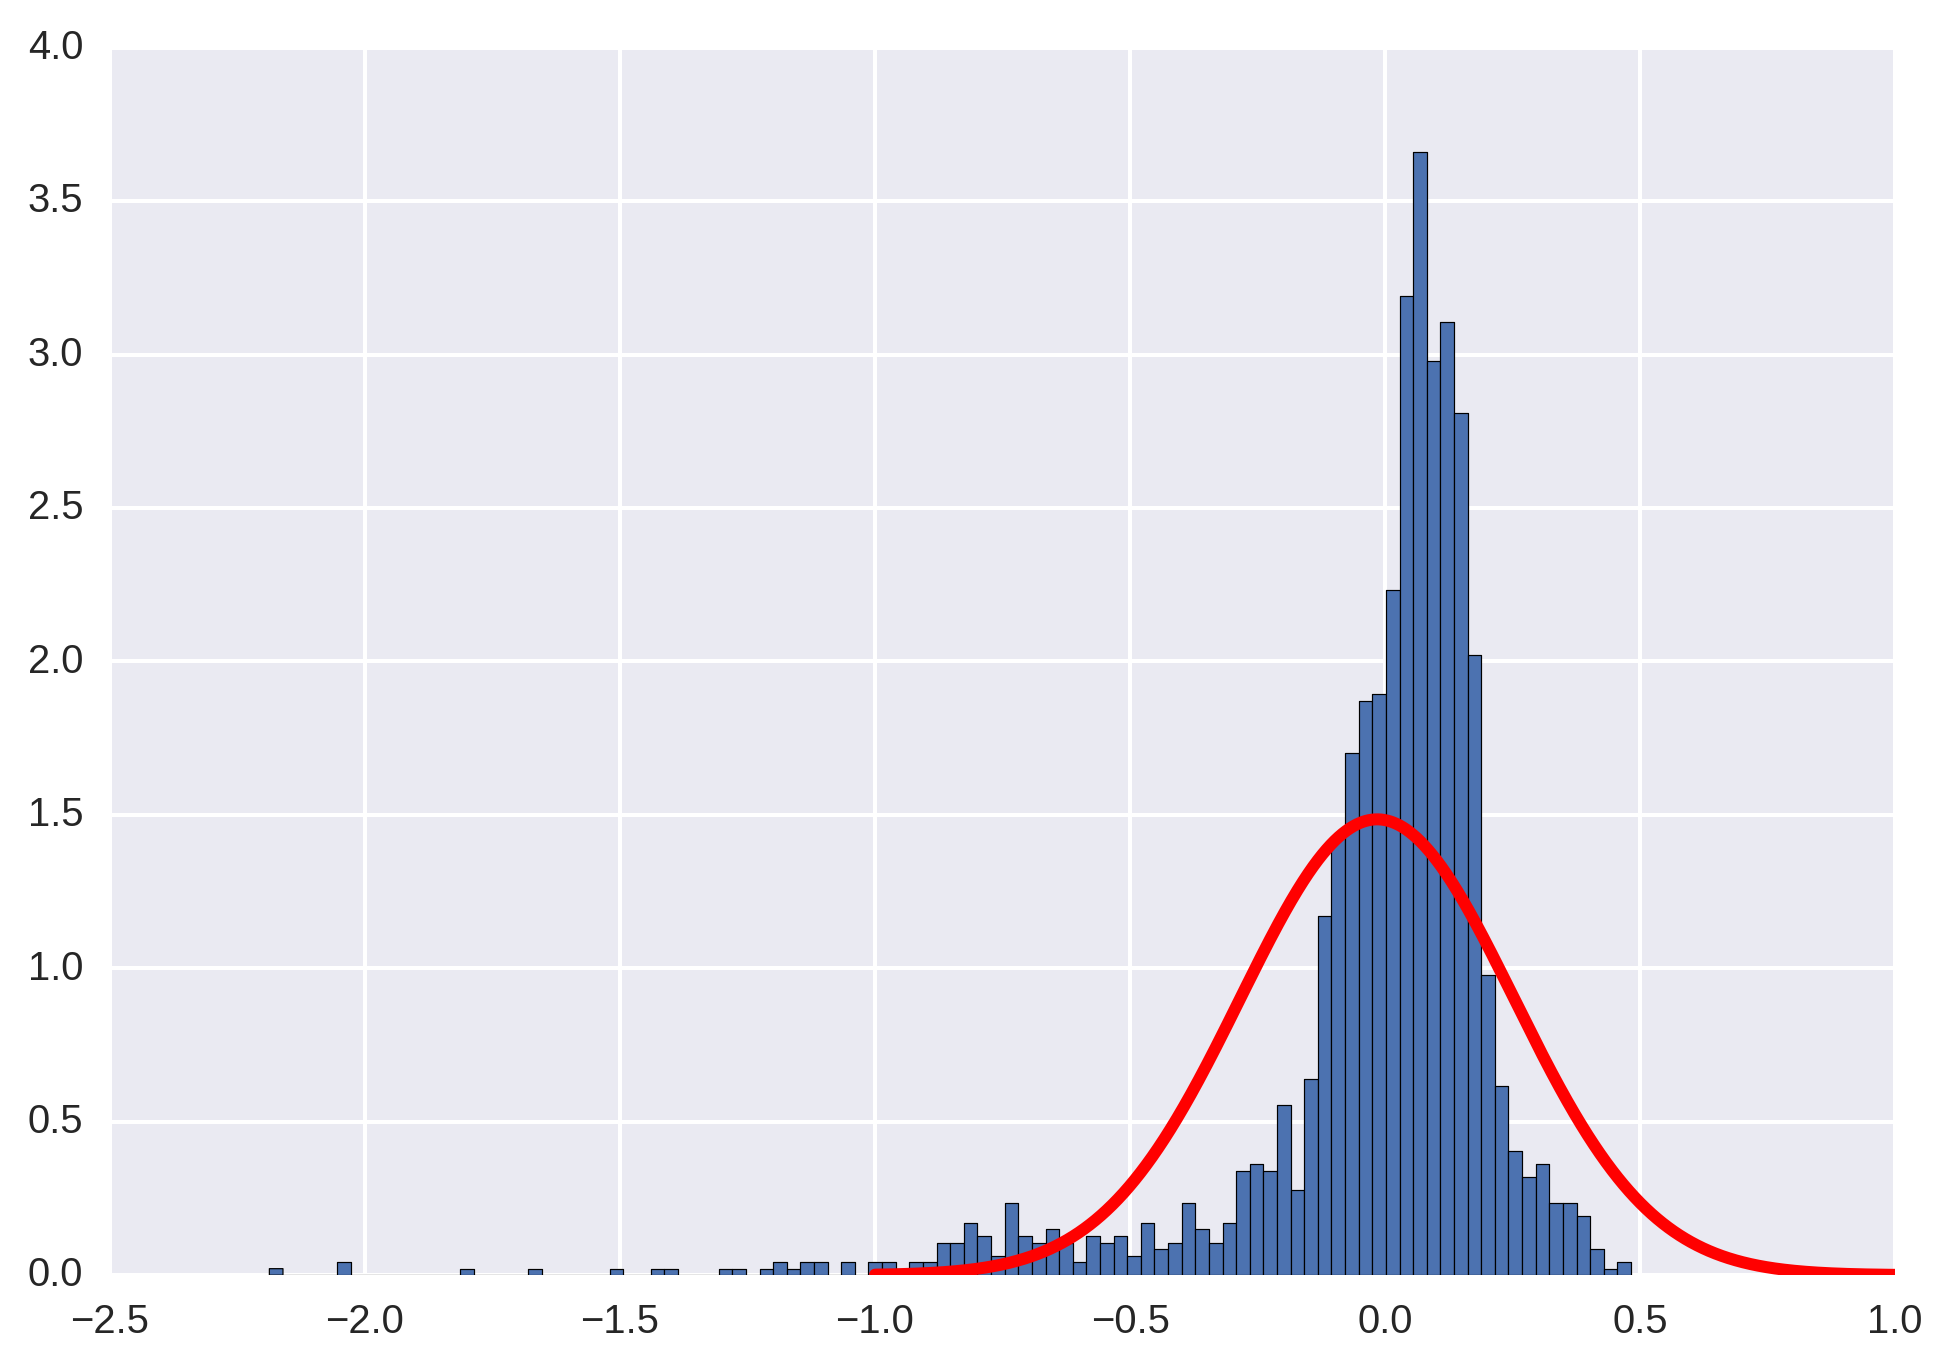

245.867365246


In [32]:
### Cross validation -- simple model

#Train/Test
train = oil[ (oil.index.year < CUT_YEAR) ]
test = oil[ (oil.index.year >= CUT_YEAR) ]

# Reporting function
def summarize_errors(test_me):
    error_pct = ((test_me['Actual'] - test_me['Model'])/test_me['Actual'])

    print error_pct.describe()
    error_pct.plot()
    plt.show()

    error_pct.hist(bins=100, normed=True)
    x = np.arange(-1, 1, 0.001)
    plt.plot(x, sp.stats.norm( loc=error_pct.mean(), scale=error_pct.std() ).pdf(x), linewidth=3, color='red')
    plt.show()

    print sklearn.metrics.mean_squared_error( test_me['Actual'], test_me['Model'] )

# Train the regression
def frame_to_feats(frame):
    feats = pd.DataFrame()
    
    feats['LEE'] = frame['Log_Error_Exponential']
    feats['LEE_1'] = frame['Log_Error_Exponential'].shift(1)
    feats['dLEE_avg'] = pd.rolling_mean( frame['Value'].diff(), window=3*PERIOD_MONTH)
    feats['vol_avg'] = pd.ewmvar(frame['Value'], span=3*PERIOD_MONTH)
    
    feats['Actual_LEE'] = frame['Log_Error_Exponential'].shift(-PREDICTION_LAG)
    return sm.add_constant(feats)

feats = frame_to_feats(train).dropna(how='any')
regress = sklearn.linear_model.LinearRegression().fit( 
        X=feats.drop('Actual_LEE', axis=1).values, 
        y=feats['Actual_LEE'].values)

# Predict

feats = frame_to_feats(test).dropna(how='any')
feats['Predicted_LEE'] = regress.predict( X=feats.drop('Actual_LEE', axis=1) )

test = feats.join(test, rsuffix='_r').dropna(how='any')
test['Simple_Model'] = np.exp ( test['Predicted_LEE']  ) * test['Exponential_Model']

# Report
test_me = test[['Actual', 'Simple_Model']].dropna(how='any')
test_me = test_me.rename(columns = {'Simple_Model' : 'Model'})
summarize_errors(test_me)

##Step 4: Adding external indicators (e.g., volatility, gdelt)

Once we have a  "simplest"  model as above, we can get to the interesting part:
At this point we like to find signal in additional data source that accounts for some of the error; to try to conceptually explain sources of error or skews in the distribution of error; etc.  Here are examples of other data sources we might try:

  - Other financial indicators (e.g., interest rates, volatilities, related commodities)
  - Non-financial indicators (e.g., weather, indicators for weather patterns / wars, geopolitical data like gdelt).
  
We'll show the example of trying to use equities volatility data (in the form of the VIX index) -- this will not help.

In [33]:
ng_fut = getQuandle( "CHRIS/CME_NG1" )
vix = getQuandle( "YAHOO/INDEX_VIX" )

oil['vix'] = vix['Adjusted Close']
oil['ng_fut'] = ng_fut['Settle']

No authentication tokens found: usage will be limited.
See www.quandl.com/api for more information.
Returning Dataframe for  CHRIS/CME_NG1
No authentication tokens found: usage will be limited.
See www.quandl.com/api for more information.
Returning Dataframe for  YAHOO/INDEX_VIX


-0.152874499373
0.437786836639


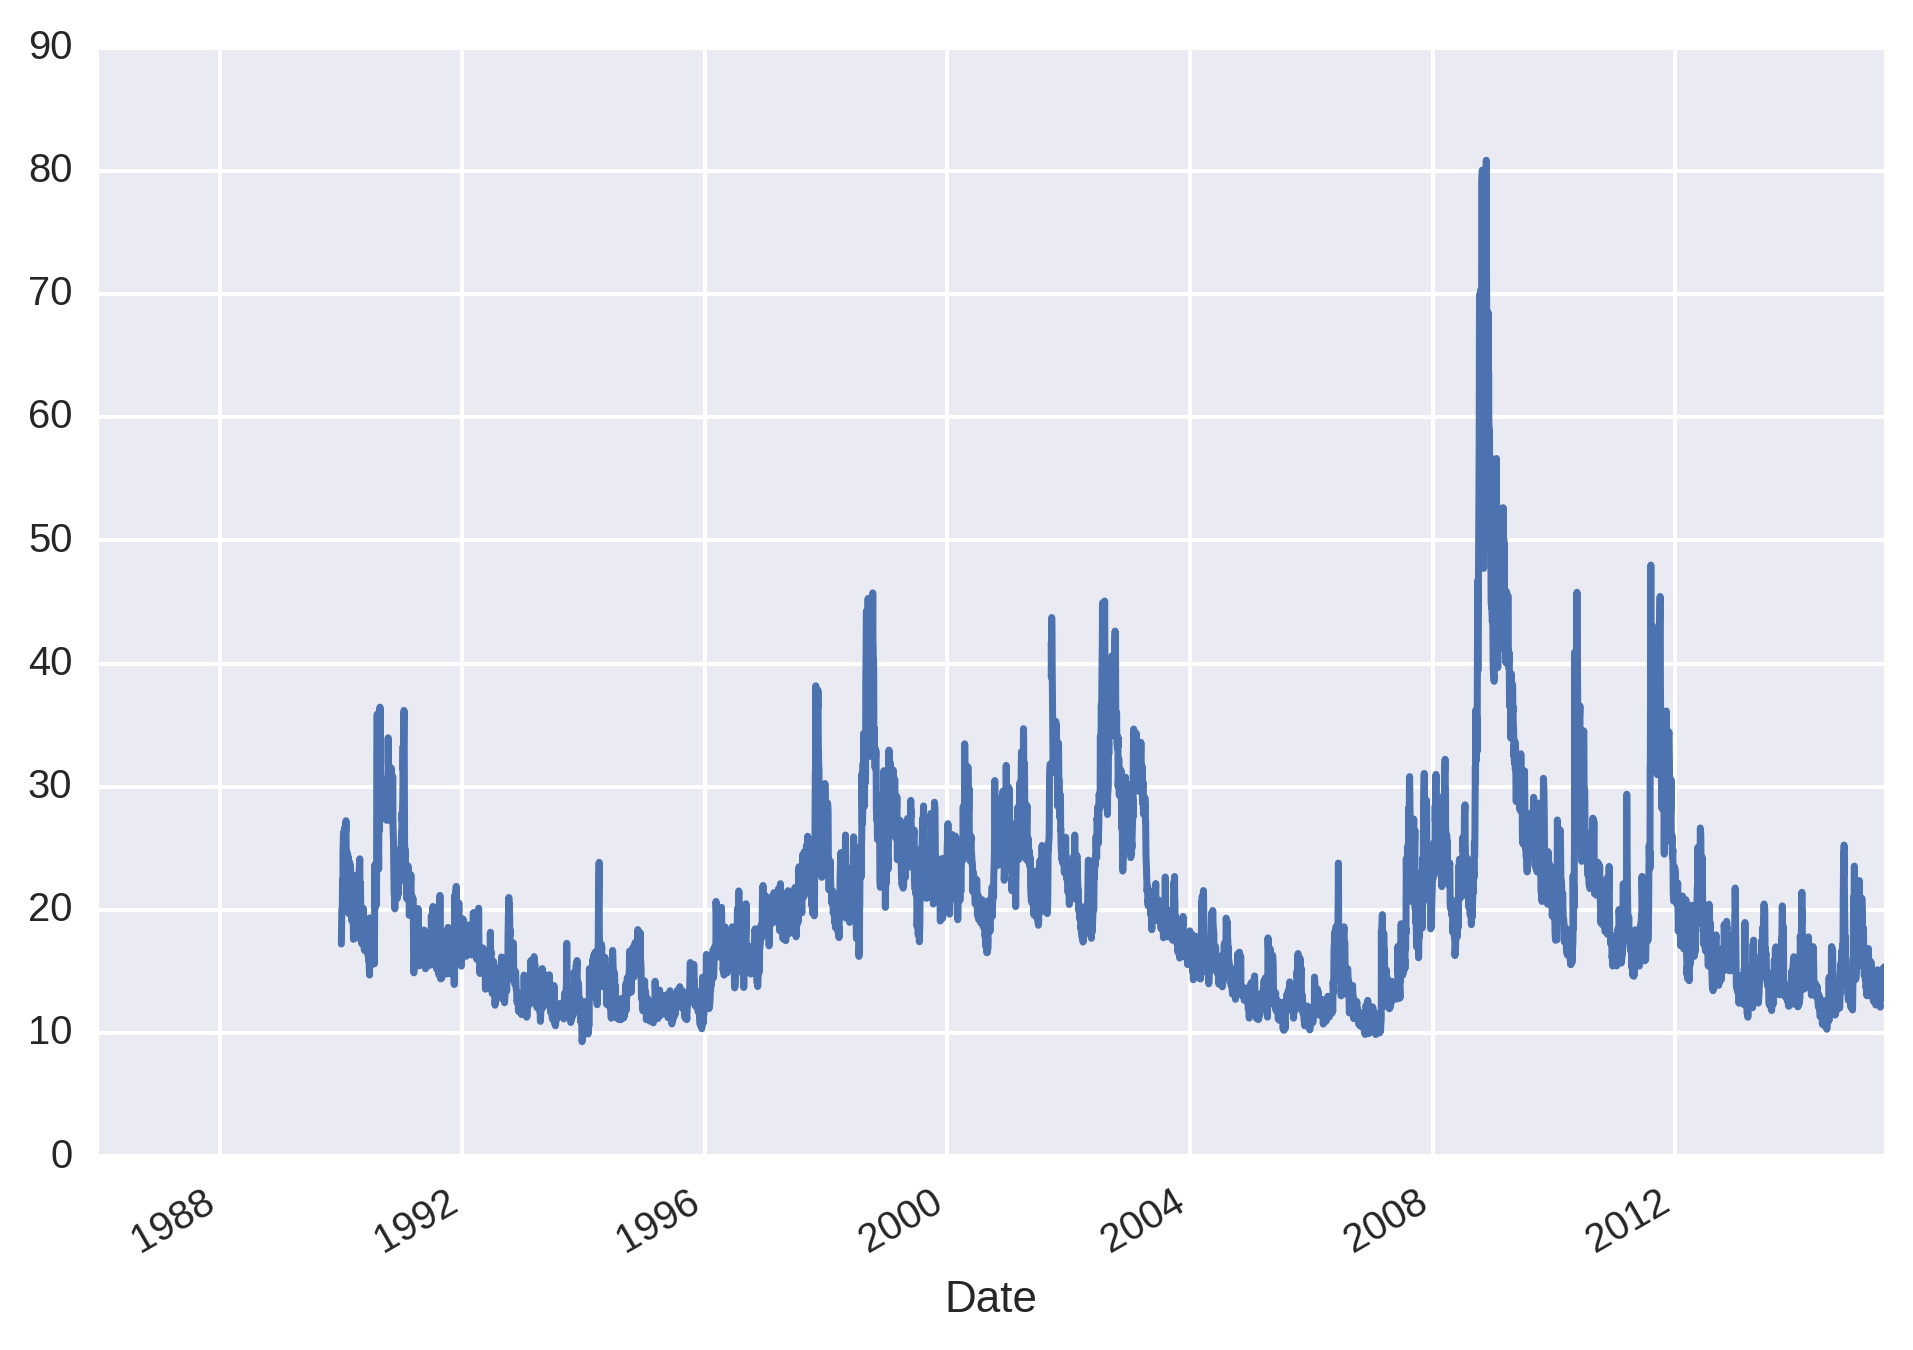

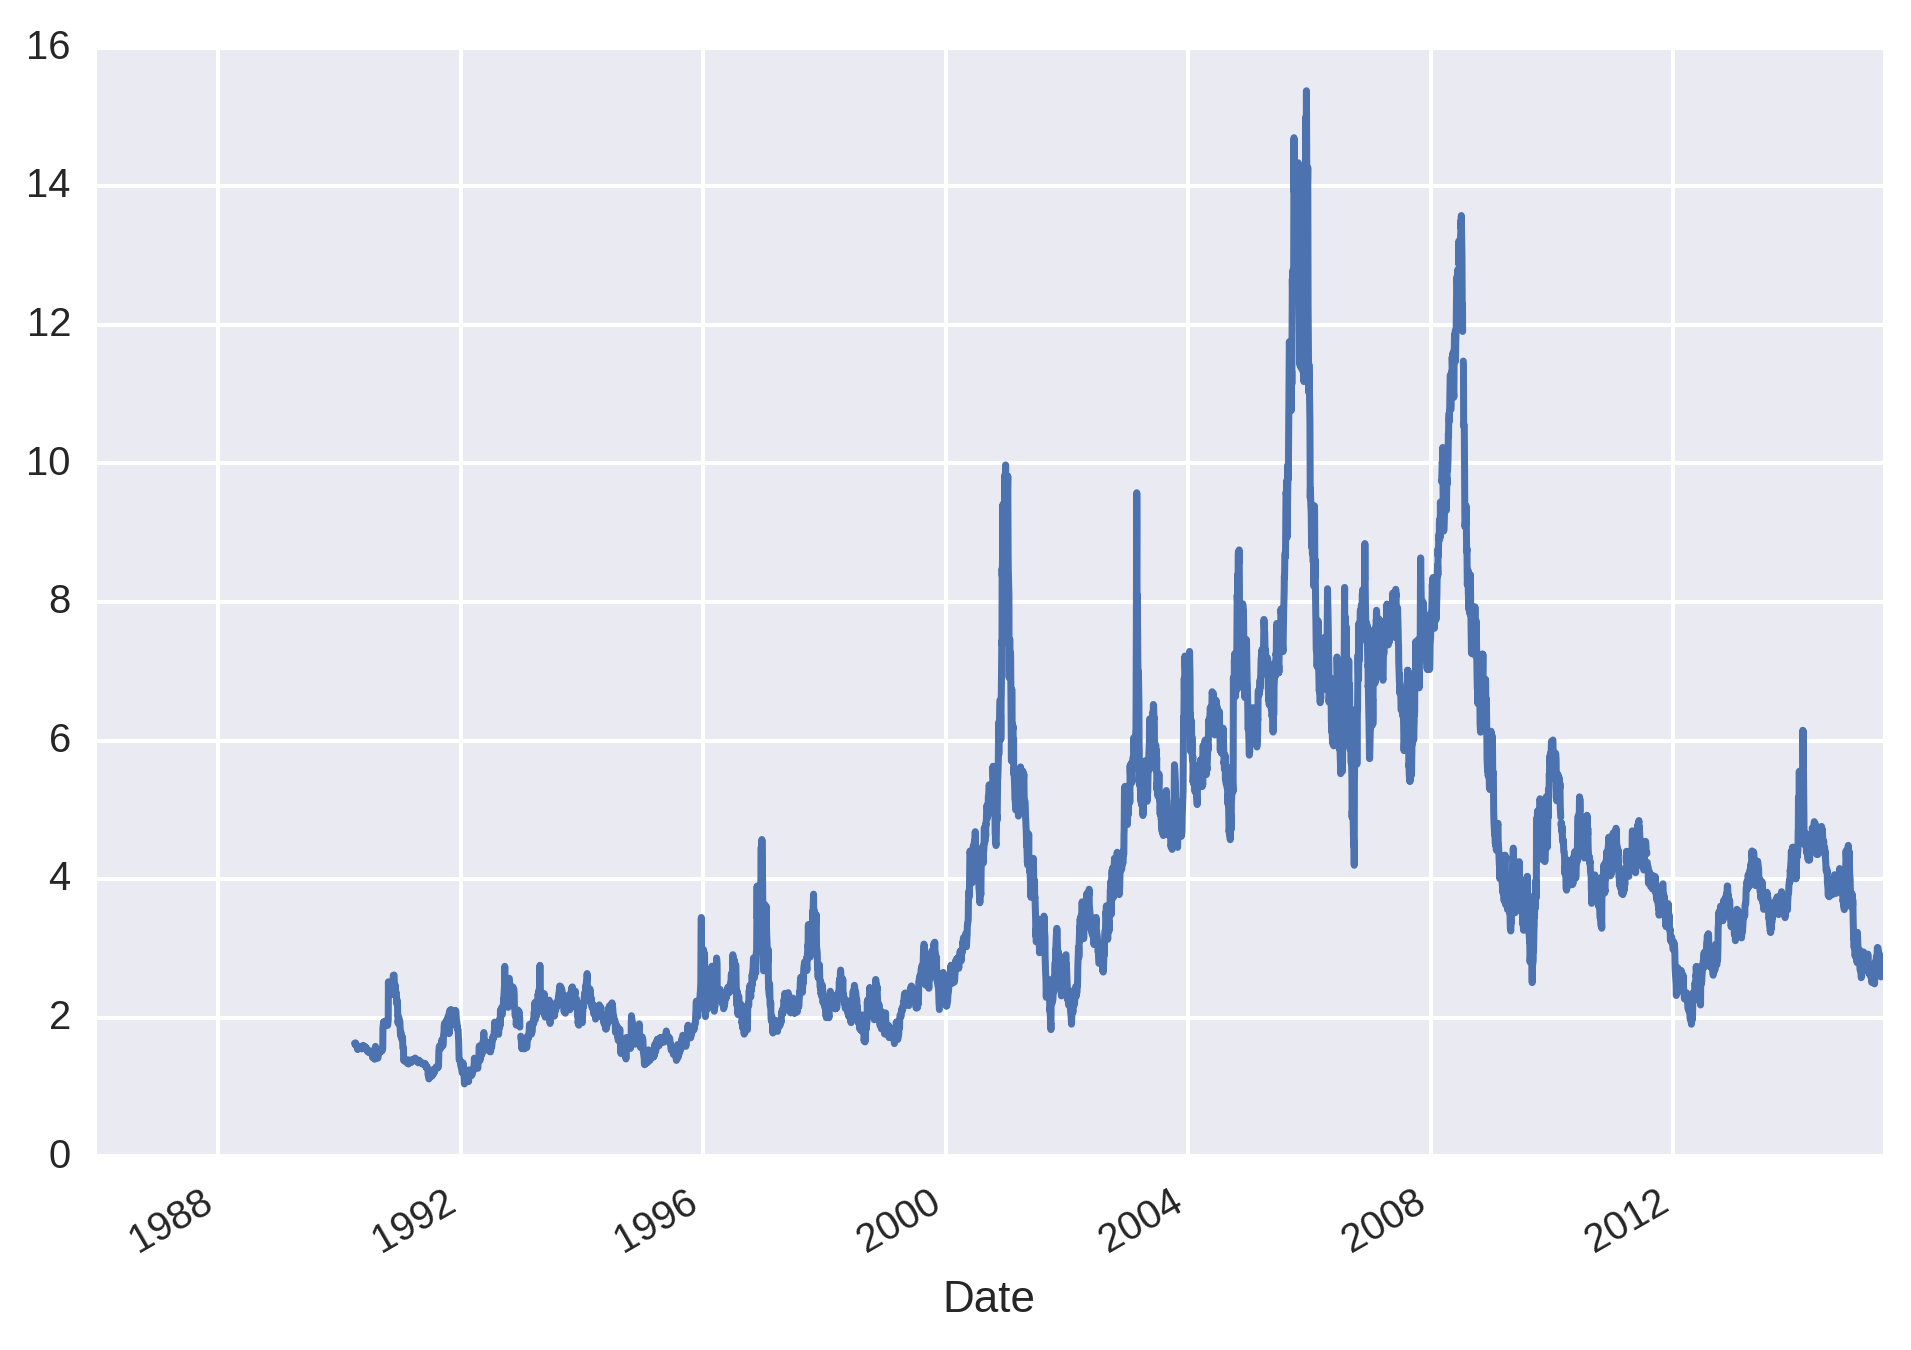

In [34]:
print oil['Log_Error_Exponential'].corr(oil['vix'])  # Our error term does correlate negatively with vix...
print oil['Log_Error_Exponential'].corr(oil['ng_fut'])

oil['vix'].plot()
plt.show()

oil['ng_fut'].plot()
plt.show()

count    1743.000000
mean        0.006584
std         0.267874
min        -2.117709
25%        -0.040263
50%         0.063505
75%         0.141657
max         0.561025
dtype: float64


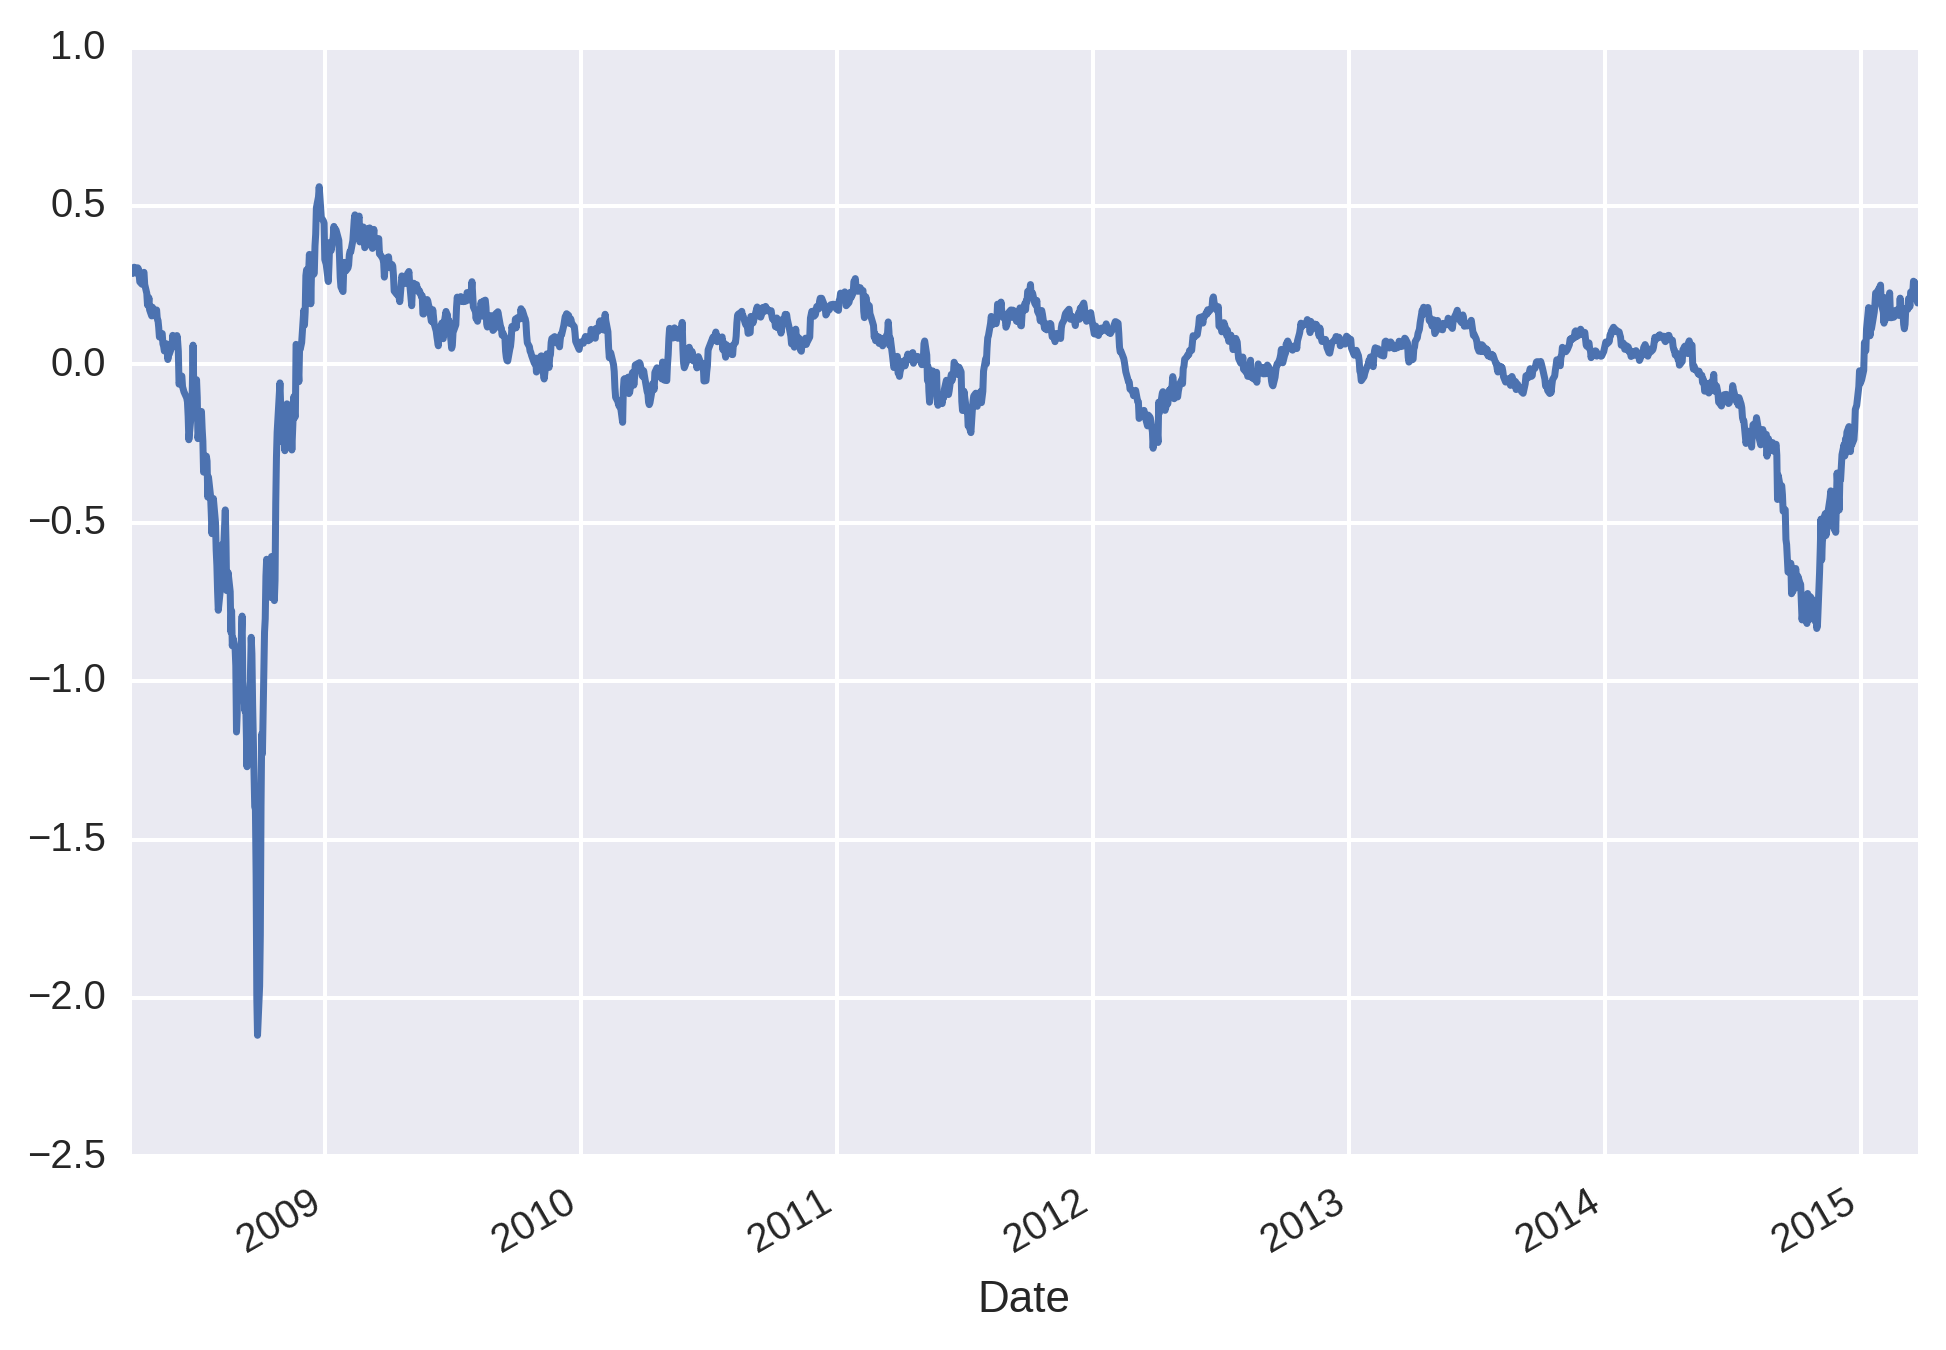

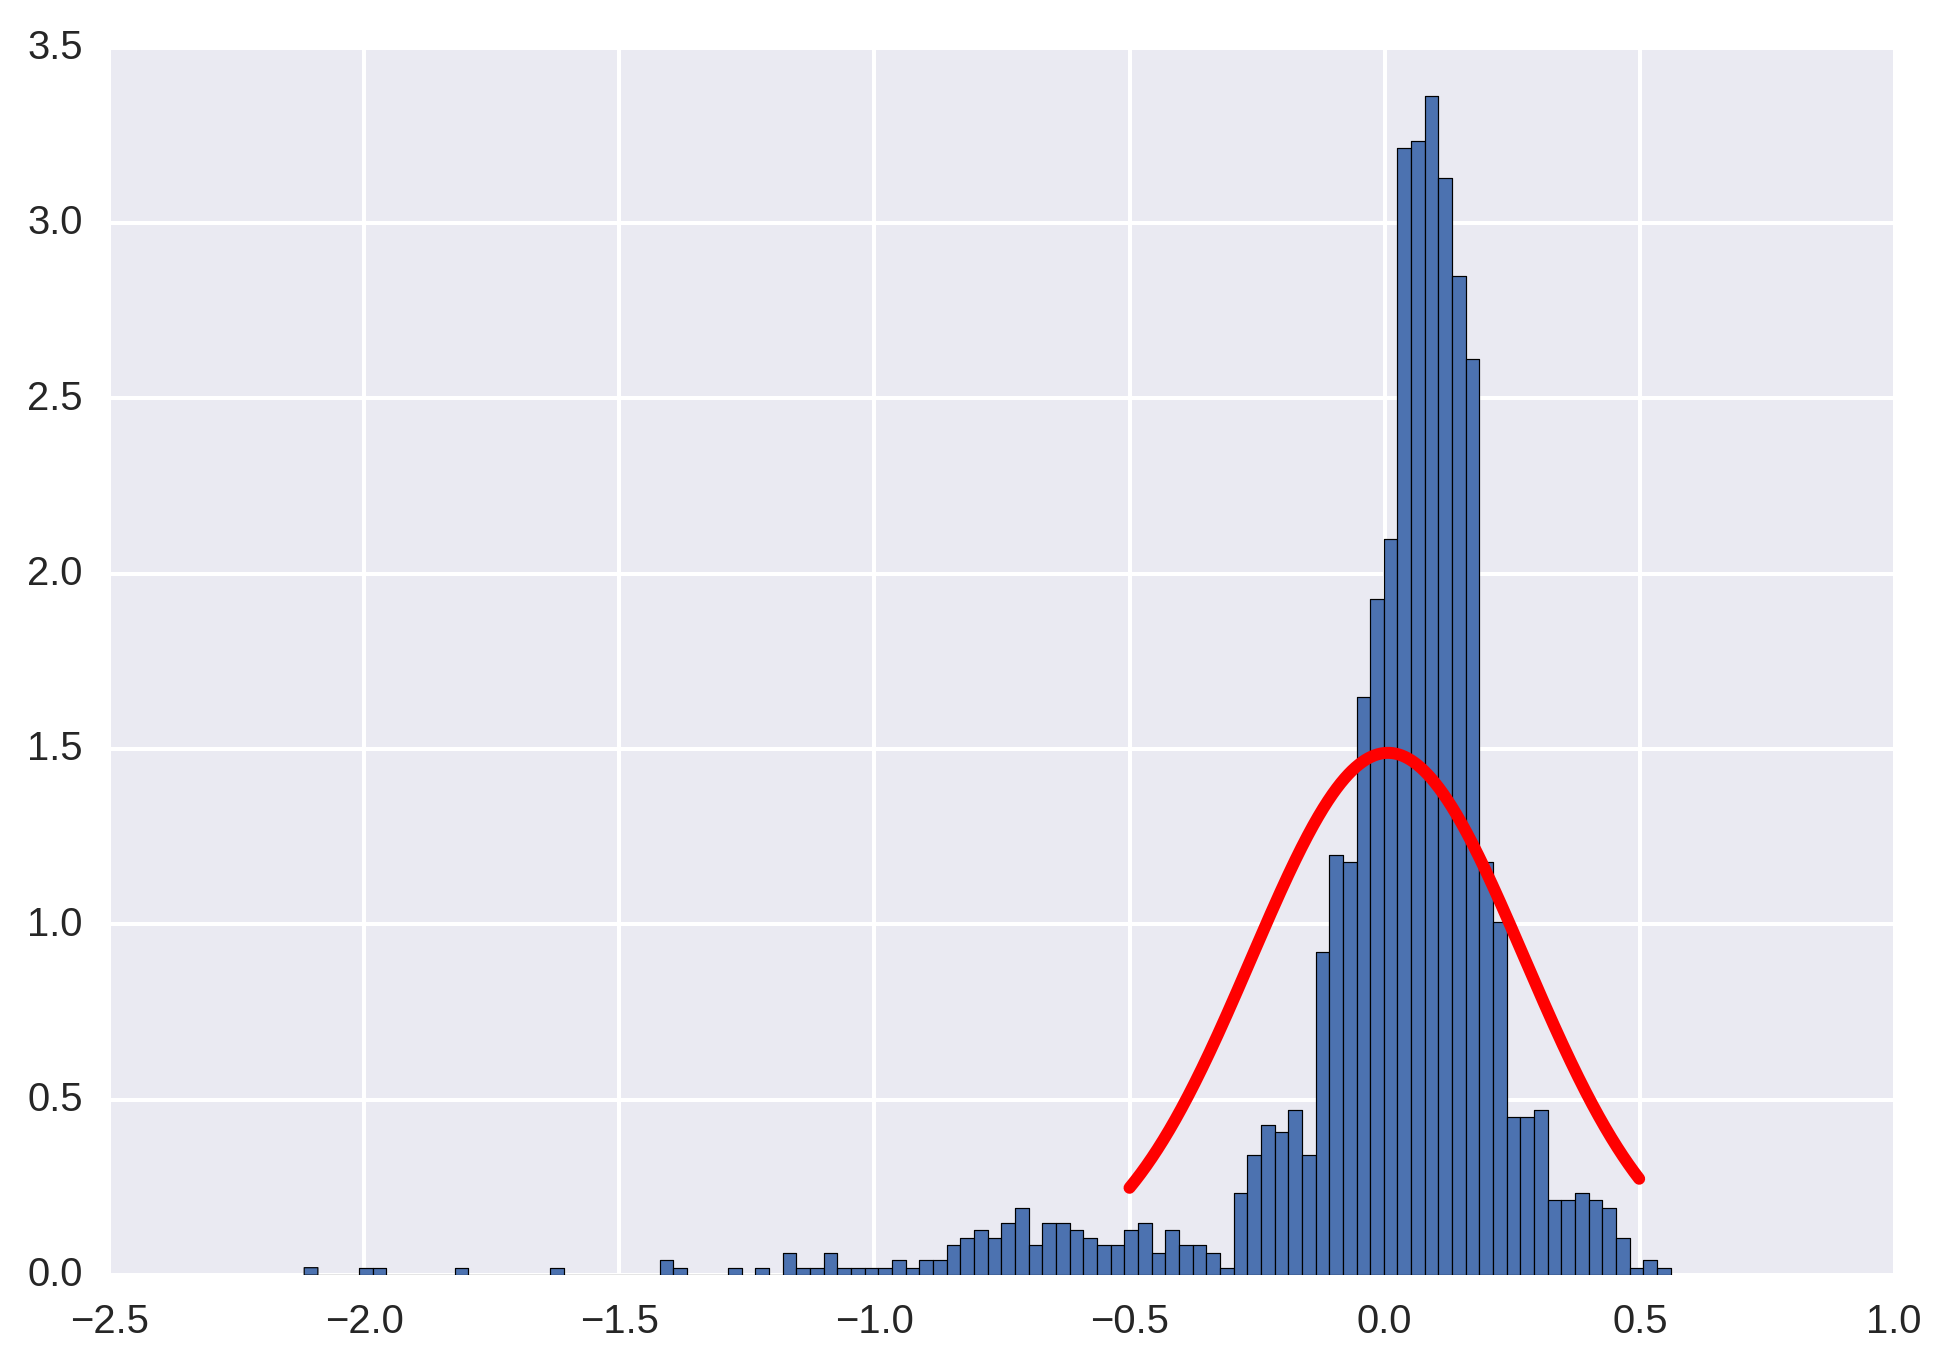

252.043779638


In [35]:
### Cross validation -- complex model -- notice that we have overfit!

#Train/Test
train = oil[ (oil.index.year < CUT_YEAR) ]
test = oil[ (oil.index.year >= CUT_YEAR) ]

# Reporting function
def summarize_errors(test_me):
    error_pct = ((test_me['Actual'] - test_me['Model'])/test_me['Actual'])

    print error_pct.describe()
    error_pct.plot()
    plt.show()

    error_pct.hist(bins=100, normed=True)
    x = np.arange(-0.5, 0.5, 0.001)
    plt.plot(x, sp.stats.norm( loc=error_pct.mean(), scale=error_pct.std() ).pdf(x), linewidth=3, color='red')
    plt.show()

    print sklearn.metrics.mean_squared_error( test_me['Actual'], test_me['Model'] )

# Train the regression
def frame_to_feats(frame):
    feats = pd.DataFrame()
    
    feats['LEE'] = frame['Log_Error_Exponential']
    feats['dLEE_avg'] = pd.rolling_mean( frame['Value'].diff(), window=3*PERIOD_MONTH)
    feats['vol_avg'] = pd.ewmvar(frame['Value'], span=3*PERIOD_MONTH)
    
   # feats['vix'] = frame['vix']
    feats['ng_fut'] = frame['ng_fut']
    
    feats['Actual_LEE'] = frame['Log_Error_Exponential'].shift(-PREDICTION_LAG)
    return sm.add_constant(feats)
    

feats = frame_to_feats(train).dropna(how='any')
regress = sklearn.linear_model.LinearRegression().fit( 
        X=feats.drop('Actual_LEE', axis=1), 
        y=feats['Actual_LEE'])

# Predict

feats = frame_to_feats(test).dropna(how='any')
feats['Predicted_LEE'] = regress.predict( feats.drop('Actual_LEE', axis=1) )

test = feats.join(test, rsuffix='_r').dropna(how='any')
test['Complex_Model'] = np.exp ( test['Predicted_LEE']  ) * test['Exponential_Model']

# Report
test_me = test[['Actual', 'Complex_Model']].dropna(how='any')
test_me = test_me.rename(columns = {'Complex_Model' : 'Model'})
summarize_errors(test_me)


### Open-ended brainstorming / exercises

1. What happens to the results above if we change our "cut point" to say 2010?  What's the moral of this story...

2. Play around with the previous "Complex" model, and see if you can improve it.  What happens, for instance, if you get rid of the 'vix' signal.  Why do you think this might be the case?

3. What are some other "simplest" models we could have tried? e .g., linear regression just on 'Value' rather than going through this log stuff.  Try some of them -- how do they perform?

4. Carry out the whole analysis process for the Pittsburg temperate data (see below for some steps.. if you do use that, mark it up to explain what's happening).

##Fancier topic: Stochastic auto-regressive models

Our time series has, very cleary, time-varying volatility.  To accurately model these effects, one often uses stochastic models.  To start you Googling, the basic auto-regressive examples are **ARCH/GARCH**.  

Let us say just a little about these, leaving an example as an exercise to the reader.  In this type of model, the next time tick's value is drawn from a _distribution_ whose mean **and** standard deviation are modelled over time (and can, in general, be auto-regressive):

$$ t_{i+1} = M(\text{..factors..}) + \sigma(\text{..factors..}) \epsilon_t $$

where 
  - $M$ is some model for the mean (e.g., a linear model depending on some number of time lags of $t_{i}$ and moving averages in GARCH models);
  - $\sigma$ is some model for the standard deviation (as above in GARCH);
  - and, $\epsilon_t$ is a draw from a distribution having (conditional on the factors..) mean equal to zero, and standard deviation equal to one.  (In ARCH, this is a normal distribution.)
  
Stochastic models allow us to generate a range of future paths, for instance for modelling "value at risk."

## A more positive example: Temperatures

In [36]:
temps_df = pd.read_csv("../projects/timeseries-project/data/raw/temperatures.csv", index_col=0, names=["Temperature"], parse_dates=True)

In [37]:
ts = temps_df['Temperature'].asfreq('60Min', method='ffill')
temps_df['Temperature'] = ts

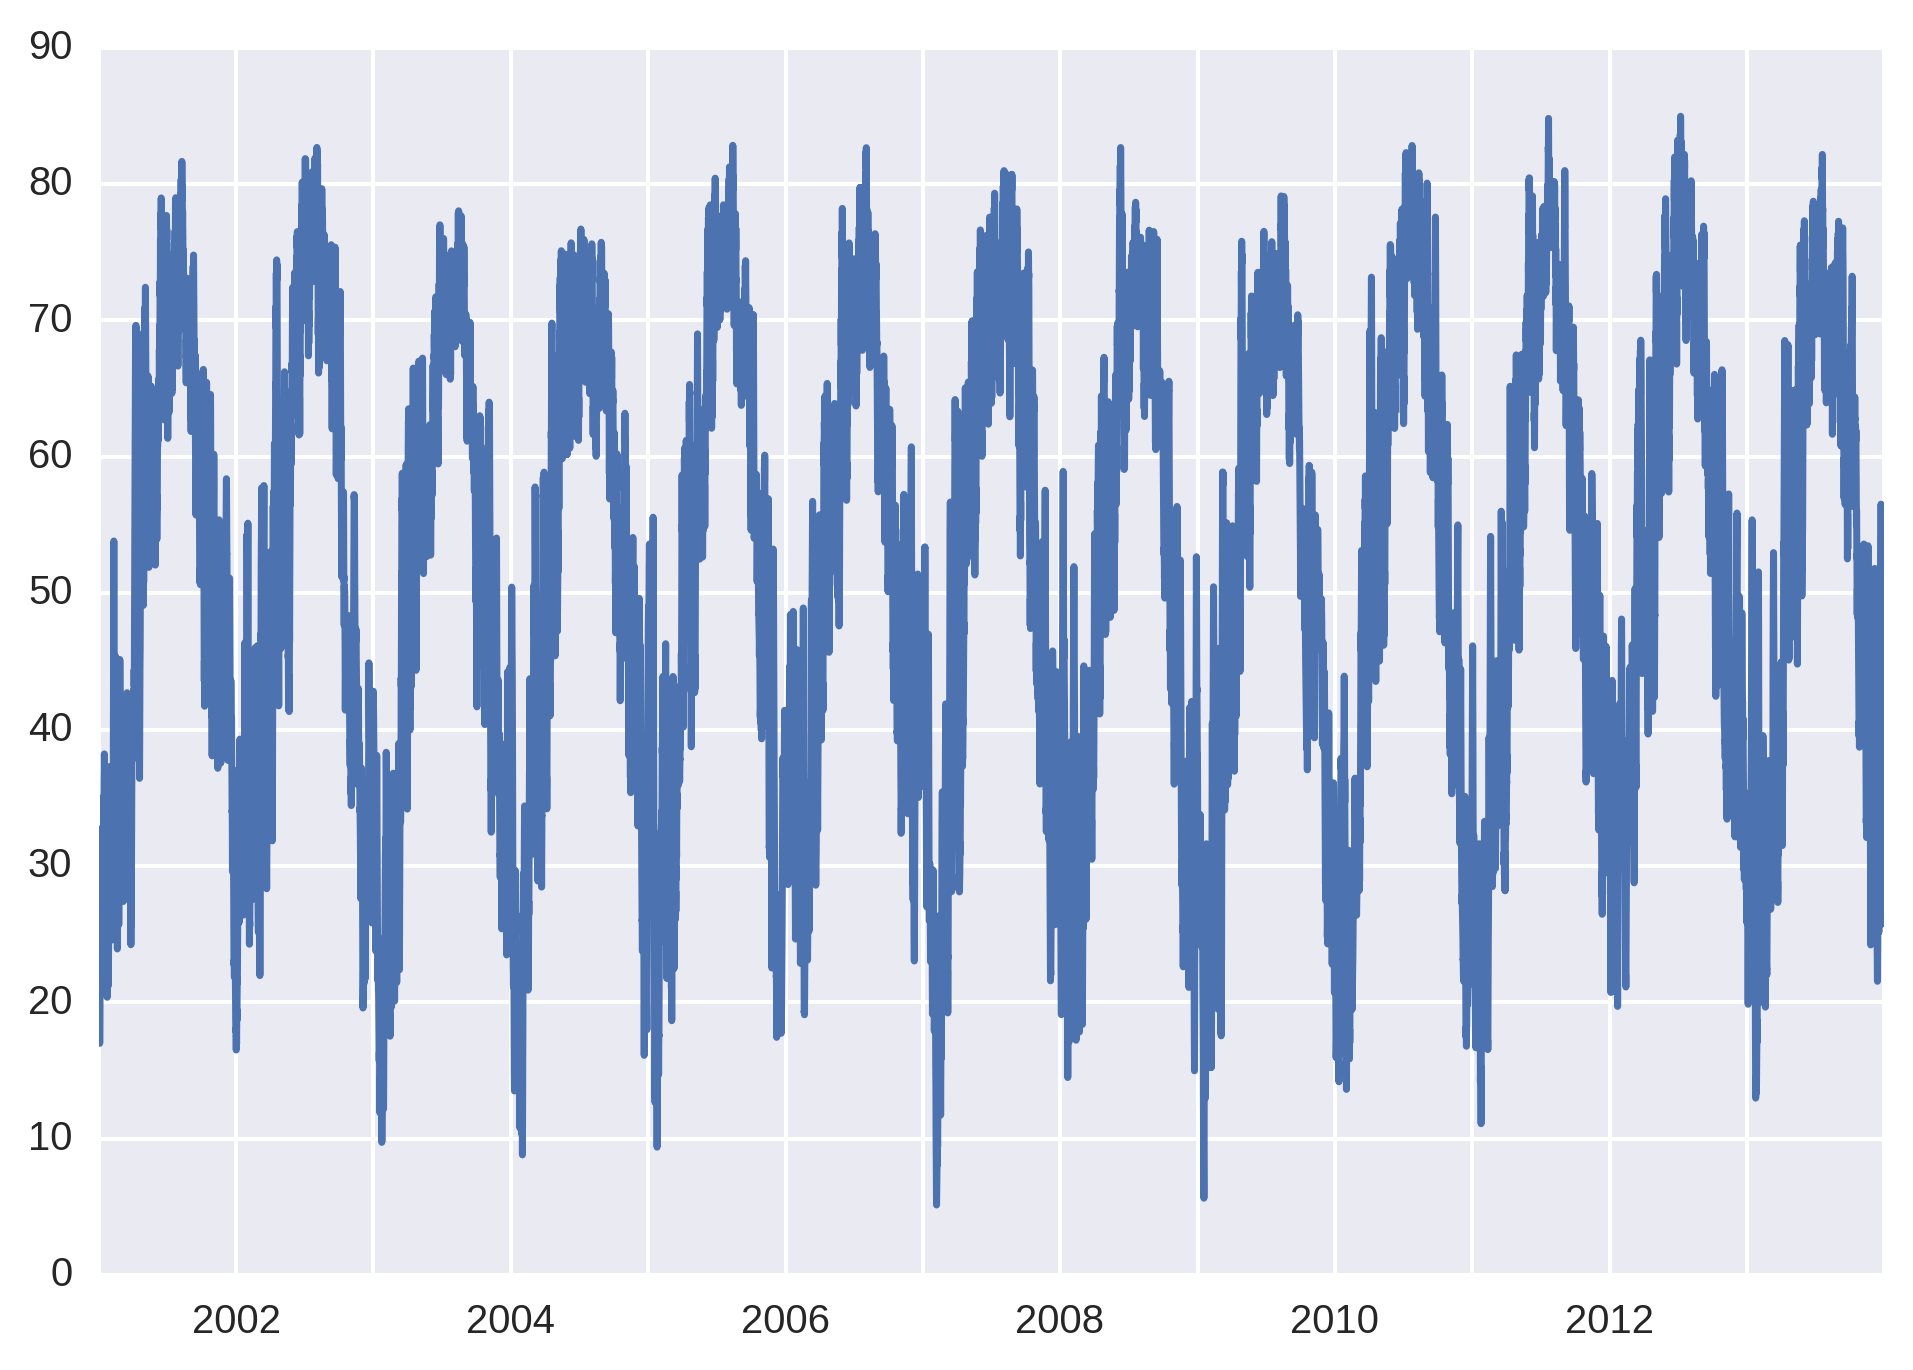

In [38]:
# 2-month exponential moving average
pd.ewma(ts, span=2*30).plot()

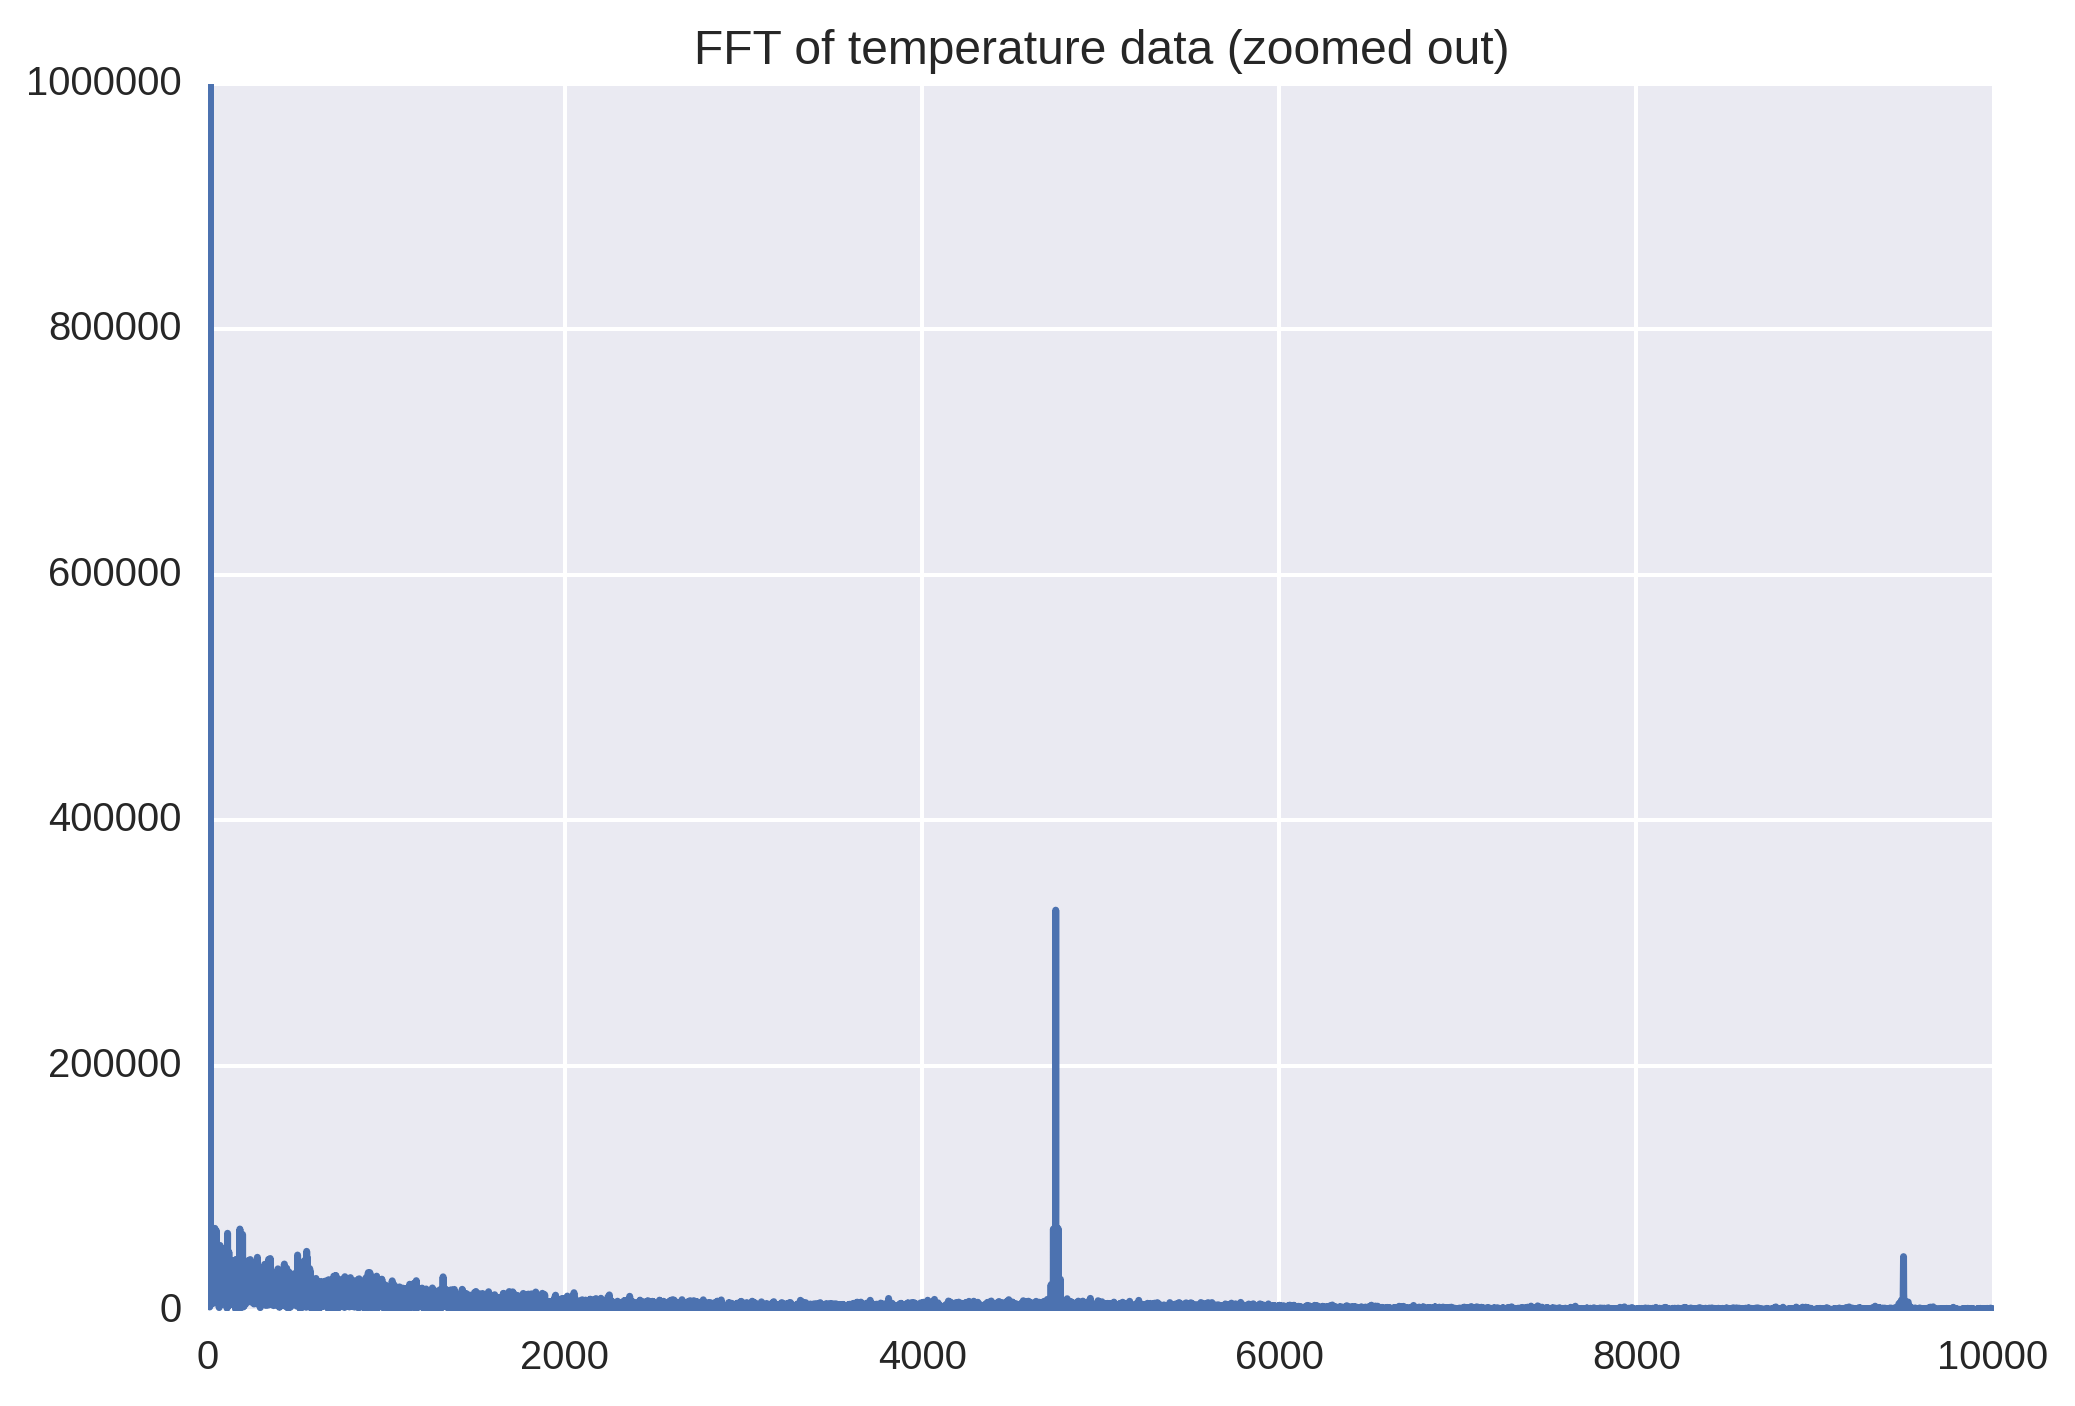

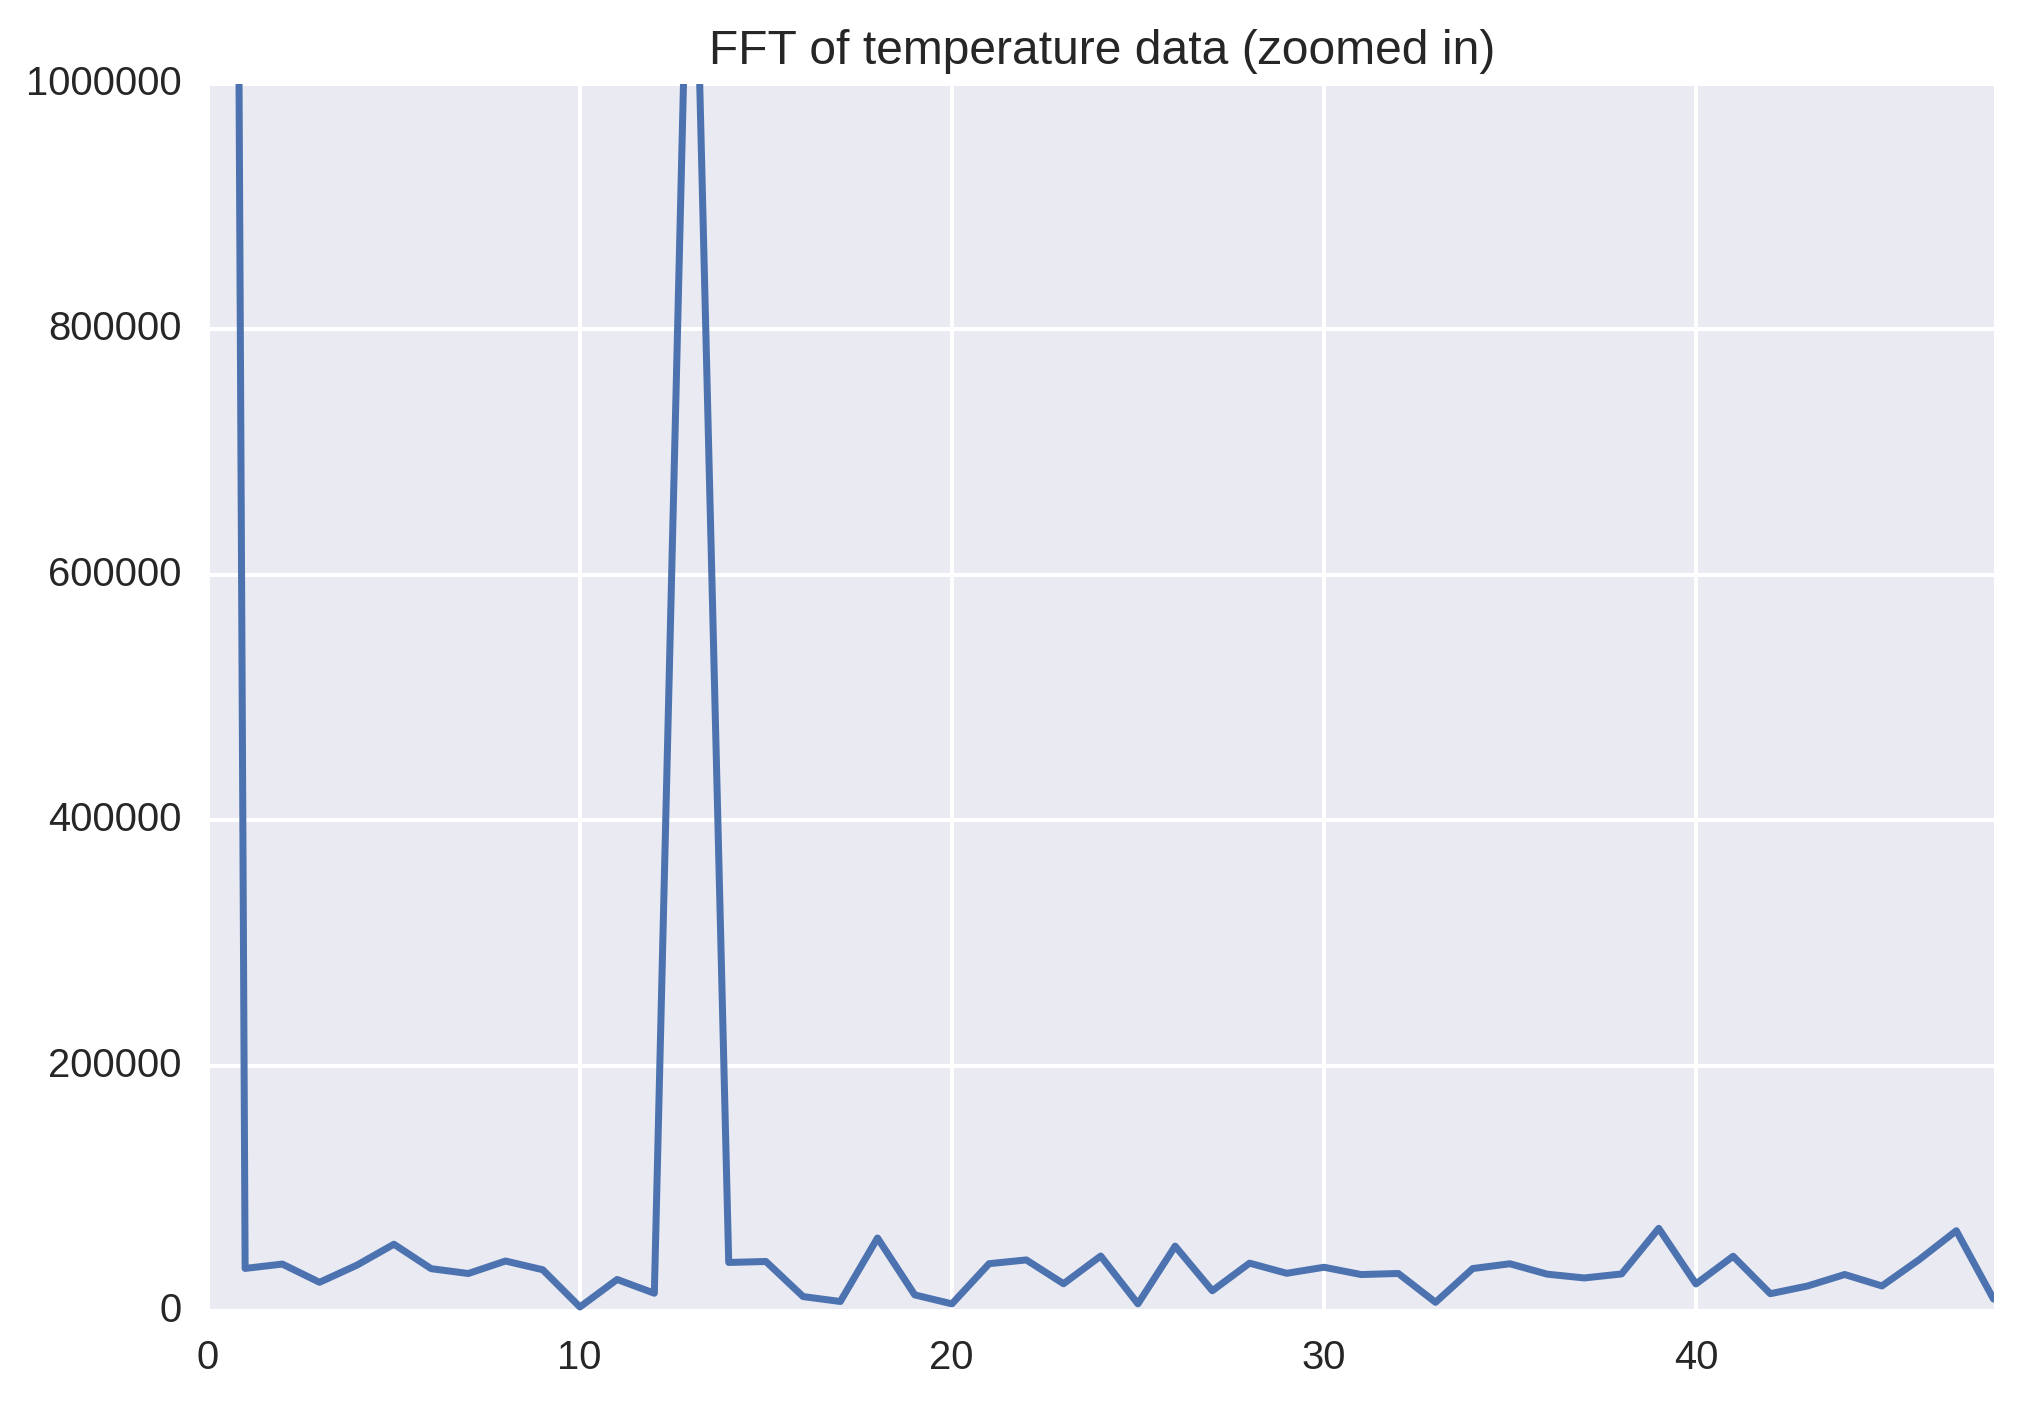

In [39]:
fft = np.fft.fft( ts )
plt.plot(np.abs( fft ) )
plt.title("FFT of temperature data (zoomed out)")
pylab.ylim([0,1000000])
pylab.xlim([0,10000])
plt.show()

plt.plot(np.abs( fft ) )
plt.title("FFT of temperature data (zoomed in)")
pylab.ylim([0,1000000])
pylab.xlim([0,24*2])
plt.show()



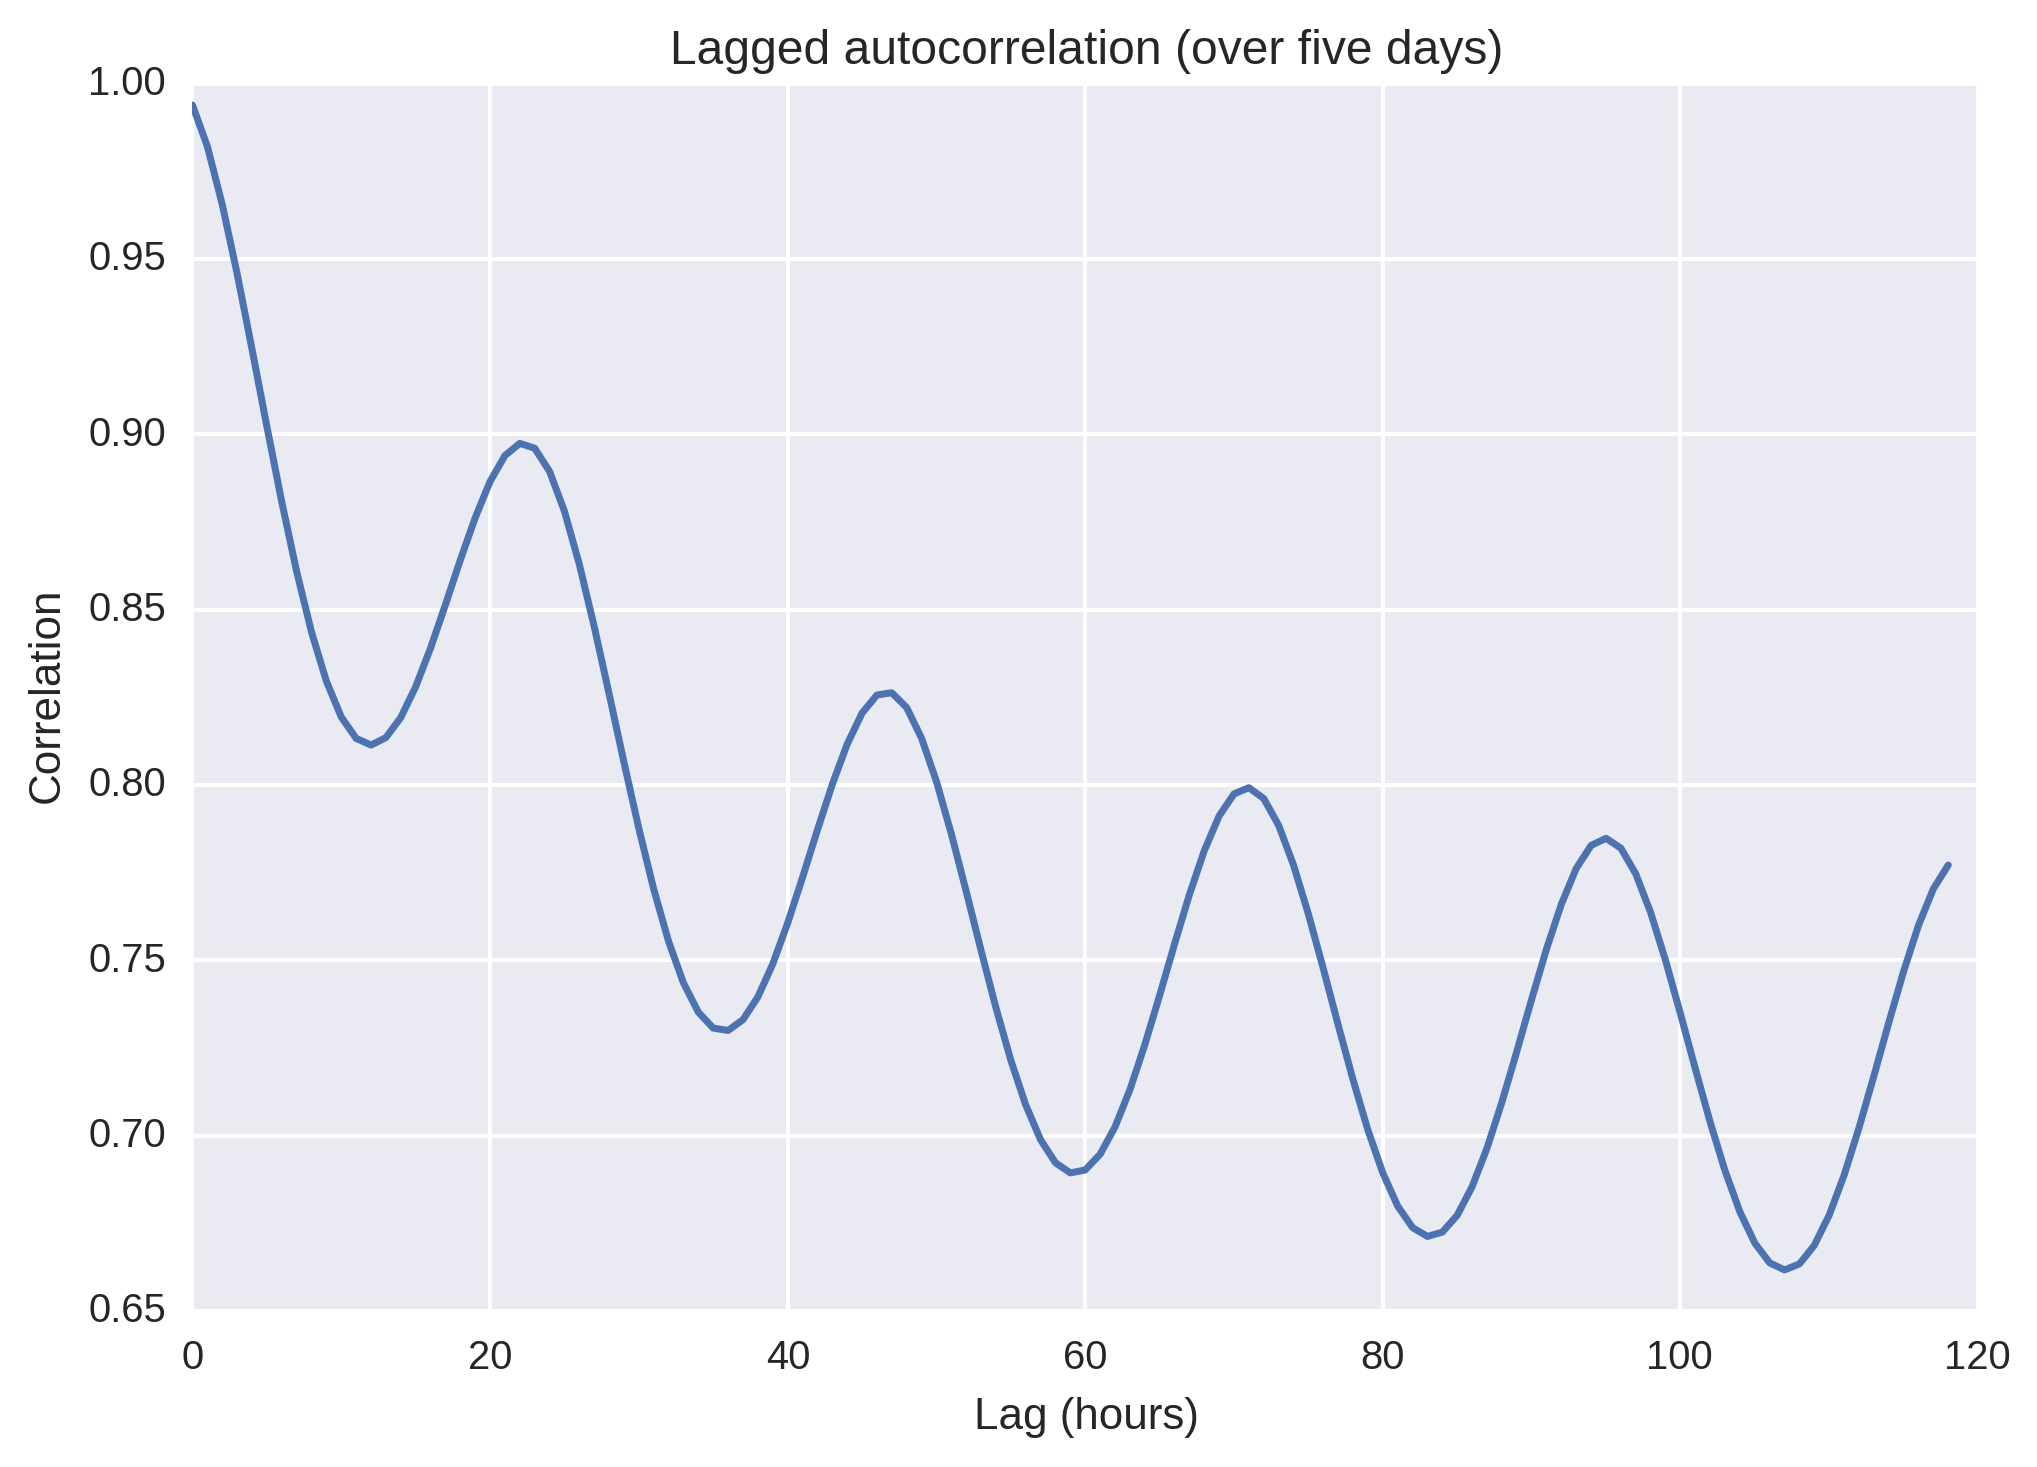

In [40]:
plt.plot( np.array( [ ts.corr( ts.tshift(i) ) for i in range(1,24*5,1) ] ) )
plt.title("Lagged autocorrelation (over five days)")
plt.ylabel("Correlation")
plt.xlabel("Lag (hours)")

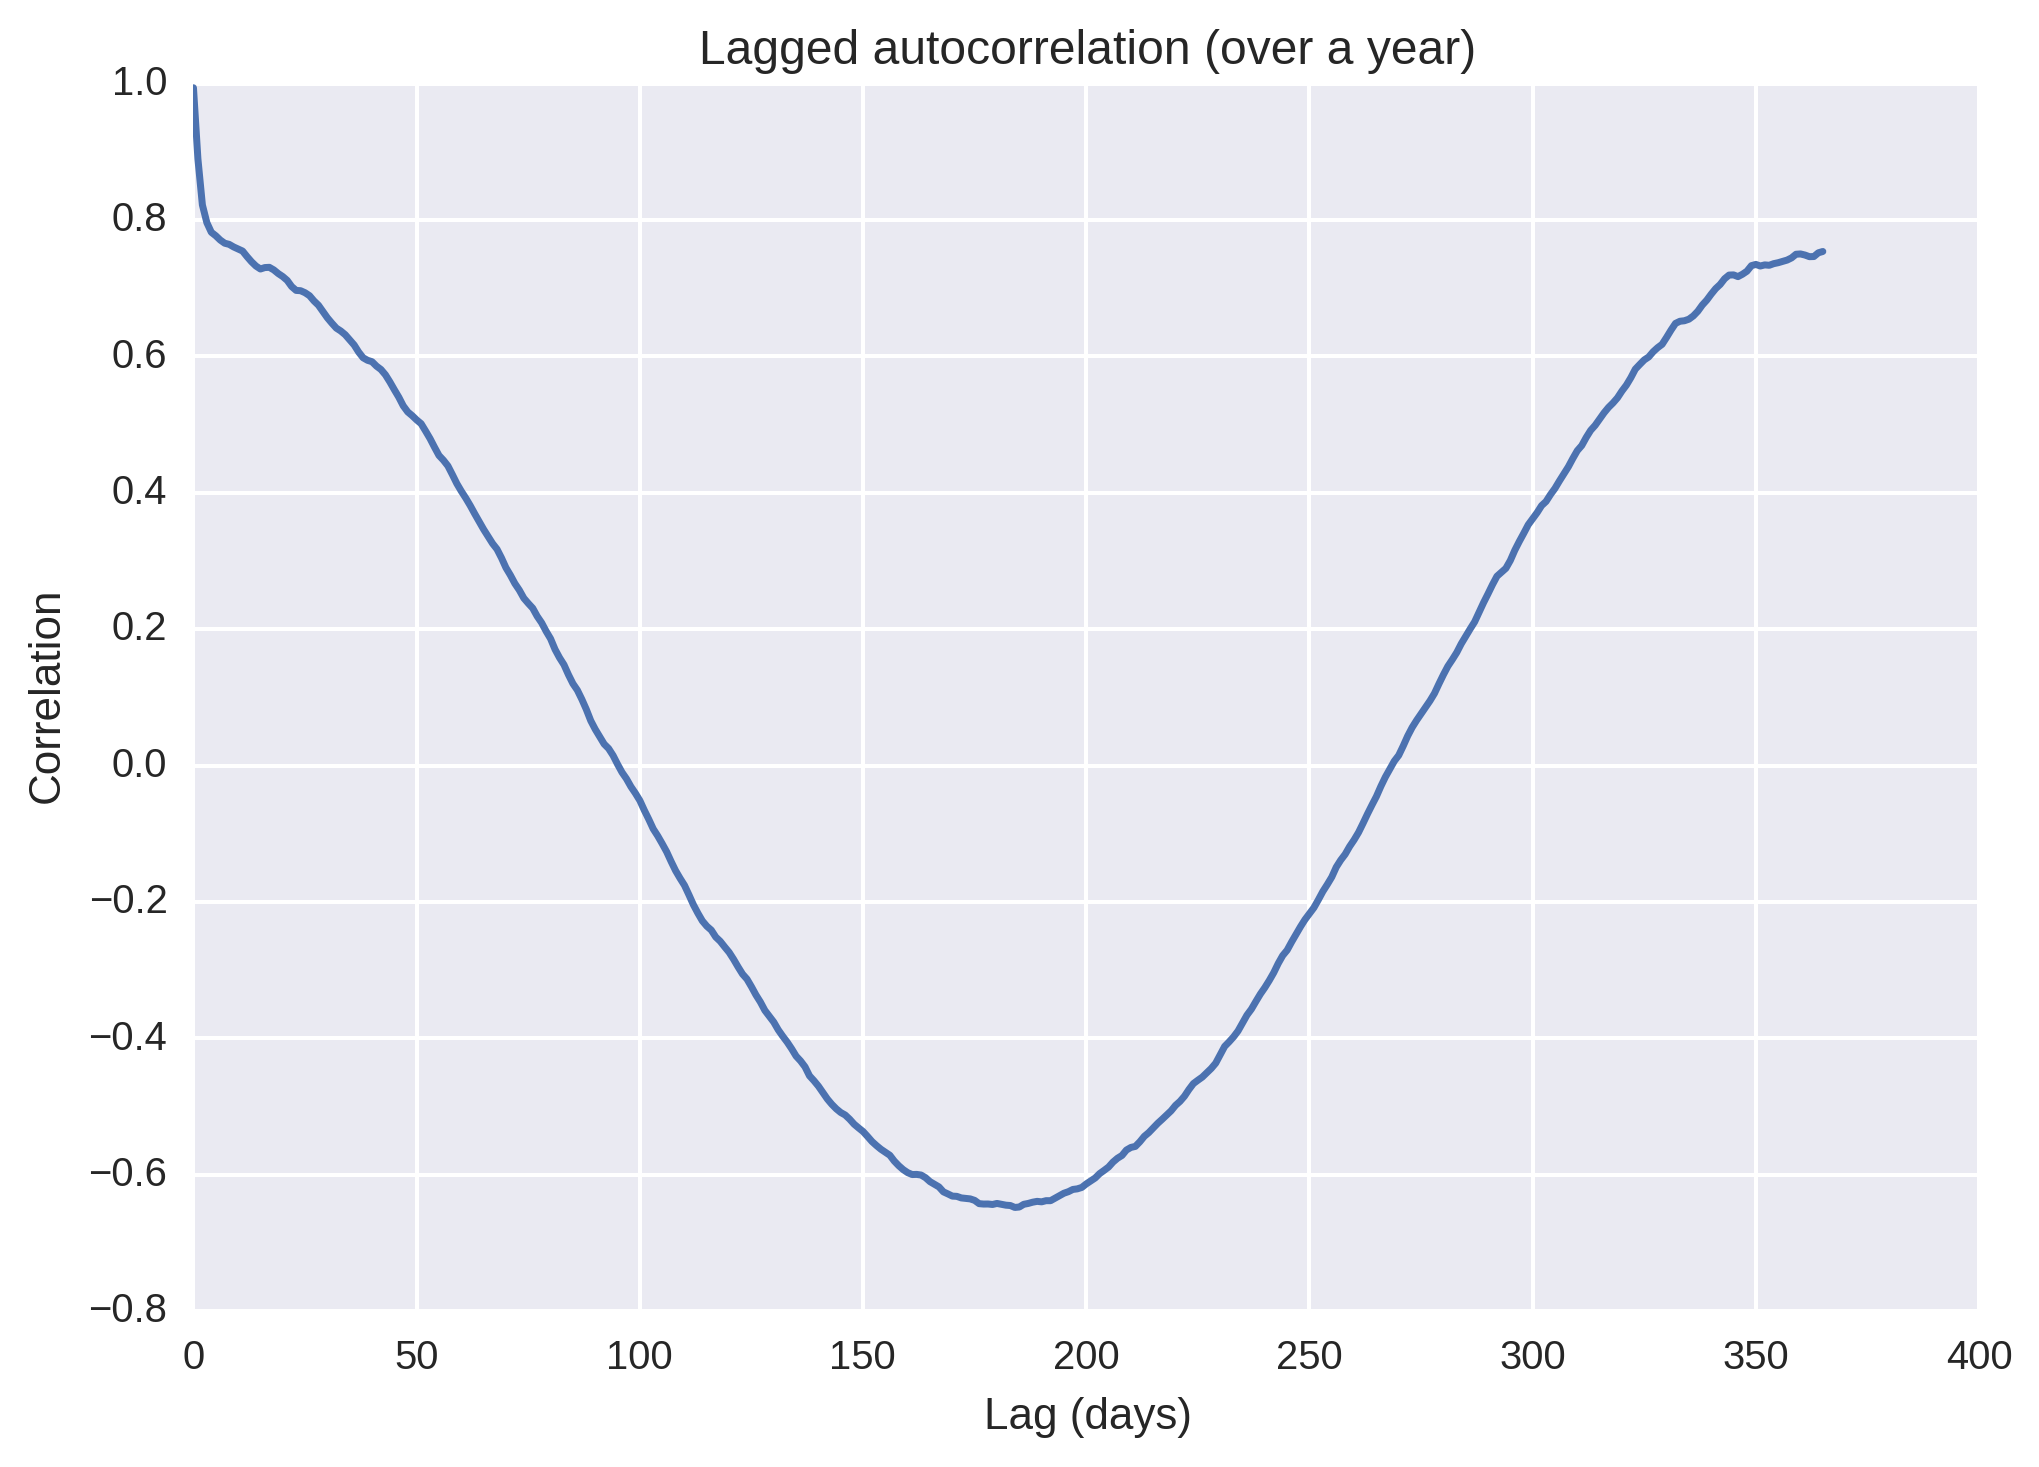

In [41]:
plt.plot( np.array( [ ts.corr( ts.tshift(i) ) for i in range(1,8766,24) ] ) )
plt.title("Lagged autocorrelation (over a year)")
plt.ylabel("Correlation")
plt.xlabel("Lag (days)")


We can always decompose
$$F(t) = k \cos(\omega (t - t_0)) = k \left[\alpha \cos(\omega t) + \beta \sin(\omega t) \right]$$
where $\alpha^2 + \beta^2 = 1$

The columns below are all features which may or may not be useful for modeling.

In [42]:
temps_df['Julian'] = temps_df.index.to_julian_date()
temps_df['const'] = 1
temps_df['sin(year)'] = np.sin(temps_df['Julian']/365.25 * 2*np.pi)
temps_df['cos(year)'] = np.cos(temps_df['Julian']/365.25 * 2*np.pi)
temps_df['sin(6mo)'] = np.sin(temps_df['Julian']/(365.25/2) * 2*np.pi)
temps_df['cos(6mo)'] = np.cos(temps_df['Julian']/(365.25/2) * 2*np.pi)
temps_df['sin(day)'] = np.sin(temps_df.index.hour/24.0 * 2*np.pi)
temps_df['cos(day)'] = np.cos(temps_df.index.hour/24.0 * 2*np.pi)
temps_df['Day_Average'] = pd.ewma(temps_df['Temperature'], span=24)

temps_df['Goal'] = temps_df['Temperature'].shift(-24)


73.5538144493


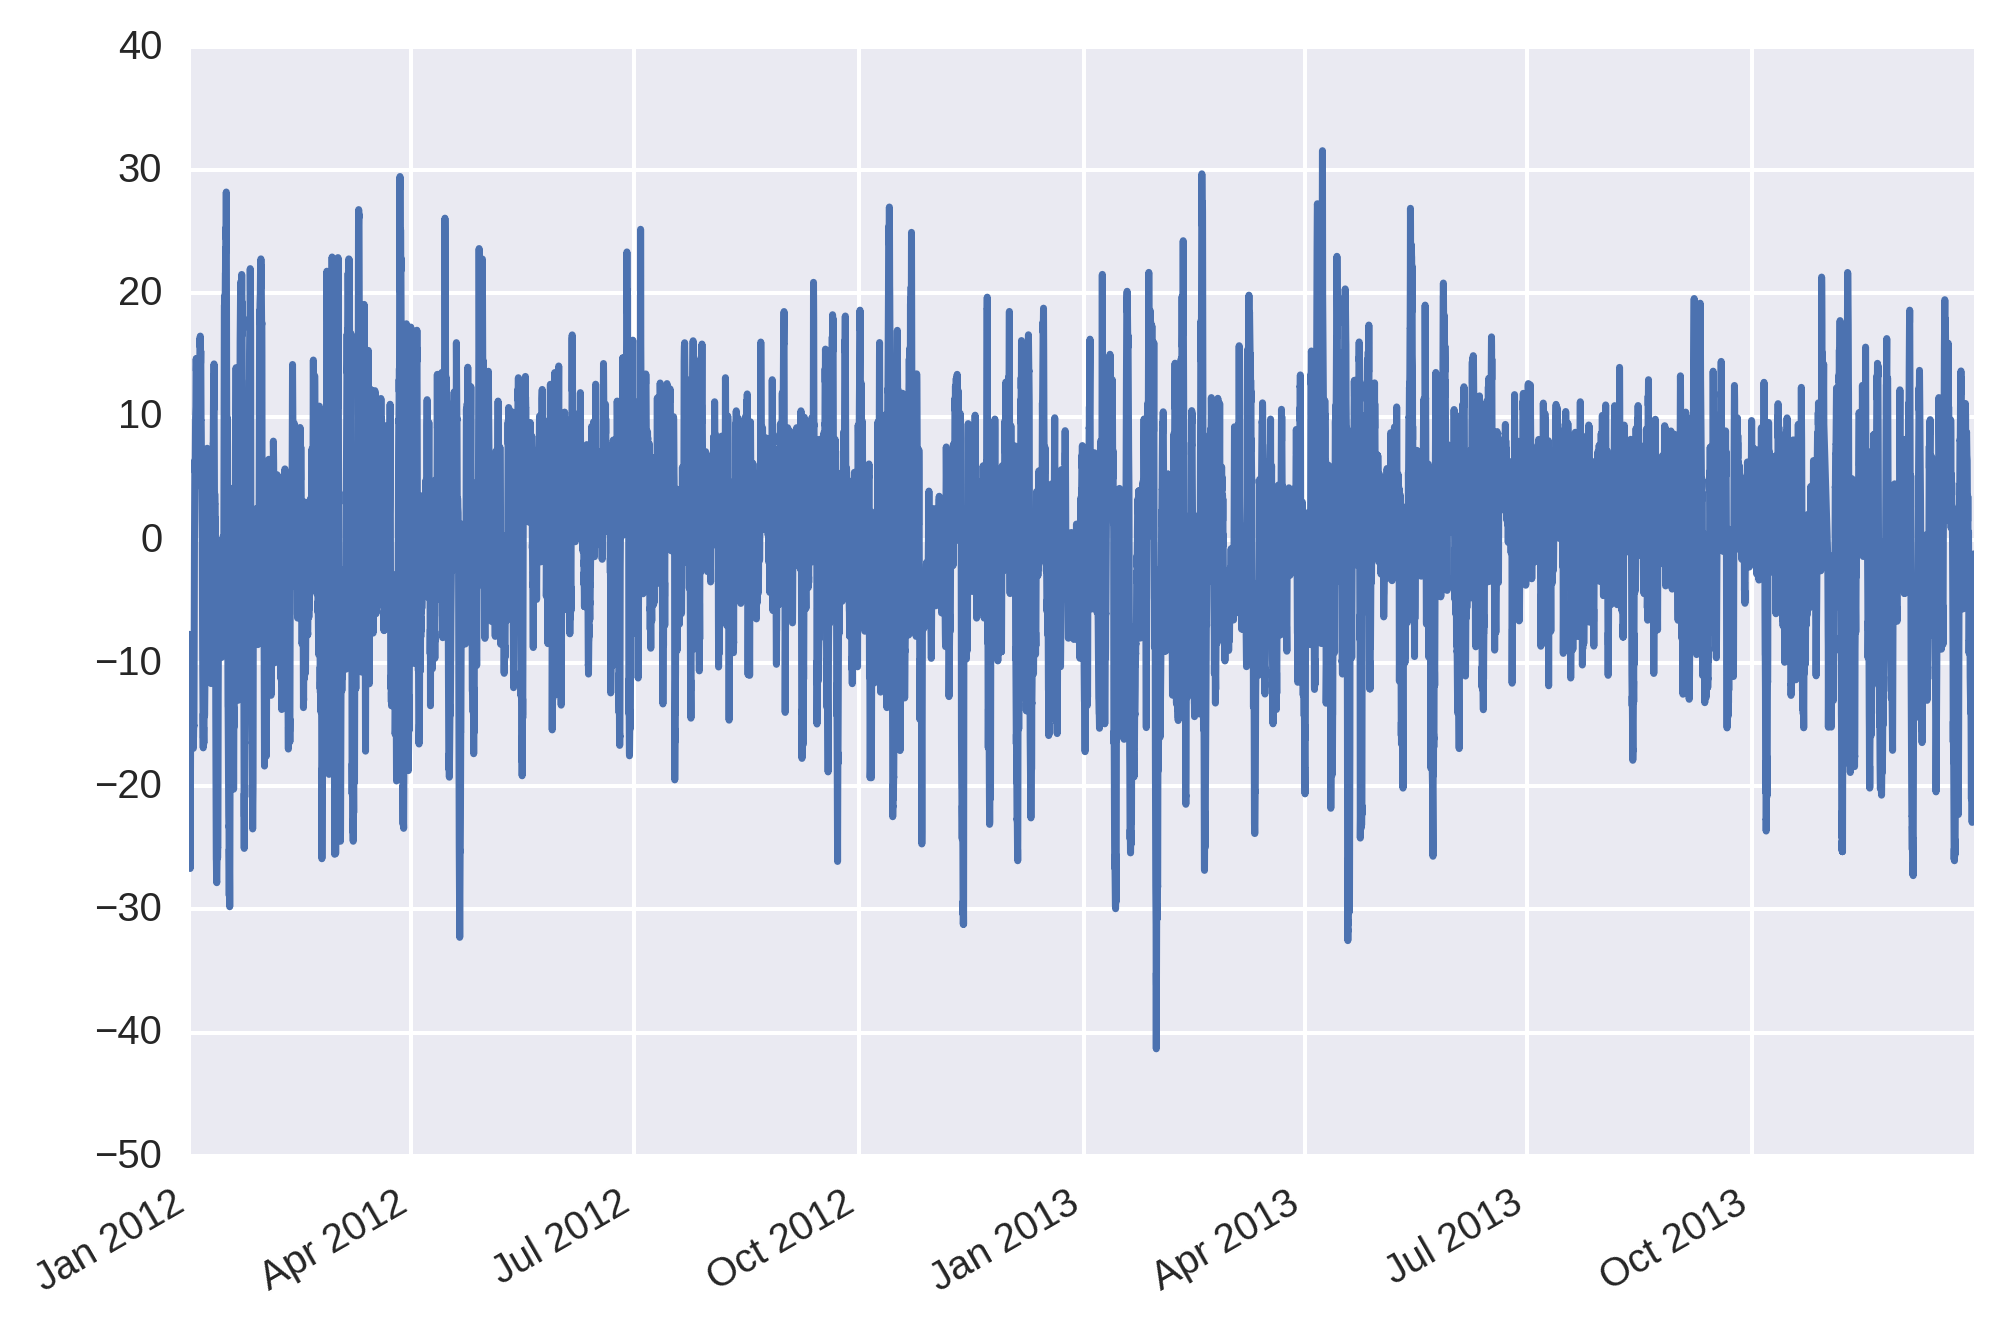

In [43]:
cut_year = 2012

train = temps_df[ temps_df.index.year < cut_year ].dropna(how='any')
test  = temps_df[ temps_df.index.year >= cut_year].dropna(how='any')

regress = sklearn.linear_model.LinearRegression().fit( 
        X=train[['Temperature']], 
        y=train['Goal'])

test['Predicted_Value'] = regress.predict( X = test[['Temperature']] )

(test['Goal'] - test['Predicted_Value']).plot()
print sklearn.metrics.mean_squared_error( test['Goal'], test['Predicted_Value'] )



61.3065395487


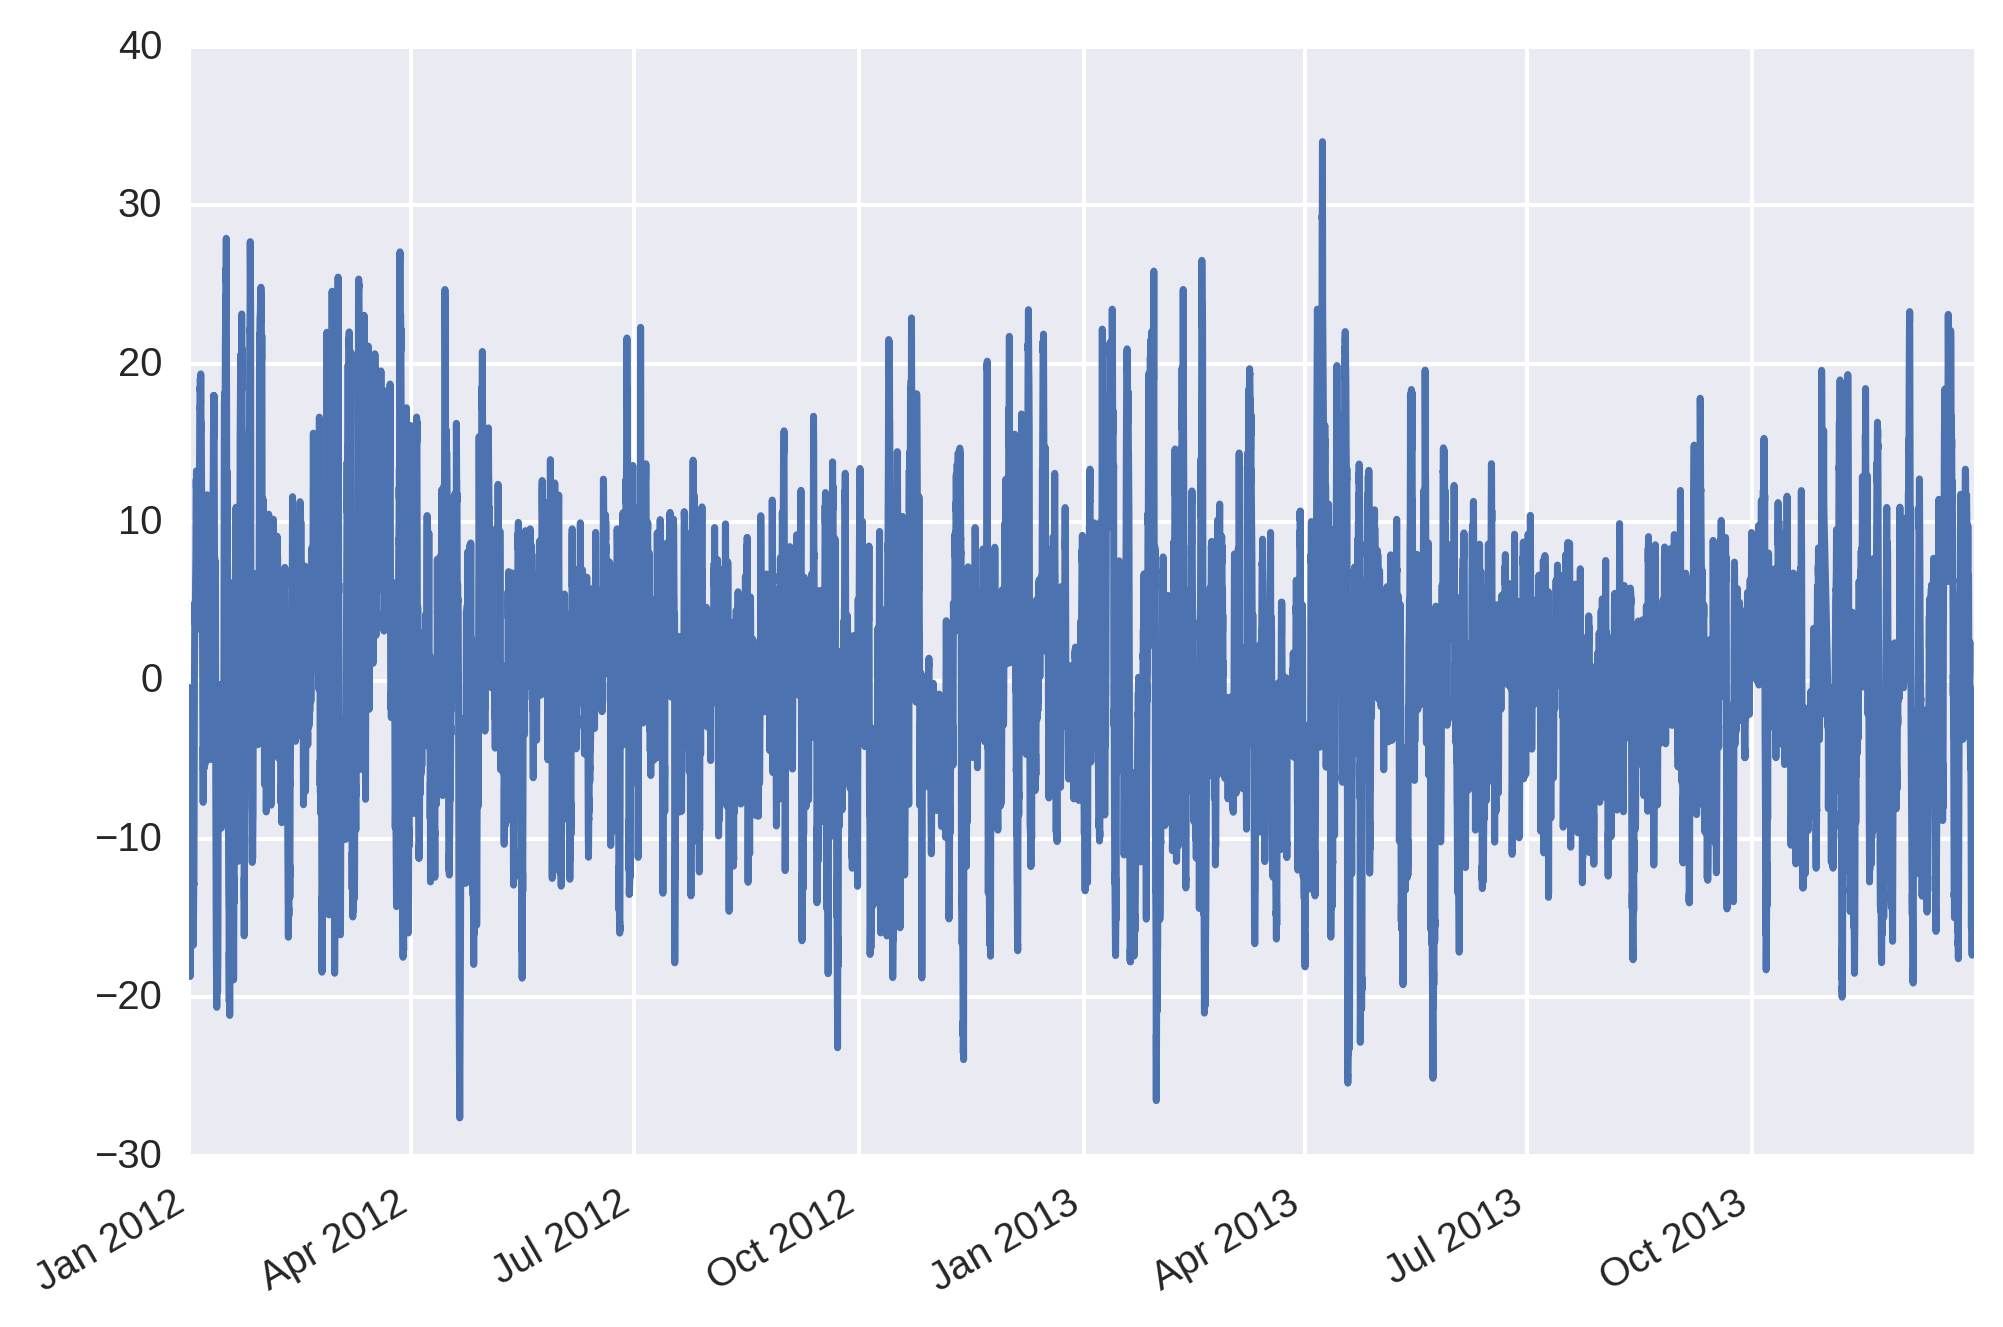

In [44]:
cut_year = 2012

train = temps_df[ temps_df.index.year < cut_year ].dropna(how='any')
test  = temps_df[ temps_df.index.year >= cut_year].dropna(how='any')

regress = sklearn.linear_model.LinearRegression().fit( 
        X=train[['Temperature', 'Day_Average', 'sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)', 'sin(day)', 'cos(day)']], 
        y=train['Goal'])

test['Predicted_Value'] = regress.predict( X = test[['Temperature', 'Day_Average', 'sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)', 'sin(day)', 'cos(day)']] )

(test['Goal'] - test['Predicted_Value']).plot()
print sklearn.metrics.mean_squared_error( test['Goal'], test['Predicted_Value'] )



61.2610392556


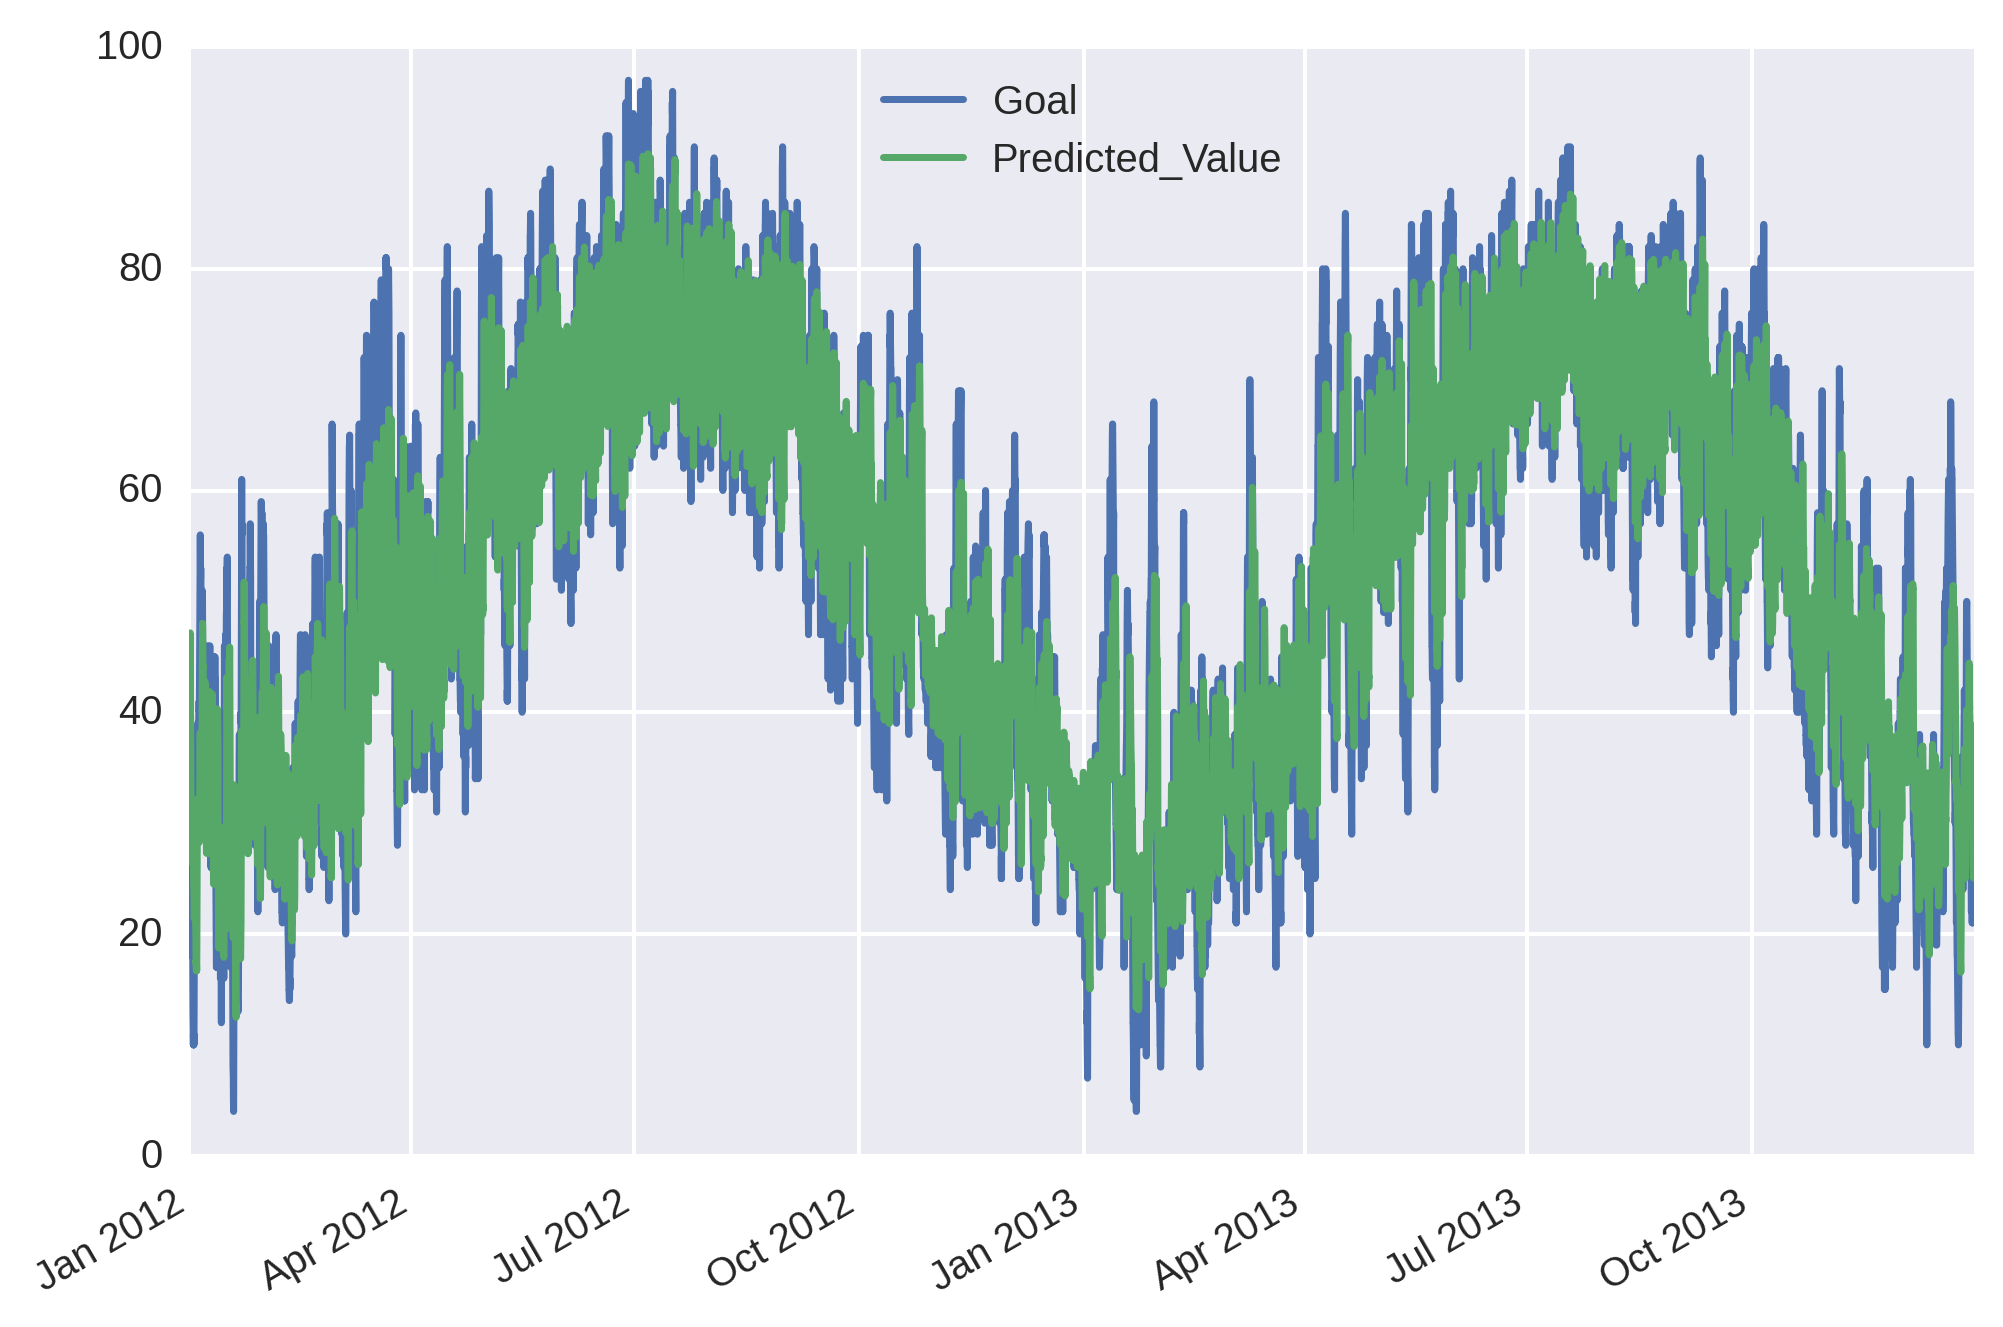

In [45]:
cut_year = 2012

train = temps_df[ temps_df.index.year < cut_year ].dropna(how='any')
test  = temps_df[ temps_df.index.year >= cut_year].dropna(how='any')

regress = sklearn.linear_model.LinearRegression().fit( 
        X=train[['Temperature', 'Day_Average', 'sin(year)', 'cos(year)', 'sin(day)', 'cos(day)']], 
        y=train['Goal'])

test['Predicted_Value'] = regress.predict( X = test[['Temperature', 'Day_Average', 'sin(year)', 'cos(year)', 'sin(day)', 'cos(day)']] )

test[['Goal', 'Predicted_Value']].plot()
print sklearn.metrics.mean_squared_error( test['Goal'], test['Predicted_Value'] )

plt.show()

*Copyright &copy; 2015 The Data Incubator.  All rights reserved.*